In [1]:
import pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [3]:
debug=False
submission=False
batch_size=32*3
device='cuda'
out=r'C:\Users\Kaggle\BengaliAI\V11_output'
image_size=64*2
arch='pretrained'
model_name='se_resnext50_32x4d'

In [4]:
datadir = Path(r'C:\Users\Kaggle\BengaliAI\inputs\bengaliai-cv19')
featherdir = Path(r'C:\Users\Kaggle\BengaliAI\inputs\bengaliaicv19feather')
outdir = Path(r'C:\Users\Kaggle\BengaliAI\V11_output')

In [5]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [6]:
%%time

train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)


image_df_list 4
Wall time: 13.5 s


<a id="dataset"></a>
# Dataset

In [7]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


In [8]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        x = x.astype(np.double)
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


In [9]:
train_dataset = BengaliAIDataset(train_images, train_labels)

image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


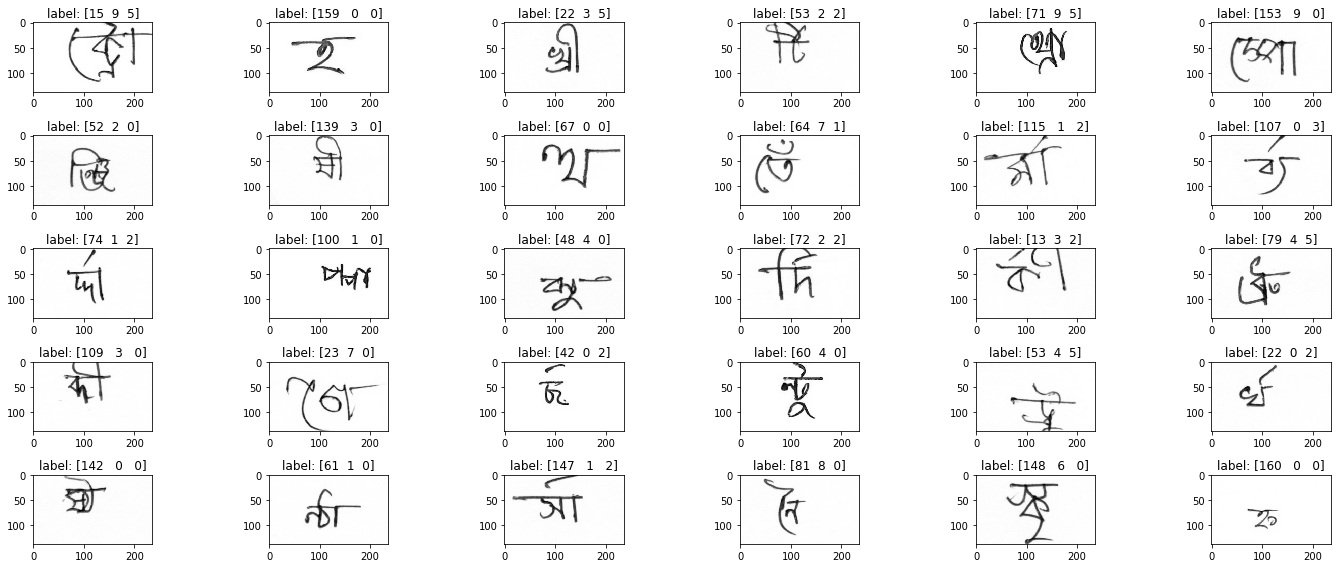

<Figure size 432x288 with 0 Axes>

In [10]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [11]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    
    #print("img.shape:", img.shape)
    
    # horizontal flip
    #if np.random.rand()<0.5:
    #img = img[:,::-1]
    
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 4
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    #tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
    #                        translation=(tx, ty))
    tform = AffineTransform(scale=(sx, sy), shear=shear_angle, rotation=rot_angle)
    
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


from scipy.ndimage.measurements import label

def connected_comp(array):
    
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)
    
    valid = []
    for i in range(1,ncomponents+1):
        if np.sum(labeled == i)>10:
            valid.append(i)

    new_array = np.zeros(array.shape)
    for i in valid:
        new_array += labeled==i
    return new_array

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    
    image[image < 20./255.] = 0
    
    is_black = image > threshold
    is_black[:5,:] = 0
    is_black[-5:,:] = 0
    is_black[:,:5] = 0
    is_black[:,-5:] = 0
    #is_black = connected_comp(is_black)
    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left-5:height - right+5, top-5:width - bottom+5]
    
    lx, ly = height - right - left + 10, width - bottom - top + 10
    l = max(lx,ly)
    #make sure that the aspect ratio is kept in rescaling
    cropped_image = np.pad(cropped_image, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    
    # scaling
    cropped_image = cropped_image*(1/cropped_image.max())
    
    #pad
    cropped_image = np.pad(cropped_image, 8, pad_with)
    
    return cropped_image

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

In [12]:
# Erosion
def erosion(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 3, 2)))
    img = cv2.erode(img, kernel, iterations=1)
    return img

# Dilation
def dilation(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 3, 2)))
    img = cv2.dilate(img, kernel, iterations=1)
    return img


def get_random_kernel():
    structure = np.random.choice([cv2.MORPH_RECT, cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS])
    kernel = cv2.getStructuringElement(structure, tuple(np.random.randint(1, 3, 2)))
    return kernel

# Opening
def opening(img):
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    return img

#Closing
def closing(img):
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    return img


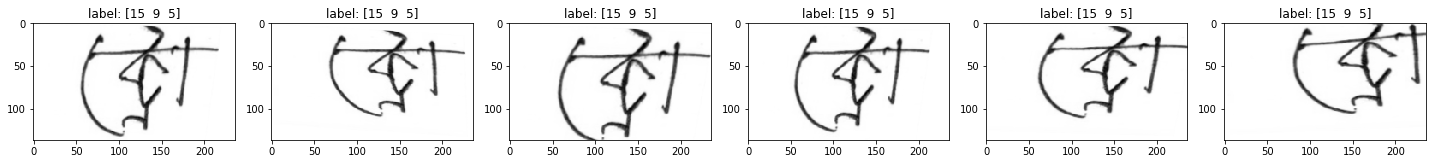

In [13]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[0]
    ax.imshow(affine_image(image), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

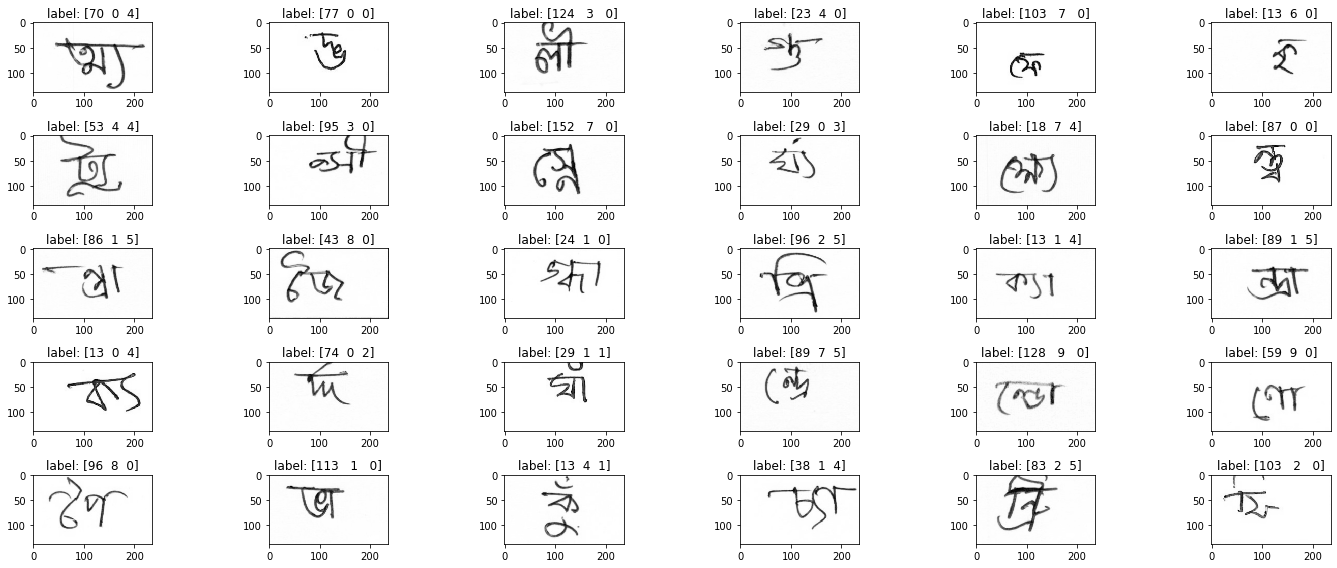

In [14]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i+30*5]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

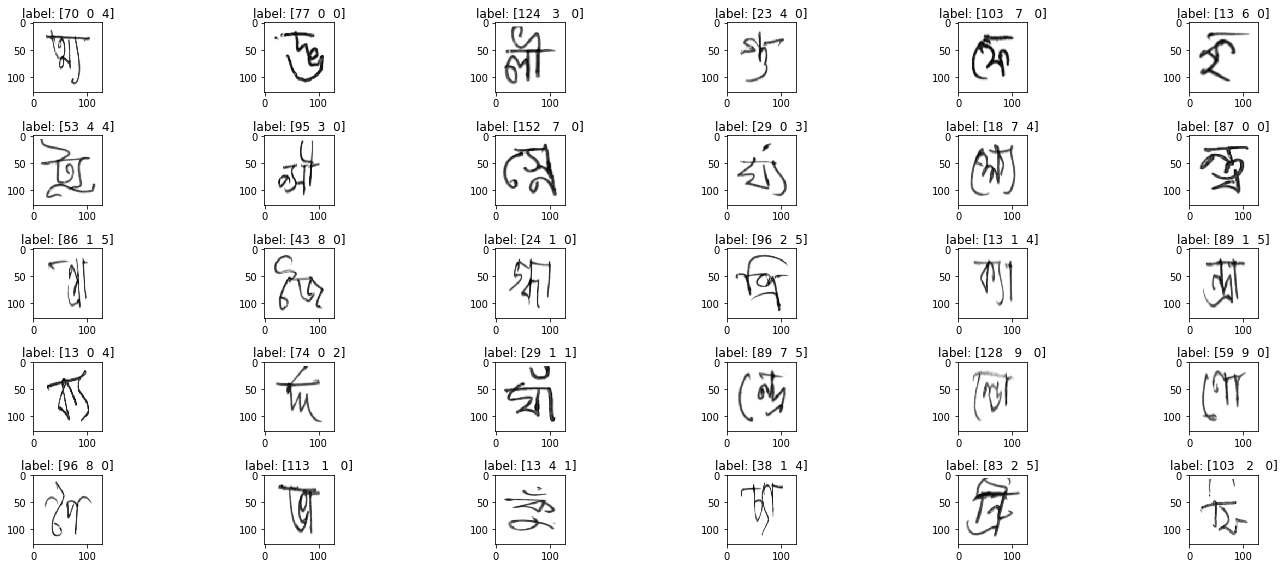

In [15]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i+30*5]
    ax.imshow(resize(crop_char_image(image, threshold=40./255.)), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [16]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']
        
        
class Transform:
    def __init__(self, affine=True, crop=False, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
                    
        # remove noise
        # x [x<28./255.] = 0
        
        # horizontal flip
        #x = x[:,:,::-1,:]

        
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
        
        

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.01,#0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)

            
        #plt.imshow(x[0,0].cpu().numpy())
        #plt.show()
        
        #if self.normalize:
        #    x = (x.astype(np.float32) - 0.0692) / 0.2051
        # normalize by its max val
        # x = x * (255./x.max())
        
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x
        

In [17]:
train_transform = Transform( crop=False,
    size=(128, 128), threshold=40.,
    sigma=-1., blur_ratio=0, noise_ratio=0, cutout_ratio=0,
    grid_distortion_ratio=0, random_brightness_ratio=0,
    piece_affine_ratio=0.2, ssr_ratio=0.2)

In [18]:
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

In [19]:
class Cutout:
    def __init__(self, mask_size, p, cutout_inside, mask_color=1):
        self.p = p
        self.mask_size = mask_size
        self.cutout_inside = cutout_inside
        self.mask_color = mask_color

        self.mask_size_half = mask_size // 2
        self.offset = 1 if mask_size % 2 == 0 else 0

    def __call__(self, image):
        image_all = copy.copy(image)
        image = image[0,0]
        #image = np.asarray(image).copy()

        if np.random.random() > self.p:
            return image

        h, w = image.shape[:2]

        if self.cutout_inside:
            cxmin, cxmax = self.mask_size_half, w + self.offset - self.mask_size_half
            cymin, cymax = self.mask_size_half, h + self.offset - self.mask_size_half
        else:
            cxmin, cxmax = 0, w + self.offset
            cymin, cymax = 0, h + self.offset

        cx = np.random.randint(cxmin, cxmax)
        cy = np.random.randint(cymin, cymax)
        xmin = cx - self.mask_size_half
        ymin = cy - self.mask_size_half
        xmax = xmin + self.mask_size
        ymax = ymin + self.mask_size
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(w, xmax)
        ymax = min(h, ymax)
        
        
        image_all[:, :, ymin:ymax, xmin:xmax] = self.mask_color
        return image_all

In [20]:
cutout = Cutout(32*2, 1, True, 0)

### Let's final check the processed images, which will be trained by the model.

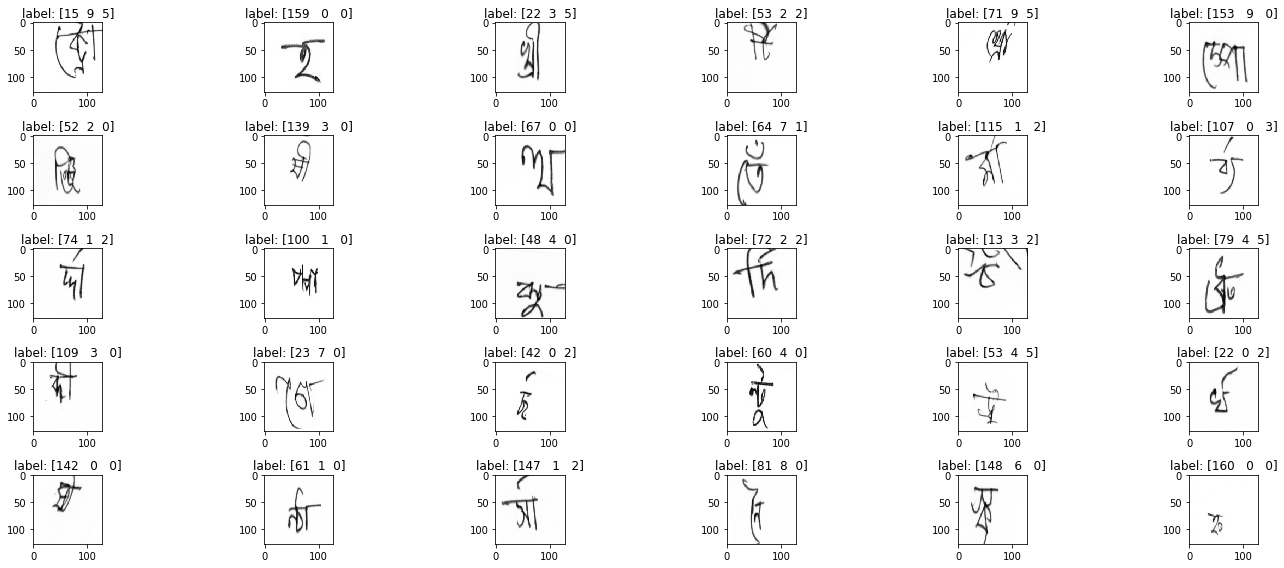

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [22]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [23]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [24]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [25]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [26]:
# GEM
# import torch.nn.functional as F

def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [27]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext50_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1_1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin1_2 = LinearBlock(hdim, 168, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers1 = Sequential(lin1_1, lin1_2)
        
        lin2_1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2_2 = LinearBlock(hdim, 11, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers2 = Sequential(lin2_1, lin2_2)

        lin3_1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin3_2 = LinearBlock(hdim, 7, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers3 = Sequential(lin3_1, lin3_2)

        self.pool = GeM()

    def forward(self, x):
        
        h = self.conv0(x)
        h = self.base_model.features(h)
        
        if self.do_pooling:
            
            #h1 = torch.sum(h, dim=(-1, -2))
            #h2 = torch.sum(h, dim=(-1, -2))
            #h3 = torch.sum(h, dim=(-1, -2))
            h1 = self.pool(h)[:,:,0,0]
            h2 = self.pool(h)[:,:,0,0]
            h3 = self.pool(h)[:,:,0,0]

            
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h1 = h.view(bs, ch*height*width)
            h2 = h.view(bs, ch*height*width)
            h3 = h.view(bs, ch*height*width)
        for layer in self.lin_layers1:
            h1 = layer(h1)
        for layer in self.lin_layers2:
            h2 = layer(h2)
        for layer in self.lin_layers3:
            h3 = layer(h3)
            
            
        return h1, h2, h3

## Classifier

In [28]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    while lam > 0.999:
        lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    
#     print(lam)
#     print(data.shape)
#     print(indices)
#     print(bbx1, bbx2, bby1, bby2)
    
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

In [29]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.double)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor.float()
        
        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']
        
    def forward(self, x, y=None):
        
        const = np.random.randint(6)
        if const<2:        
            # mixup
            data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4*2)
            x = data
        elif const<4:        
            # cutmix
            data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 0.4*2)
            x = data
        else:
            # cutout
            x = cutout(x)
        
        
        pred = self.predictor(x)
        
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_grapheme #self.n_total_class
            preds = pred #torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
            
        if const<4:
            # cutmix or mixup
            targets1, targets2, targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
            preds1, preds2, preds3 = preds[0], preds[1], preds[2]
            lam = float(lam)
            loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
            loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
            loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            loss = 2*loss_grapheme + loss_vowel + loss_consonant
            #loss = loss_grapheme + loss_vowel + loss_consonant
        else:
            loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
            loss_vowel = F.cross_entropy(preds[1], y[:, 1])
            loss_consonant = F.cross_entropy(preds[2], y[:, 2])
            loss = 2*loss_grapheme + loss_vowel + loss_consonant
            #loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    
    
    
    def forward_val(self, x, y=None):
        
        
        pred = self.predictor(x)
        #pred1 = self.predictor(x[:,:,::-1,:])
        #pred2 = self.predictor(x)
        #pred = (pred1+pred2)/2 
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = 2*loss_grapheme + loss_vowel + loss_consonant
        #loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

<a id="train"></a>
# Training code

## prepare data

In [30]:
# iterative-stratification

import copy
import numpy as np
import pandas as pd
import iterstrat
#!pip install iterative-stratification

#get data
nfold = 5
seed = 12

train_df = copy.copy(train)
train_df['id'] = train_df['image_id'].apply(lambda x: int(x.split('_')[1]))

X, y = train_df[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']]\
.values[:,0], train_df.values[:,1:]

train_df['fold'] = np.nan

#split data
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=nfold, random_state=seed)
for i, (_, test_index) in enumerate(mskf.split(X, y)):
    train_df.iloc[test_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

#------------------------------

n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.8)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#perm = np.random.RandomState(777).permutation(n_dataset)
#print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=train_transform,
    indices = np.array(list(train_df[train_df['fold']!=0].index)))
    #    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=False, size=(128, 128)),
    indices = np.array(list(train_df[train_df['fold']==0].index)))
#    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained='imagenet')
print('predictor', type(predictor))

C:\Users\Rajneesh Tiwari\.conda\envs\Pytorch\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


train_dataset 160672 valid_dataset 40168
n_total 186
predictor <class '__main__.PretrainedCNN'>


In [31]:
pretrainedmodels

<module 'pretrainedmodels' from 'C:\\Users\\Rajneesh Tiwari\\.conda\\envs\\Pytorch\\lib\\site-packages\\pretrainedmodels\\__init__.py'>

In [32]:
# #load weights
# predictor.load_state_dict(torch.load(r"/home/dohee/Documents/kaggle/Bengali/Bengali/save/model_000040.pt"))
predictor.train()

classifier = BengaliClassifier(predictor).to(device)

In [33]:
predictor

PretrainedCNN(
  (conv0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (base_model): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(25

## Ignite utility

pytorch-ignite utility class for training

In [34]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)    
    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()

        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        x = x.float()
        

        loss, metrics, pred_y = classifier(x, y)
        
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    
    
    trainer = Engine(update_fn)
    
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)
    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            x = x.float()
            _, metrics, pred_y = classifier.forward_val(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        
        ####
        print(elem)
        
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath=r'C:\Users\Kaggle\BengaliAI\V11_output\models\model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            print("saving model epoch:", self.count)
            
            #self.logger.warning(f'save model to {filepath}...')


import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [35]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)



# AdamW
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.003)
# optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.000343)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    pred_y = torch.cat((pred_y[0], pred_y[1], pred_y[2]), 1)
    
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor))
    #ModelSnapshotHandler(predictor, filepath=outdir / 'predictor.pt'))
#trainer.add_event_handler(Events.EPOCH_COMPLETED, engine_checkpoint, {'mymodel':classifier})

In [36]:
trainer.run(train_loader, max_epochs=50)

C:\Users\Rajneesh Tiwari\.conda\envs\Pytorch\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'epoch': 1, 'iteration': 1674, 'train/loss': 9.590471101775677, 'train/loss_grapheme': 3.6432172763589747, 'train/loss_vowel': 1.3608674334902917, 'train/loss_consonant': 0.9431691194663053, 'train/acc_grapheme': 0.1908726602947036, 'train/acc_vowel': 0.5125759159697338, 'train/acc_consonant': 0.6809724711270408, 'train/recall': 0.3653809697521316, 'valid/loss': 2.435277917789104, 'valid/loss_grapheme': 0.892575802125908, 'valid/loss_vowel': 0.35868420090908654, 'valid/loss_consonant': 0.2914421100676202, 'valid/acc_grapheme': 0.784402346857597, 'valid/acc_vowel': 0.9267253381066021, 'valid/acc_consonant': 0.924651949085123, 'valid/recall': 0.8668901364065978, 'lr': 0.003, 'elapsed_time': 2660.6544568}
epoch      1 train/loss  9.590471 train/loss_grapheme  3.643217 train/loss_vowel  1.360867 train/loss_consonant  0.943169 train/acc_grapheme  0.190873 train/acc_vowel  0.512576 train/acc_consonant  0.680972 train/recall  0.365381 valid/loss  2.435278 valid/loss_grapheme  0.892576 valid/

{'epoch': 2, 'iteration': 3348, 'train/loss': 6.9077231193243955, 'train/loss_grapheme': 2.607884617261989, 'train/loss_vowel': 1.0409032144676116, 'train/loss_consonant': 0.6510506633718096, 'train/acc_grapheme': 0.360915098566308, 'train/acc_vowel': 0.6129965651135011, 'train/acc_consonant': 0.7490261598964559, 'train/recall': 0.4979336043400866, 'valid/loss': 1.588322710023575, 'valid/loss_grapheme': 0.5663264858978745, 'valid/loss_vowel': 0.259478975594186, 'valid/loss_consonant': 0.19619076065985855, 'valid/acc_grapheme': 0.8802307080350041, 'valid/acc_vowel': 0.9571847653142403, 'valid/acc_consonant': 0.9607995226730307, 'valid/recall': 0.9175787678106724, 'lr': 0.003, 'elapsed_time': 4915.781377}
epoch      2 train/loss  6.907723 train/loss_grapheme  2.607885 train/loss_vowel  1.040903 train/loss_consonant  0.651051 train/acc_grapheme  0.360915 train/acc_vowel  0.612997 train/acc_consonant  0.749026 train/recall  0.497934 valid/loss  1.588323 valid/loss_grapheme  0.566326 valid/

{'epoch': 3, 'iteration': 5022, 'train/loss': 6.3871224850879065, 'train/loss_grapheme': 2.4093849395124716, 'train/loss_vowel': 0.96394495496898, 'train/loss_consonant': 0.6044076564170981, 'train/acc_grapheme': 0.3981108124253296, 'train/acc_vowel': 0.6317639884508172, 'train/acc_consonant': 0.7619318747510964, 'train/recall': 0.531298660658017, 'valid/loss': 1.5528440094221747, 'valid/loss_grapheme': 0.5309767215946125, 'valid/loss_vowel': 0.28229556337603523, 'valid/loss_consonant': 0.20859499905160617, 'valid/acc_grapheme': 0.8955648369132849, 'valid/acc_vowel': 0.965488265712013, 'valid/acc_consonant': 0.966129673826572, 'valid/recall': 0.9302219606717046, 'lr': 0.003, 'elapsed_time': 7166.565550900001}
epoch      3 train/loss  6.387122 train/loss_grapheme  2.409385 train/loss_vowel  0.963945 train/loss_consonant  0.604408 train/acc_grapheme  0.398111 train/acc_vowel  0.631764 train/acc_consonant  0.761932 train/recall  0.531299 valid/loss  1.552844 valid/loss_grapheme  0.530977 

{'epoch': 4, 'iteration': 6696, 'train/loss': 6.107831068078819, 'train/loss_grapheme': 2.298122949248431, 'train/loss_vowel': 0.9266547006660607, 'train/loss_consonant': 0.5849304658003606, 'train/acc_grapheme': 0.4024261997212268, 'train/acc_vowel': 0.6243559587813625, 'train/acc_consonant': 0.755783925726803, 'train/recall': 0.5272956330509824, 'valid/loss': 1.4162084962416948, 'valid/loss_grapheme': 0.46160054662062616, 'valid/loss_vowel': 0.2875172080103139, 'valid/loss_consonant': 0.205490192536238, 'valid/acc_grapheme': 0.916701471758154, 'valid/acc_vowel': 0.9727724741447888, 'valid/acc_consonant': 0.9673229912490053, 'valid/recall': 0.9434048822637373, 'lr': 0.003, 'elapsed_time': 9421.826959600001}
epoch      4 train/loss  6.107831 train/loss_grapheme  2.298123 train/loss_vowel  0.926655 train/loss_consonant  0.584930 train/acc_grapheme  0.402426 train/acc_vowel  0.624356 train/acc_consonant  0.755784 train/recall  0.527296 valid/loss  1.416208 valid/loss_grapheme  0.461601 v

{'epoch': 5, 'iteration': 8370, 'train/loss': 5.958116413159752, 'train/loss_grapheme': 2.228895086274352, 'train/loss_vowel': 0.9183812696962943, 'train/loss_consonant': 0.581944967496566, 'train/acc_grapheme': 0.42492719534050194, 'train/acc_vowel': 0.6325978195937874, 'train/acc_consonant': 0.760920698924732, 'train/recall': 0.5456540667071899, 'valid/loss': 1.347089680396287, 'valid/loss_grapheme': 0.44115320950533154, 'valid/loss_vowel': 0.27593869952427175, 'valid/loss_consonant': 0.18884456228811589, 'valid/acc_grapheme': 0.9288931980906912, 'valid/acc_vowel': 0.9768247812251385, 'valid/acc_consonant': 0.9753679395385836, 'valid/recall': 0.9534820296390212, 'lr': 0.003, 'elapsed_time': 11672.337088600001}
epoch      5 train/loss  5.958116 train/loss_grapheme  2.228895 train/loss_vowel  0.918381 train/loss_consonant  0.581945 train/acc_grapheme  0.424927 train/acc_vowel  0.632598 train/acc_consonant  0.760921 train/recall  0.545654 valid/loss  1.347090 valid/loss_grapheme  0.4411

{'epoch': 6, 'iteration': 10044, 'train/loss': 5.70443163472122, 'train/loss_grapheme': 2.1402603104585958, 'train/loss_vowel': 0.870384305751167, 'train/loss_consonant': 0.5535267020754846, 'train/acc_grapheme': 0.44137046993229734, 'train/acc_vowel': 0.6524635354440458, 'train/acc_consonant': 0.7725912236160901, 'train/recall': 0.5641115711076199, 'valid/loss': 1.0000118668722366, 'valid/loss_grapheme': 0.335269669395358, 'valid/loss_vowel': 0.18052960037829482, 'valid/loss_consonant': 0.14894292741871676, 'valid/acc_grapheme': 0.921131662688942, 'valid/acc_vowel': 0.9775706046141612, 'valid/acc_consonant': 0.970753778838504, 'valid/recall': 0.9458372125127824, 'lr': 0.003, 'elapsed_time': 13919.7482339}
epoch      6 train/loss  5.704432 train/loss_grapheme  2.140260 train/loss_vowel  0.870384 train/loss_consonant  0.553527 train/acc_grapheme  0.441370 train/acc_vowel  0.652464 train/acc_consonant  0.772591 train/recall  0.564112 valid/loss  1.000012 valid/loss_grapheme  0.335270 val

{'epoch': 7, 'iteration': 11718, 'train/loss': 5.607730319957152, 'train/loss_grapheme': 2.098557944597594, 'train/loss_vowel': 0.8585519026007988, 'train/loss_consonant': 0.552062535398109, 'train/acc_grapheme': 0.4463081192751889, 'train/acc_vowel': 0.6516639287136583, 'train/acc_consonant': 0.7723360961768219, 'train/recall': 0.5663496299514416, 'valid/loss': 0.9792704169676242, 'valid/loss_grapheme': 0.3229267979151878, 'valid/loss_vowel': 0.19701991196463955, 'valid/loss_consonant': 0.13639690709213653, 'valid/acc_grapheme': 0.9386833731105811, 'valid/acc_vowel': 0.9801064041368336, 'valid/acc_consonant': 0.9782617342879871, 'valid/recall': 0.9600565790147704, 'lr': 0.003, 'elapsed_time': 16168.4279317}
epoch      7 train/loss  5.607730 train/loss_grapheme  2.098558 train/loss_vowel  0.858552 train/loss_consonant  0.552063 train/acc_grapheme  0.446308 train/acc_vowel  0.651664 train/acc_consonant  0.772336 train/recall  0.566350 valid/loss  0.979270 valid/loss_grapheme  0.322927 v

{'epoch': 8, 'iteration': 13392, 'train/loss': 5.396487193794091, 'train/loss_grapheme': 2.0144746171103582, 'train/loss_vowel': 0.8328942159055026, 'train/loss_consonant': 0.5346437452122872, 'train/acc_grapheme': 0.45601229589804954, 'train/acc_vowel': 0.6521617383512542, 'train/acc_consonant': 0.7695172491039428, 'train/recall': 0.5697573854384699, 'valid/loss': 0.9666379303237987, 'valid/loss_grapheme': 0.31732463434800895, 'valid/loss_vowel': 0.18618554570367626, 'valid/loss_consonant': 0.14580311316792322, 'valid/acc_grapheme': 0.9370077565632461, 'valid/acc_vowel': 0.980479315831345, 'valid/acc_consonant': 0.979678798727128, 'valid/recall': 0.9603846235343085, 'lr': 0.003, 'elapsed_time': 18420.922037}
epoch      8 train/loss  5.396487 train/loss_grapheme  2.014475 train/loss_vowel  0.832894 train/loss_consonant  0.534644 train/acc_grapheme  0.456012 train/acc_vowel  0.652162 train/acc_consonant  0.769517 train/recall  0.569757 valid/loss  0.966638 valid/loss_grapheme  0.317325 

{'epoch': 9, 'iteration': 15066, 'train/loss': 5.270297396140286, 'train/loss_grapheme': 1.9720202701137342, 'train/loss_vowel': 0.8055259206130869, 'train/loss_consonant': 0.5207309454652784, 'train/acc_grapheme': 0.4637719036240547, 'train/acc_vowel': 0.6636766975308646, 'train/acc_consonant': 0.7774075318598169, 'train/recall': 0.582506611072021, 'valid/loss': 1.0009980426483336, 'valid/loss_grapheme': 0.31875290076175, 'valid/loss_vowel': 0.21586352302237172, 'valid/loss_consonant': 0.14762871634206226, 'valid/acc_grapheme': 0.9351034208432779, 'valid/acc_vowel': 0.9819212410501191, 'valid/acc_consonant': 0.9750944709626089, 'valid/recall': 0.9554013646422415, 'lr': 0.003, 'elapsed_time': 20677.34106}
epoch      9 train/loss  5.270297 train/loss_grapheme  1.972020 train/loss_vowel  0.805526 train/loss_consonant  0.520731 train/acc_grapheme  0.463772 train/acc_vowel  0.663677 train/acc_consonant  0.777408 train/recall  0.582507 valid/loss  1.000998 valid/loss_grapheme  0.318753 vali

{'epoch': 10, 'iteration': 16740, 'train/loss': 5.298237288760171, 'train/loss_grapheme': 1.9800380064595131, 'train/loss_vowel': 0.8143116329822204, 'train/loss_consonant': 0.5238496436645125, 'train/acc_grapheme': 0.4726578056551168, 'train/acc_vowel': 0.6687761350059741, 'train/acc_consonant': 0.7838323874950223, 'train/recall': 0.5909204056856467, 'valid/loss': 0.8394329461106822, 'valid/loss_grapheme': 0.296972725495945, 'valid/loss_vowel': 0.131111700061113, 'valid/loss_consonant': 0.11437579608902441, 'valid/acc_grapheme': 0.9317124105011929, 'valid/acc_vowel': 0.9803400954653935, 'valid/acc_consonant': 0.97735182975338, 'valid/recall': 0.9490509423783686, 'lr': 0.003, 'elapsed_time': 22927.8018017}
epoch     10 train/loss  5.298237 train/loss_grapheme  1.980038 train/loss_vowel  0.814312 train/loss_consonant  0.523850 train/acc_grapheme  0.472658 train/acc_vowel  0.668776 train/acc_consonant  0.783832 train/recall  0.590920 valid/loss  0.839433 valid/loss_grapheme  0.296973 val

{'epoch': 11, 'iteration': 18414, 'train/loss': 5.203905437119403, 'train/loss_grapheme': 1.9409033751811748, 'train/loss_vowel': 0.8011050218206651, 'train/loss_consonant': 0.520993664148603, 'train/acc_grapheme': 0.4703181003584223, 'train/acc_vowel': 0.6653101354042226, 'train/acc_consonant': 0.7784373755475895, 'train/recall': 0.5855653462366877, 'valid/loss': 0.7647742962638063, 'valid/loss_grapheme': 0.24917335671357152, 'valid/loss_vowel': 0.14104471912247468, 'valid/loss_consonant': 0.12538286369640675, 'valid/acc_grapheme': 0.946827764518695, 'valid/acc_vowel': 0.9838951869530628, 'valid/acc_consonant': 0.9808721161495615, 'valid/recall': 0.9622561689543687, 'lr': 0.003, 'elapsed_time': 25173.3038522}
epoch     11 train/loss  5.203905 train/loss_grapheme  1.940903 train/loss_vowel  0.801105 train/loss_consonant  0.520994 train/acc_grapheme  0.470318 train/acc_vowel  0.665310 train/acc_consonant  0.778437 train/recall  0.585565 valid/loss  0.764774 valid/loss_grapheme  0.249173

{'epoch': 12, 'iteration': 20088, 'train/loss': 5.073014289496762, 'train/loss_grapheme': 1.891654235852733, 'train/loss_vowel': 0.7814004985146056, 'train/loss_consonant': 0.5083053196906118, 'train/acc_grapheme': 0.4822997560732768, 'train/acc_vowel': 0.6737822331740352, 'train/acc_consonant': 0.7854067104739154, 'train/recall': 0.5948740407192292, 'valid/loss': 0.8136075732247072, 'valid/loss_grapheme': 0.26401704057233144, 'valid/loss_vowel': 0.16946125946281065, 'valid/loss_consonant': 0.1161122337908335, 'valid/acc_grapheme': 0.9482895783611786, 'valid/acc_vowel': 0.982552704852824, 'valid/acc_consonant': 0.9818416865552902, 'valid/recall': 0.9638095058219888, 'lr': 0.003, 'elapsed_time': 27420.5745608}
epoch     12 train/loss  5.073014 train/loss_grapheme  1.891654 train/loss_vowel  0.781400 train/loss_consonant  0.508305 train/acc_grapheme  0.482300 train/acc_vowel  0.673782 train/acc_consonant  0.785407 train/recall  0.594874 valid/loss  0.813608 valid/loss_grapheme  0.264017 

{'epoch': 13, 'iteration': 21762, 'train/loss': 5.090118163126202, 'train/loss_grapheme': 1.8991873688826708, 'train/loss_vowel': 0.7817986887482439, 'train/loss_consonant': 0.5099447397303767, 'train/acc_grapheme': 0.48293446336121, 'train/acc_vowel': 0.6792332487056951, 'train/acc_consonant': 0.7871148197929111, 'train/recall': 0.5995378020237311, 'valid/loss': 0.7134965052894875, 'valid/loss_grapheme': 0.24330391036013146, 'valid/loss_vowel': 0.11694890004638271, 'valid/loss_consonant': 0.1099397830914057, 'valid/acc_grapheme': 0.947424423229913, 'valid/acc_vowel': 0.9834476929196496, 'valid/acc_consonant': 0.9811207239459028, 'valid/recall': 0.9650606789845474, 'lr': 0.003, 'elapsed_time': 29671.638304199998}
epoch     13 train/loss  5.090118 train/loss_grapheme  1.899187 train/loss_vowel  0.781799 train/loss_consonant  0.509945 train/acc_grapheme  0.482934 train/acc_vowel  0.679233 train/acc_consonant  0.787115 train/recall  0.599538 valid/loss  0.713497 valid/loss_grapheme  0.243

{'epoch': 14, 'iteration': 23436, 'train/loss': 5.01237834596577, 'train/loss_grapheme': 1.8699763030383465, 'train/loss_vowel': 0.7709183493359827, 'train/loss_consonant': 0.5015073828933273, 'train/acc_grapheme': 0.4834571634806847, 'train/acc_vowel': 0.6763895111509358, 'train/acc_consonant': 0.7851018020708878, 'train/recall': 0.5985938883912574, 'valid/loss': 0.7315309307313478, 'valid/loss_grapheme': 0.2476097444574702, 'valid/loss_vowel': 0.12759473646028513, 'valid/loss_consonant': 0.10871670290223169, 'valid/acc_grapheme': 0.9507955449482891, 'valid/acc_vowel': 0.9853868337311061, 'valid/acc_consonant': 0.9827863961813836, 'valid/recall': 0.965511170695267, 'lr': 0.003, 'elapsed_time': 31923.5544523}
epoch     14 train/loss  5.012378 train/loss_grapheme  1.869976 train/loss_vowel  0.770918 train/loss_consonant  0.501507 train/acc_grapheme  0.483457 train/acc_vowel  0.676390 train/acc_consonant  0.785102 train/recall  0.598594 valid/loss  0.731531 valid/loss_grapheme  0.247610 

{'epoch': 15, 'iteration': 25110, 'train/loss': 4.91301620586941, 'train/loss_grapheme': 1.8251652919343508, 'train/loss_vowel': 0.7634189556928056, 'train/loss_consonant': 0.4992666661899577, 'train/acc_grapheme': 0.4819730684986058, 'train/acc_vowel': 0.6660319593787337, 'train/acc_consonant': 0.7801237056949418, 'train/recall': 0.5893624267025025, 'valid/loss': 0.7118866329830416, 'valid/loss_grapheme': 0.23700964116538054, 'valid/loss_vowel': 0.12765035612913192, 'valid/loss_consonant': 0.11021699317173059, 'valid/acc_grapheme': 0.9506414081145592, 'valid/acc_vowel': 0.9849542561654719, 'valid/acc_consonant': 0.9814190533015111, 'valid/recall': 0.9662306183882579, 'lr': 0.003, 'elapsed_time': 34174.636796}
epoch     15 train/loss  4.913016 train/loss_grapheme  1.825165 train/loss_vowel  0.763419 train/loss_consonant  0.499267 train/acc_grapheme  0.481973 train/acc_vowel  0.666032 train/acc_consonant  0.780124 train/recall  0.589362 valid/loss  0.711887 valid/loss_grapheme  0.237010

{'epoch': 16, 'iteration': 26784, 'train/loss': 4.9802471459125535, 'train/loss_grapheme': 1.848023294868435, 'train/loss_vowel': 0.7765137927435347, 'train/loss_consonant': 0.5076867649854654, 'train/acc_grapheme': 0.48527727996813963, 'train/acc_vowel': 0.6715949820788536, 'train/acc_consonant': 0.7811753285543607, 'train/recall': 0.59643641778603, 'valid/loss': 0.7090703721973948, 'valid/loss_grapheme': 0.24800975137081238, 'valid/loss_vowel': 0.10508900646093637, 'valid/loss_consonant': 0.1079618628792518, 'valid/acc_grapheme': 0.9395286396181377, 'valid/acc_vowel': 0.9827118138424819, 'valid/acc_consonant': 0.9751640811455857, 'valid/recall': 0.9584335067280201, 'lr': 0.003, 'elapsed_time': 36428.589579600004}
epoch     16 train/loss  4.980247 train/loss_grapheme  1.848023 train/loss_vowel  0.776514 train/loss_consonant  0.507687 train/acc_grapheme  0.485277 train/acc_vowel  0.671595 train/acc_consonant  0.781175 train/recall  0.596436 valid/loss  0.709070 valid/loss_grapheme  0.2

{'epoch': 17, 'iteration': 28458, 'train/loss': 4.845227690705119, 'train/loss_grapheme': 1.7988444632642515, 'train/loss_vowel': 0.7506510034012146, 'train/loss_consonant': 0.49688776597167, 'train/acc_grapheme': 0.49088386101154896, 'train/acc_vowel': 0.6771548934687379, 'train/acc_consonant': 0.783067005177221, 'train/recall': 0.6013620215147641, 'valid/loss': 0.702178560321826, 'valid/loss_grapheme': 0.23030790432327403, 'valid/loss_vowel': 0.1345836890234583, 'valid/loss_consonant': 0.10697906140709265, 'valid/acc_grapheme': 0.9527048528241839, 'valid/acc_vowel': 0.9851133651551316, 'valid/acc_consonant': 0.9825875099443111, 'valid/recall': 0.9684310334298343, 'lr': 0.003, 'elapsed_time': 38676.355235}
epoch     17 train/loss  4.845228 train/loss_grapheme  1.798844 train/loss_vowel  0.750651 train/loss_consonant  0.496888 train/acc_grapheme  0.490884 train/acc_vowel  0.677155 train/acc_consonant  0.783067 train/recall  0.601362 valid/loss  0.702179 valid/loss_grapheme  0.230308 va

{'epoch': 18, 'iteration': 30132, 'train/loss': 4.87007761560603, 'train/loss_grapheme': 1.8089689945483862, 'train/loss_vowel': 0.7574420000739137, 'train/loss_consonant': 0.49469762550513374, 'train/acc_grapheme': 0.4949565661091196, 'train/acc_vowel': 0.6800110762644375, 'train/acc_consonant': 0.7859480784547984, 'train/recall': 0.6046497609962516, 'valid/loss': 0.6368147878060761, 'valid/loss_grapheme': 0.2143904143557628, 'valid/loss_vowel': 0.1116860905808879, 'valid/loss_consonant': 0.09634786768680825, 'valid/acc_grapheme': 0.9533164280031821, 'valid/acc_vowel': 0.9867790373906122, 'valid/acc_consonant': 0.9844868735083523, 'valid/recall': 0.9675435841279316, 'lr': 0.003, 'elapsed_time': 40929.9014171}
epoch     18 train/loss  4.870078 train/loss_grapheme  1.808969 train/loss_vowel  0.757442 train/loss_consonant  0.494698 train/acc_grapheme  0.494957 train/acc_vowel  0.680011 train/acc_consonant  0.785948 train/recall  0.604650 valid/loss  0.636815 valid/loss_grapheme  0.214390

{'epoch': 19, 'iteration': 31806, 'train/loss': 4.761450154361902, 'train/loss_grapheme': 1.7619526817985192, 'train/loss_vowel': 0.746255928666076, 'train/loss_consonant': 0.49128886004698463, 'train/acc_grapheme': 0.49334179609717255, 'train/acc_vowel': 0.671756770211071, 'train/acc_consonant': 0.7809606481481491, 'train/recall': 0.600133405464307, 'valid/loss': 0.6542911811916242, 'valid/loss_grapheme': 0.21613986422096632, 'valid/loss_vowel': 0.12122103342506367, 'valid/loss_consonant': 0.10079042066715498, 'valid/acc_grapheme': 0.952222553699284, 'valid/acc_vowel': 0.9858840493237863, 'valid/acc_consonant': 0.9849990055688136, 'valid/recall': 0.9672869010793934, 'lr': 0.003, 'elapsed_time': 43185.1426185}
epoch     19 train/loss  4.761450 train/loss_grapheme  1.761953 train/loss_vowel  0.746256 train/loss_consonant  0.491289 train/acc_grapheme  0.493342 train/acc_vowel  0.671757 train/acc_consonant  0.780961 train/recall  0.600133 valid/loss  0.654291 valid/loss_grapheme  0.216140

{'epoch': 20, 'iteration': 33480, 'train/loss': 4.721337638733065, 'train/loss_grapheme': 1.74877257894373, 'train/loss_vowel': 0.7387543913564482, 'train/loss_consonant': 0.48503809187921787, 'train/acc_grapheme': 0.5164899442453192, 'train/acc_vowel': 0.693949746117084, 'train/acc_consonant': 0.7947219733174039, 'train/recall': 0.6226335247707522, 'valid/loss': 0.638162080811999, 'valid/loss_grapheme': 0.2144754591057864, 'valid/loss_vowel': 0.10491125781738103, 'valid/loss_consonant': 0.10429990390284534, 'valid/acc_grapheme': 0.9543953858392995, 'valid/acc_vowel': 0.9853371121718374, 'valid/acc_consonant': 0.9804246221161491, 'valid/recall': 0.9669345635846267, 'lr': 0.003, 'elapsed_time': 45432.388920900004}
epoch     20 train/loss  4.721338 train/loss_grapheme  1.748773 train/loss_vowel  0.738754 train/loss_consonant  0.485038 train/acc_grapheme  0.516490 train/acc_vowel  0.693950 train/acc_consonant  0.794722 train/recall  0.622634 valid/loss  0.638162 valid/loss_grapheme  0.214

{'epoch': 21, 'iteration': 35154, 'train/loss': 4.73963912459827, 'train/loss_grapheme': 1.758234844866833, 'train/loss_vowel': 0.7378734286603036, 'train/loss_consonant': 0.4852960156532741, 'train/acc_grapheme': 0.49873058542413395, 'train/acc_vowel': 0.6801293060533646, 'train/acc_consonant': 0.7867103494623644, 'train/recall': 0.6045882112744947, 'valid/loss': 0.8028104686509453, 'valid/loss_grapheme': 0.2545473905266896, 'valid/loss_vowel': 0.17207885204607662, 'valid/loss_consonant': 0.12163683409338066, 'valid/acc_grapheme': 0.9572792362768501, 'valid/acc_vowel': 0.9862321002386634, 'valid/acc_consonant': 0.9843526252983287, 'valid/recall': 0.9719250146493126, 'lr': 0.003, 'elapsed_time': 47684.3542699}
epoch     21 train/loss  4.739639 train/loss_grapheme  1.758235 train/loss_vowel  0.737873 train/loss_consonant  0.485296 train/acc_grapheme  0.498731 train/acc_vowel  0.680129 train/acc_consonant  0.786710 train/recall  0.604588 valid/loss  0.802810 valid/loss_grapheme  0.254547

{'epoch': 22, 'iteration': 36828, 'train/loss': 4.772194357221699, 'train/loss_grapheme': 1.7672757375072976, 'train/loss_vowel': 0.7467874061503184, 'train/loss_consonant': 0.4908554792591107, 'train/acc_grapheme': 0.48192017622461186, 'train/acc_vowel': 0.66813520509757, 'train/acc_consonant': 0.7794547739944235, 'train/recall': 0.5914767885751759, 'valid/loss': 0.737461751429164, 'valid/loss_grapheme': 0.23986661663559, 'valid/loss_vowel': 0.14372355460693842, 'valid/loss_consonant': 0.11400496379999102, 'valid/acc_grapheme': 0.9539727525855208, 'valid/acc_vowel': 0.9859089101034201, 'valid/acc_consonant': 0.9848001193317415, 'valid/recall': 0.9685873186740371, 'lr': 0.003, 'elapsed_time': 49933.7995821}
epoch     22 train/loss  4.772194 train/loss_grapheme  1.767276 train/loss_vowel  0.746787 train/loss_consonant  0.490855 train/acc_grapheme  0.481920 train/acc_vowel  0.668135 train/acc_consonant  0.779455 train/recall  0.591477 valid/loss  0.737462 valid/loss_grapheme  0.239867 va

{'epoch': 23, 'iteration': 38502, 'train/loss': 4.624196664869714, 'train/loss_grapheme': 1.7049575276236666, 'train/loss_vowel': 0.7322627705663194, 'train/loss_consonant': 0.4820188378921867, 'train/acc_grapheme': 0.5106873506571092, 'train/acc_vowel': 0.6812773795300678, 'train/acc_consonant': 0.7858702956989237, 'train/recall': 0.6109526265431982, 'valid/loss': 0.6911247324971993, 'valid/loss_grapheme': 0.22996022450895467, 'valid/loss_vowel': 0.12627587668366536, 'valid/loss_consonant': 0.10492840659113374, 'valid/acc_grapheme': 0.9554892601431986, 'valid/acc_vowel': 0.9865304295942714, 'valid/acc_consonant': 0.9849492840095461, 'valid/recall': 0.968440968386538, 'lr': 0.003, 'elapsed_time': 52191.584782000005}
epoch     23 train/loss  4.624197 train/loss_grapheme  1.704958 train/loss_vowel  0.732263 train/loss_consonant  0.482019 train/acc_grapheme  0.510687 train/acc_vowel  0.681277 train/acc_consonant  0.785870 train/recall  0.610953 valid/loss  0.691125 valid/loss_grapheme  0.

{'epoch': 24, 'iteration': 40176, 'train/loss': 4.640280087486247, 'train/loss_grapheme': 1.7161516720248806, 'train/loss_vowel': 0.7276857050275931, 'train/loss_consonant': 0.48029103052436306, 'train/acc_grapheme': 0.5110762644364796, 'train/acc_vowel': 0.6877022351652735, 'train/acc_consonant': 0.7905714854639584, 'train/recall': 0.6160553047765197, 'valid/loss': 0.661860824555941, 'valid/loss_grapheme': 0.22578707049314048, 'valid/loss_vowel': 0.11732109166628421, 'valid/loss_consonant': 0.092965592081194, 'valid/acc_grapheme': 0.9576919252187744, 'valid/acc_vowel': 0.9863663484486858, 'valid/acc_consonant': 0.9851083929992045, 'valid/recall': 0.9716603491919673, 'lr': 0.003, 'elapsed_time': 54438.216980100005}
epoch     24 train/loss  4.640280 train/loss_grapheme  1.716152 train/loss_vowel  0.727686 train/loss_consonant  0.480291 train/acc_grapheme  0.511076 train/acc_vowel  0.687702 train/acc_consonant  0.790571 train/recall  0.616055 valid/loss  0.661861 valid/loss_grapheme  0.2

{'epoch': 25, 'iteration': 41850, 'train/loss': 4.578615288936679, 'train/loss_grapheme': 1.6933362884769658, 'train/loss_vowel': 0.7175277870597948, 'train/loss_consonant': 0.474414925893219, 'train/acc_grapheme': 0.5123083432895256, 'train/acc_vowel': 0.6904681899641579, 'train/acc_consonant': 0.7916479988052572, 'train/recall': 0.6184159482118963, 'valid/loss': 0.6006622042746987, 'valid/loss_grapheme': 0.19972723667334258, 'valid/loss_vowel': 0.11122626462742366, 'valid/loss_consonant': 0.08998146636282629, 'valid/acc_grapheme': 0.9583233890214797, 'valid/acc_vowel': 0.9868387032617346, 'valid/acc_consonant': 0.985555887032616, 'valid/recall': 0.9743906344057494, 'lr': 0.003, 'elapsed_time': 56688.1277346}
epoch     25 train/loss  4.578615 train/loss_grapheme  1.693336 train/loss_vowel  0.717528 train/loss_consonant  0.474415 train/acc_grapheme  0.512308 train/acc_vowel  0.690468 train/acc_consonant  0.791648 train/recall  0.618416 valid/loss  0.600662 valid/loss_grapheme  0.199727

{'epoch': 26, 'iteration': 43524, 'train/loss': 4.551650497452617, 'train/loss_grapheme': 1.6785741723237142, 'train/loss_vowel': 0.7195019277331187, 'train/loss_consonant': 0.475000218398148, 'train/acc_grapheme': 0.5226254480286749, 'train/acc_vowel': 0.6910344484269222, 'train/acc_consonant': 0.794578853046594, 'train/recall': 0.62290959943081, 'valid/loss': 0.6811606548282013, 'valid/loss_grapheme': 0.21730337590690443, 'valid/loss_vowel': 0.14072530599297658, 'valid/loss_consonant': 0.10582859828392475, 'valid/acc_grapheme': 0.9613066825775661, 'valid/acc_vowel': 0.9866547334924411, 'valid/acc_consonant': 0.9844520684168642, 'valid/recall': 0.9732363909555366, 'lr': 0.003, 'elapsed_time': 58940.401540900006}
epoch     26 train/loss  4.551650 train/loss_grapheme  1.678574 train/loss_vowel  0.719502 train/loss_consonant  0.475000 train/acc_grapheme  0.522625 train/acc_vowel  0.691034 train/acc_consonant  0.794579 train/recall  0.622910 valid/loss  0.681161 valid/loss_grapheme  0.217

{'epoch': 27, 'iteration': 45198, 'train/loss': 4.587374182531483, 'train/loss_grapheme': 1.6903123275433602, 'train/loss_vowel': 0.7272650715978449, 'train/loss_consonant': 0.4794844576472521, 'train/acc_grapheme': 0.5154818797291915, 'train/acc_vowel': 0.6877053464755076, 'train/acc_consonant': 0.7905310384309033, 'train/recall': 0.617103155595825, 'valid/loss': 0.6652653989046456, 'valid/loss_grapheme': 0.2205370790669628, 'valid/loss_vowel': 0.12421051251006297, 'valid/loss_consonant': 0.09998072620685744, 'valid/acc_grapheme': 0.9570554892601429, 'valid/acc_vowel': 0.9864906523468572, 'valid/acc_consonant': 0.9842382657120121, 'valid/recall': 0.9725097595690959, 'lr': 0.003, 'elapsed_time': 61184.3463406}
epoch     27 train/loss  4.587374 train/loss_grapheme  1.690312 train/loss_vowel  0.727265 train/loss_consonant  0.479484 train/acc_grapheme  0.515482 train/acc_vowel  0.687705 train/acc_consonant  0.790531 train/recall  0.617103 valid/loss  0.665265 valid/loss_grapheme  0.220537

{'epoch': 28, 'iteration': 46872, 'train/loss': 4.54720928157672, 'train/loss_grapheme': 1.6748290961316765, 'train/loss_vowel': 0.7226061390795196, 'train/loss_consonant': 0.4749449492101708, 'train/acc_grapheme': 0.5265114745121462, 'train/acc_vowel': 0.6941986509358821, 'train/acc_consonant': 0.7961500647152528, 'train/recall': 0.6265569612890375, 'valid/loss': 0.6592093791483695, 'valid/loss_grapheme': 0.21179039358452567, 'valid/loss_vowel': 0.14167638795188048, 'valid/loss_consonant': 0.09395220161800168, 'valid/acc_grapheme': 0.9587211614956253, 'valid/acc_vowel': 0.9873359188544145, 'valid/acc_consonant': 0.9865751789976122, 'valid/recall': 0.972817100097545, 'lr': 0.003, 'elapsed_time': 63438.0380902}
epoch     28 train/loss  4.547209 train/loss_grapheme  1.674829 train/loss_vowel  0.722606 train/loss_consonant  0.474945 train/acc_grapheme  0.526511 train/acc_vowel  0.694199 train/acc_consonant  0.796150 train/recall  0.626557 valid/loss  0.659209 valid/loss_grapheme  0.211790

{'epoch': 29, 'iteration': 48546, 'train/loss': 4.456415927111034, 'train/loss_grapheme': 1.6409054771955864, 'train/loss_vowel': 0.707704088188877, 'train/loss_consonant': 0.46690088457104123, 'train/acc_grapheme': 0.5102611011549175, 'train/acc_vowel': 0.6791523546395883, 'train/acc_consonant': 0.7861192005177221, 'train/recall': 0.6091075147648581, 'valid/loss': 0.6464517443732032, 'valid/loss_grapheme': 0.20501851646100708, 'valid/loss_vowel': 0.13055115264255848, 'valid/loss_consonant': 0.10586355955546682, 'valid/acc_grapheme': 0.9598896181384243, 'valid/acc_vowel': 0.9872364757358779, 'valid/acc_consonant': 0.9862917661097848, 'valid/recall': 0.9747821345427687, 'lr': 0.003, 'elapsed_time': 65690.0238061}
epoch     29 train/loss  4.456416 train/loss_grapheme  1.640905 train/loss_vowel  0.707704 train/loss_consonant  0.466901 train/acc_grapheme  0.510261 train/acc_vowel  0.679152 train/acc_consonant  0.786119 train/recall  0.609108 valid/loss  0.646452 valid/loss_grapheme  0.2050

{'epoch': 30, 'iteration': 50220, 'train/loss': 4.538172047180229, 'train/loss_grapheme': 1.676407340517893, 'train/loss_vowel': 0.7127962338347589, 'train/loss_consonant': 0.472561135814662, 'train/acc_grapheme': 0.5214867084826768, 'train/acc_vowel': 0.6959845430107531, 'train/acc_consonant': 0.7951388888888881, 'train/recall': 0.6276611980131103, 'valid/loss': 0.6462995163865192, 'valid/loss_grapheme': 0.20649065749457457, 'valid/loss_vowel': 0.1401466047280159, 'valid/loss_consonant': 0.09317159541573615, 'valid/acc_grapheme': 0.9625248607796344, 'valid/acc_vowel': 0.9873906125696095, 'valid/acc_consonant': 0.9862420445505159, 'valid/recall': 0.975292419050285, 'lr': 0.003, 'elapsed_time': 67934.11224989999}
epoch     30 train/loss  4.538172 train/loss_grapheme  1.676407 train/loss_vowel  0.712796 train/loss_consonant  0.472561 train/acc_grapheme  0.521487 train/acc_vowel  0.695985 train/acc_consonant  0.795139 train/recall  0.627661 valid/loss  0.646300 valid/loss_grapheme  0.2064

{'epoch': 31, 'iteration': 51894, 'train/loss': 4.492579519232399, 'train/loss_grapheme': 1.6500588197265547, 'train/loss_vowel': 0.7198865003527778, 'train/loss_consonant': 0.4725753807595162, 'train/acc_grapheme': 0.5241064317005186, 'train/acc_vowel': 0.6880724810832344, 'train/acc_consonant': 0.7930076413779374, 'train/recall': 0.6232142341832931, 'valid/loss': 0.6042909943687603, 'valid/loss_grapheme': 0.19810035145510352, 'valid/loss_vowel': 0.11796063853334413, 'valid/loss_consonant': 0.09012965381429987, 'valid/acc_grapheme': 0.9636535401750193, 'valid/acc_vowel': 0.988569013524263, 'valid/acc_consonant': 0.9879574383452654, 'valid/recall': 0.9761629283537379, 'lr': 0.003, 'elapsed_time': 70186.5656964}
epoch     31 train/loss  4.492580 train/loss_grapheme  1.650059 train/loss_vowel  0.719887 train/loss_consonant  0.472575 train/acc_grapheme  0.524106 train/acc_vowel  0.688072 train/acc_consonant  0.793008 train/recall  0.623214 valid/loss  0.604291 valid/loss_grapheme  0.19810

{'epoch': 32, 'iteration': 53568, 'train/loss': 4.520810405769371, 'train/loss_grapheme': 1.666629644250998, 'train/loss_vowel': 0.7150814727286996, 'train/loss_consonant': 0.47246964162564975, 'train/acc_grapheme': 0.5131235065710885, 'train/acc_vowel': 0.6853594185583439, 'train/acc_consonant': 0.7908390581441646, 'train/recall': 0.6164074315003425, 'valid/loss': 0.6407652401981035, 'valid/loss_grapheme': 0.2071193469274869, 'valid/loss_vowel': 0.13231183974370184, 'valid/loss_consonant': 0.0942147061726643, 'valid/acc_grapheme': 0.9615304295942725, 'valid/acc_vowel': 0.9870375894988065, 'valid/acc_consonant': 0.9860182975338105, 'valid/recall': 0.9749049788305082, 'lr': 0.003, 'elapsed_time': 72438.0370454}
epoch     32 train/loss  4.520810 train/loss_grapheme  1.666630 train/loss_vowel  0.715081 train/loss_consonant  0.472470 train/acc_grapheme  0.513124 train/acc_vowel  0.685359 train/acc_consonant  0.790839 train/recall  0.616407 valid/loss  0.640765 valid/loss_grapheme  0.207119

{'epoch': 33, 'iteration': 55242, 'train/loss': 4.439909234304724, 'train/loss_grapheme': 1.6346577927514714, 'train/loss_vowel': 0.7047005958850702, 'train/loss_consonant': 0.4658930561991504, 'train/acc_grapheme': 0.5227716796097167, 'train/acc_vowel': 0.6901726154918371, 'train/acc_consonant': 0.7927587365591389, 'train/recall': 0.6233452838679039, 'valid/loss': 0.5914598649327681, 'valid/loss_grapheme': 0.19550632050612093, 'valid/loss_vowel': 0.10471373682659395, 'valid/loss_consonant': 0.09573348752069587, 'valid/acc_grapheme': 0.9619630071599049, 'valid/acc_vowel': 0.9873359188544144, 'valid/acc_consonant': 0.9865652346857585, 'valid/recall': 0.9731451957177959, 'lr': 0.003, 'elapsed_time': 74688.1589562}
epoch     33 train/loss  4.439909 train/loss_grapheme  1.634658 train/loss_vowel  0.704701 train/loss_consonant  0.465893 train/acc_grapheme  0.522772 train/acc_vowel  0.690173 train/acc_consonant  0.792759 train/recall  0.623345 valid/loss  0.591460 valid/loss_grapheme  0.1955

{'epoch': 34, 'iteration': 56916, 'train/loss': 4.412896384866719, 'train/loss_grapheme': 1.6300845344238242, 'train/loss_vowel': 0.6933870168209183, 'train/loss_consonant': 0.4593402951323787, 'train/acc_grapheme': 0.5161508114297094, 'train/acc_vowel': 0.6877302369573883, 'train/acc_consonant': 0.7915702160493833, 'train/recall': 0.618424076278126, 'valid/loss': 0.5947713790759266, 'valid/loss_grapheme': 0.19999116698284422, 'valid/loss_vowel': 0.11074304545124845, 'valid/loss_consonant': 0.08404599958786248, 'valid/acc_grapheme': 0.9600139220365953, 'valid/acc_vowel': 0.9858939936356401, 'valid/acc_consonant': 0.985670246618933, 'valid/recall': 0.9706486271799913, 'lr': 0.003, 'elapsed_time': 76943.2375198}
epoch     34 train/loss  4.412896 train/loss_grapheme  1.630085 train/loss_vowel  0.693387 train/loss_consonant  0.459340 train/acc_grapheme  0.516151 train/acc_vowel  0.687730 train/acc_consonant  0.791570 train/recall  0.618424 valid/loss  0.594771 valid/loss_grapheme  0.199991

{'epoch': 35, 'iteration': 58590, 'train/loss': 4.436819221971283, 'train/loss_grapheme': 1.6316262590771222, 'train/loss_vowel': 0.7054157275194691, 'train/loss_consonant': 0.4681509794865422, 'train/acc_grapheme': 0.5221743080446043, 'train/acc_vowel': 0.688906312226205, 'train/acc_consonant': 0.7906243777379539, 'train/recall': 0.6189427849234282, 'valid/loss': 0.5059765490896662, 'valid/loss_grapheme': 0.17298820582807492, 'valid/loss_vowel': 0.07745788468665894, 'valid/loss_consonant': 0.08254225311138465, 'valid/acc_grapheme': 0.9604962211614959, 'valid/acc_vowel': 0.9869530628480496, 'valid/acc_consonant': 0.983084725536992, 'valid/recall': 0.9739142771699927, 'lr': 0.003, 'elapsed_time': 79194.13180219999}
epoch     35 train/loss  4.436819 train/loss_grapheme  1.631626 train/loss_vowel  0.705416 train/loss_consonant  0.468151 train/acc_grapheme  0.522174 train/acc_vowel  0.688906 train/acc_consonant  0.790624 train/recall  0.618943 valid/loss  0.505977 valid/loss_grapheme  0.17

{'epoch': 36, 'iteration': 60264, 'train/loss': 4.4599717966900645, 'train/loss_grapheme': 1.6389992881383804, 'train/loss_vowel': 0.7124134631295608, 'train/loss_consonant': 0.4695597546288617, 'train/acc_grapheme': 0.5238170798486658, 'train/acc_vowel': 0.6896903624054155, 'train/acc_consonant': 0.7930325318598157, 'train/recall': 0.6208679992344529, 'valid/loss': 0.5685602701791431, 'valid/loss_grapheme': 0.1867218930496521, 'valid/loss_vowel': 0.10309148987928553, 'valid/loss_consonant': 0.09202499413831706, 'valid/acc_grapheme': 0.9624105011933174, 'valid/acc_vowel': 0.9879972155926806, 'valid/acc_consonant': 0.984725536992839, 'valid/recall': 0.9741933141609468, 'lr': 0.003, 'elapsed_time': 81445.18101639999}
epoch     36 train/loss  4.459972 train/loss_grapheme  1.638999 train/loss_vowel  0.712413 train/loss_consonant  0.469560 train/acc_grapheme  0.523817 train/acc_vowel  0.689690 train/acc_consonant  0.793033 train/recall  0.620868 valid/loss  0.568560 valid/loss_grapheme  0.1

{'epoch': 37, 'iteration': 61938, 'train/loss': 4.4412033215182944, 'train/loss_grapheme': 1.6336538254093098, 'train/loss_vowel': 0.7061495925171863, 'train/loss_consonant': 0.4677460808418202, 'train/acc_grapheme': 0.5365298934687373, 'train/acc_vowel': 0.7029072082835527, 'train/acc_consonant': 0.7998587465153323, 'train/recall': 0.6349873073817751, 'valid/loss': 0.5304610572026283, 'valid/loss_grapheme': 0.1770687160884566, 'valid/loss_vowel': 0.09054364223113208, 'valid/loss_consonant': 0.08577998216332855, 'valid/acc_grapheme': 0.9622861972951475, 'valid/acc_vowel': 0.9879474940334122, 'valid/acc_consonant': 0.9839299920445497, 'valid/recall': 0.972614547661711, 'lr': 0.003, 'elapsed_time': 83698.3342228}
epoch     37 train/loss  4.441203 train/loss_grapheme  1.633654 train/loss_vowel  0.706150 train/loss_consonant  0.467746 train/acc_grapheme  0.536530 train/acc_vowel  0.702907 train/acc_consonant  0.799859 train/recall  0.634987 valid/loss  0.530461 valid/loss_grapheme  0.17706

{'epoch': 38, 'iteration': 63612, 'train/loss': 4.421368393134615, 'train/loss_grapheme': 1.6297873170821613, 'train/loss_vowel': 0.6998898851659634, 'train/loss_consonant': 0.4619038769332169, 'train/acc_grapheme': 0.5170157556750299, 'train/acc_vowel': 0.688442727001195, 'train/acc_consonant': 0.7930231979291121, 'train/recall': 0.6180701507207232, 'valid/loss': 0.5342693370822506, 'valid/loss_grapheme': 0.18426376430046587, 'valid/loss_vowel': 0.0904677942804192, 'valid/loss_consonant': 0.07527401415644512, 'valid/acc_grapheme': 0.9604862768496418, 'valid/acc_vowel': 0.9870525059665859, 'valid/acc_consonant': 0.9866149562450267, 'valid/recall': 0.9713972806510246, 'lr': 0.003, 'elapsed_time': 85947.96322769999}
epoch     38 train/loss  4.421368 train/loss_grapheme  1.629787 train/loss_vowel  0.699890 train/loss_consonant  0.461904 train/acc_grapheme  0.517016 train/acc_vowel  0.688443 train/acc_consonant  0.793023 train/recall  0.618070 valid/loss  0.534269 valid/loss_grapheme  0.18

{'epoch': 39, 'iteration': 65286, 'train/loss': 4.421037252836615, 'train/loss_grapheme': 1.6291942547655163, 'train/loss_vowel': 0.7008676885192148, 'train/loss_consonant': 0.46178105500890576, 'train/acc_grapheme': 0.5240037584627637, 'train/acc_vowel': 0.6948644713261651, 'train/acc_consonant': 0.7984213211867788, 'train/recall': 0.6285721561853093, 'valid/loss': 0.5024475489425204, 'valid/loss_grapheme': 0.16809516464113336, 'valid/loss_vowel': 0.09098371776234279, 'valid/loss_consonant': 0.0752735029381471, 'valid/acc_grapheme': 0.965219769291965, 'valid/acc_vowel': 0.9887529832935555, 'valid/acc_consonant': 0.9856304693715188, 'valid/recall': 0.9727565082635382, 'lr': 0.003, 'elapsed_time': 88197.02075679999}
epoch     39 train/loss  4.421037 train/loss_grapheme  1.629194 train/loss_vowel  0.700868 train/loss_consonant  0.461781 train/acc_grapheme  0.524004 train/acc_vowel  0.694864 train/acc_consonant  0.798421 train/recall  0.628572 valid/loss  0.502448 valid/loss_grapheme  0.1

{'epoch': 40, 'iteration': 66960, 'train/loss': 4.309923375325818, 'train/loss_grapheme': 1.5821601703335735, 'train/loss_vowel': 0.688322768585585, 'train/loss_consonant': 0.45728026259481336, 'train/acc_grapheme': 0.5215022650338508, 'train/acc_vowel': 0.6857545549581838, 'train/acc_consonant': 0.7882006670649151, 'train/recall': 0.617114262800775, 'valid/loss': 0.5970556976402575, 'valid/loss_grapheme': 0.20162091434428686, 'valid/loss_vowel': 0.11121067692812417, 'valid/loss_consonant': 0.08260319262814124, 'valid/acc_grapheme': 0.961505568814638, 'valid/acc_vowel': 0.986455847255369, 'valid/acc_consonant': 0.9871618933969754, 'valid/recall': 0.9751391823211516, 'lr': 0.003, 'elapsed_time': 90452.9730196}
epoch     40 train/loss  4.309923 train/loss_grapheme  1.582160 train/loss_vowel  0.688323 train/loss_consonant  0.457280 train/acc_grapheme  0.521502 train/acc_vowel  0.685755 train/acc_consonant  0.788201 train/recall  0.617114 valid/loss  0.597056 valid/loss_grapheme  0.201621 

{'epoch': 41, 'iteration': 68634, 'train/loss': 4.264841765432375, 'train/loss_grapheme': 1.5716398802086302, 'train/loss_vowel': 0.6746009416486556, 'train/loss_consonant': 0.44696105900693467, 'train/acc_grapheme': 0.5367476851851851, 'train/acc_vowel': 0.7022600557546789, 'train/acc_consonant': 0.801784647550776, 'train/recall': 0.6353383501633515, 'valid/loss': 0.5532632006381178, 'valid/loss_grapheme': 0.18019972062338507, 'valid/loss_vowel': 0.10835974700837829, 'valid/loss_consonant': 0.08450401222293302, 'valid/acc_grapheme': 0.9638772871917268, 'valid/acc_vowel': 0.9881811853619732, 'valid/acc_consonant': 0.9870475338106596, 'valid/recall': 0.9727159984171057, 'lr': 0.003, 'elapsed_time': 92712.99526129999}
epoch     41 train/loss  4.264842 train/loss_grapheme  1.571640 train/loss_vowel  0.674601 train/loss_consonant  0.446961 train/acc_grapheme  0.536748 train/acc_vowel  0.702260 train/acc_consonant  0.801785 train/recall  0.635338 valid/loss  0.553263 valid/loss_grapheme  0.

{'epoch': 42, 'iteration': 70308, 'train/loss': 4.283121328200063, 'train/loss_grapheme': 1.5703699484049134, 'train/loss_vowel': 0.6867205565539384, 'train/loss_consonant': 0.45566087847257314, 'train/acc_grapheme': 0.5265768120270805, 'train/acc_vowel': 0.6870084129828758, 'train/acc_consonant': 0.7912217493030659, 'train/recall': 0.6203495142816349, 'valid/loss': 0.5498994579605385, 'valid/loss_grapheme': 0.18115482824301093, 'valid/loss_vowel': 0.10262711411942162, 'valid/loss_consonant': 0.08496268859982206, 'valid/acc_grapheme': 0.9659307875894994, 'valid/acc_vowel': 0.9890413683373102, 'valid/acc_consonant': 0.9865900954653936, 'valid/recall': 0.9776730889532075, 'lr': 0.003, 'elapsed_time': 94965.547693}
epoch     42 train/loss  4.283121 train/loss_grapheme  1.570370 train/loss_vowel  0.686721 train/loss_consonant  0.455661 train/acc_grapheme  0.526577 train/acc_vowel  0.687008 train/acc_consonant  0.791222 train/recall  0.620350 valid/loss  0.549899 valid/loss_grapheme  0.1811

{'epoch': 43, 'iteration': 71982, 'train/loss': 4.42206943280808, 'train/loss_grapheme': 1.6252031916287353, 'train/loss_vowel': 0.7066248264987124, 'train/loss_consonant': 0.465038221738921, 'train/acc_grapheme': 0.5305655117483069, 'train/acc_vowel': 0.6960654370768605, 'train/acc_consonant': 0.7974879281162873, 'train/recall': 0.6295192760960236, 'valid/loss': 0.5912105160852036, 'valid/loss_grapheme': 0.18901400084925152, 'valid/loss_vowel': 0.11414301247827192, 'valid/loss_consonant': 0.09903950181062865, 'valid/acc_grapheme': 0.9612072394590292, 'valid/acc_vowel': 0.9866298727128077, 'valid/acc_consonant': 0.9823140413683376, 'valid/recall': 0.9746725290271098, 'lr': 0.003, 'elapsed_time': 97217.6742178}
epoch     43 train/loss  4.422069 train/loss_grapheme  1.625203 train/loss_vowel  0.706625 train/loss_consonant  0.465038 train/acc_grapheme  0.530566 train/acc_vowel  0.696065 train/acc_consonant  0.797488 train/recall  0.629519 valid/loss  0.591211 valid/loss_grapheme  0.189014

{'epoch': 44, 'iteration': 73656, 'train/loss': 4.345025572013399, 'train/loss_grapheme': 1.5987917850975708, 'train/loss_vowel': 0.6898070018039738, 'train/loss_consonant': 0.4576350021617779, 'train/acc_grapheme': 0.5275693199920346, 'train/acc_vowel': 0.6944133313420962, 'train/acc_consonant': 0.796342965949821, 'train/recall': 0.6259381515335287, 'valid/loss': 0.680651100836961, 'valid/loss_grapheme': 0.2274391333748162, 'valid/loss_vowel': 0.13131157497304152, 'valid/loss_consonant': 0.09446125751392369, 'valid/acc_grapheme': 0.9591686555290375, 'valid/acc_vowel': 0.9876839697692905, 'valid/acc_consonant': 0.9863762927605401, 'valid/recall': 0.9731961186601537, 'lr': 0.003, 'elapsed_time': 99467.74890539999}
epoch     44 train/loss  4.345026 train/loss_grapheme  1.598792 train/loss_vowel  0.689807 train/loss_consonant  0.457635 train/acc_grapheme  0.527569 train/acc_vowel  0.694413 train/acc_consonant  0.796343 train/recall  0.625938 valid/loss  0.680651 valid/loss_grapheme  0.227

{'epoch': 45, 'iteration': 75330, 'train/loss': 4.376782629456429, 'train/loss_grapheme': 1.605146139237046, 'train/loss_vowel': 0.7030407179440755, 'train/loss_consonant': 0.4634496300807278, 'train/acc_grapheme': 0.5194332437275982, 'train/acc_vowel': 0.6828703703703703, 'train/acc_consonant': 0.7893300726802065, 'train/recall': 0.6191075035290216, 'valid/loss': 0.5161967738431508, 'valid/loss_grapheme': 0.17820131469313455, 'valid/loss_vowel': 0.08614436208063776, 'valid/loss_consonant': 0.0736497802246442, 'valid/acc_grapheme': 0.9633601829753379, 'valid/acc_vowel': 0.9872016706443905, 'valid/acc_consonant': 0.9870972553699273, 'valid/recall': 0.9737865742728533, 'lr': 0.003, 'elapsed_time': 101716.7722082}
epoch     45 train/loss  4.376783 train/loss_grapheme  1.605146 train/loss_vowel  0.703041 train/loss_consonant  0.463450 train/acc_grapheme  0.519433 train/acc_vowel  0.682870 train/acc_consonant  0.789330 train/recall  0.619108 valid/loss  0.516197 valid/loss_grapheme  0.17820

{'epoch': 46, 'iteration': 77004, 'train/loss': 4.3990502869854975, 'train/loss_grapheme': 1.6161231812592618, 'train/loss_vowel': 0.7002503842987752, 'train/loss_consonant': 0.46655353367453267, 'train/acc_grapheme': 0.5299276931501397, 'train/acc_vowel': 0.6982993578255675, 'train/acc_consonant': 0.7973168060533646, 'train/recall': 0.6320618549245098, 'valid/loss': 0.4829017608859943, 'valid/loss_grapheme': 0.1689570309207519, 'valid/loss_vowel': 0.07600356694444267, 'valid/loss_consonant': 0.06898413227786597, 'valid/acc_grapheme': 0.9632955449482902, 'valid/acc_vowel': 0.9882806284805085, 'valid/acc_consonant': 0.9867889817024657, 'valid/recall': 0.9736533453619419, 'lr': 0.003, 'elapsed_time': 103964.40722129999}
epoch     46 train/loss  4.399050 train/loss_grapheme  1.616123 train/loss_vowel  0.700250 train/loss_consonant  0.466554 train/acc_grapheme  0.529928 train/acc_vowel  0.698299 train/acc_consonant  0.797317 train/recall  0.632062 valid/loss  0.482902 valid/loss_grapheme  

{'epoch': 47, 'iteration': 78678, 'train/loss': 4.345933640836387, 'train/loss_grapheme': 1.5920019525469347, 'train/loss_vowel': 0.7004125473026093, 'train/loss_consonant': 0.46151718941907727, 'train/acc_grapheme': 0.541000846276384, 'train/acc_vowel': 0.7037254828753485, 'train/acc_consonant': 0.8000267572680202, 'train/recall': 0.6389440543029054, 'valid/loss': 0.5609389249777736, 'valid/loss_grapheme': 0.19012067045545236, 'valid/loss_vowel': 0.09407251884800721, 'valid/loss_consonant': 0.08662506412528011, 'valid/acc_grapheme': 0.9629226332537787, 'valid/acc_vowel': 0.9877585521081931, 'valid/acc_consonant': 0.9860332140015903, 'valid/recall': 0.9768375921463219, 'lr': 0.003, 'elapsed_time': 106211.77702489999}
epoch     47 train/loss  4.345934 train/loss_grapheme  1.592002 train/loss_vowel  0.700413 train/loss_consonant  0.461517 train/acc_grapheme  0.541001 train/acc_vowel  0.703725 train/acc_consonant  0.800027 train/recall  0.638944 valid/loss  0.560939 valid/loss_grapheme  0

{'epoch': 48, 'iteration': 80352, 'train/loss': 4.204879218443177, 'train/loss_grapheme': 1.5396061326725365, 'train/loss_vowel': 0.6761259502122622, 'train/loss_consonant': 0.4495410066133581, 'train/acc_grapheme': 0.5432596575069683, 'train/acc_vowel': 0.7051784647550774, 'train/acc_consonant': 0.8021797839506168, 'train/recall': 0.6393917743246629, 'valid/loss': 0.43836174979983766, 'valid/loss_grapheme': 0.14300549204565743, 'valid/loss_vowel': 0.08051702758933024, 'valid/loss_consonant': 0.07183373783468347, 'valid/acc_grapheme': 0.9684765314240252, 'valid/acc_vowel': 0.9901551312649154, 'valid/acc_consonant': 0.988330350039776, 'valid/recall': 0.9778966122623398, 'lr': 0.0021, 'elapsed_time': 108457.17720209999}
epoch     48 train/loss  4.204879 train/loss_grapheme  1.539606 train/loss_vowel  0.676126 train/loss_consonant  0.449541 train/acc_grapheme  0.543260 train/acc_vowel  0.705178 train/acc_consonant  0.802180 train/recall  0.639392 valid/loss  0.438362 valid/loss_grapheme  

{'epoch': 49, 'iteration': 82026, 'train/loss': 4.121493253745628, 'train/loss_grapheme': 1.5124778854643999, 'train/loss_vowel': 0.6574907064072903, 'train/loss_consonant': 0.43904677737757936, 'train/acc_grapheme': 0.5465140880127434, 'train/acc_vowel': 0.7092293906810038, 'train/acc_consonant': 0.8035705396256461, 'train/recall': 0.6439502118151195, 'valid/loss': 0.5159542501541766, 'valid/loss_grapheme': 0.1684072468616513, 'valid/loss_vowel': 0.09967733377275148, 'valid/loss_consonant': 0.0794624226225589, 'valid/acc_grapheme': 0.9697344868735087, 'valid/acc_vowel': 0.9889270087509935, 'valid/acc_consonant': 0.9883552108194104, 'valid/recall': 0.9787271171716458, 'lr': 0.0021, 'elapsed_time': 110703.85258969999}
epoch     49 train/loss  4.121493 train/loss_grapheme  1.512478 train/loss_vowel  0.657491 train/loss_consonant  0.439047 train/acc_grapheme  0.546514 train/acc_vowel  0.709229 train/acc_consonant  0.803571 train/recall  0.643950 valid/loss  0.515954 valid/loss_grapheme  0

{'epoch': 50, 'iteration': 83700, 'train/loss': 4.144368632301563, 'train/loss_grapheme': 1.5179069840227974, 'train/loss_vowel': 0.6661430787575501, 'train/loss_consonant': 0.4424115854416715, 'train/acc_grapheme': 0.5473665870171249, 'train/acc_vowel': 0.7038530465949832, 'train/acc_consonant': 0.8021424482277991, 'train/recall': 0.6408679971214103, 'valid/loss': 0.4968403013765385, 'valid/loss_grapheme': 0.1717591675482957, 'valid/loss_vowel': 0.07849889126804108, 'valid/loss_consonant': 0.07482307647001488, 'valid/acc_grapheme': 0.9667114160700085, 'valid/acc_vowel': 0.990458432776451, 'valid/acc_consonant': 0.988703261734287, 'valid/recall': 0.9762055355424573, 'lr': 0.0021, 'elapsed_time': 112958.1964245}
epoch     50 train/loss  4.144369 train/loss_grapheme  1.517907 train/loss_vowel  0.666143 train/loss_consonant  0.442412 train/acc_grapheme  0.547367 train/acc_vowel  0.703853 train/acc_consonant  0.802142 train/recall  0.640868 valid/loss  0.496840 valid/loss_grapheme  0.17175

State:
	iteration: 83700
	epoch: 50
	epoch_length: 1674
	max_epochs: 50
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: 12

In [37]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

,epoch,iteration,train/loss,train/loss_grapheme,train/loss_vowel,train/loss_consonant,train/acc_grapheme,train/acc_vowel,train/acc_consonant,train/recall,valid/loss,valid/loss_grapheme,valid/loss_vowel,valid/loss_consonant,valid/acc_grapheme,valid/acc_vowel,valid/acc_consonant,valid/recall,lr,elapsed_time
0,1,1674,9.590471,3.643217,1.360867,0.943169,0.190873,0.512576,0.680972,0.365381,2.435278,0.892576,0.358684,0.291442,0.784402,0.926725,0.924652,0.866890,0.0030,2660.654457
1,2,3348,6.907723,2.607885,1.040903,0.651051,0.360915,0.612997,0.749026,0.497934,1.588323,0.566326,0.259479,0.196191,0.880231,0.957185,0.960800,0.917579,0.0030,4915.781377
2,3,5022,6.387122,2.409385,0.963945,0.604408,0.398111,0.631764,0.761932,0.531299,1.552844,0.530977,0.282296,0.208595,0.895565,0.965488,0.966130,0.930222,0.0030,7166.565551
3,4,6696,6.107831,2.298123,0.926655,0.584930,0.402426,0.624356,0.755784,0.527296,1.416208,0.461601,0.287517,0.205490,0.916701,0.972772,0.967323,0.943405,0.0030,9421.826960
4,5,8370,5.958116,2.228895,0.918381,0.581945,0.424927,0.632598,0.760921,0.545654,1.347090,0.441153,0.275939,0.188845,0.928893,0.976825,0.975368,0.953482,0.0030,11672.337089
5,6,10044,5.704432,2.140260,0.870384,0.553527,0.441370,0.652464,0.772591,0.564112,1.000012,0.335270,0.180530,0.148943,0.921132,0.977571,0.970754,0.945837,0.0030,13919.748234
6,7,11718,5.607730,2.098558,0.858552,0.552063,0.446308,0.651664,0.772336,0.566350,0.979270,0.322927,0.197020,0.136397,0.938683,0.980106,0.978262,0.960057,0.0030,16168.427932
7,8,13392,5.396487,2.014475,0.832894,0.534644,0.456012,0.652162,0.769517,0.569757,0.966638,0.317325,0.186186,0.145803,0.937008,0.980479,0.979679,0.960385,0.0030,18420.922037
8,9,15066,5.270297,1.972020,0.805526,0.520731,0.463772,0.663677,0.777408,0.582507,1.000998,0.318753,0.215864,0.147629,0.935103,0.981921,0.975094,0.955401,0.0030,20677.341060
9,10,16740,5.298237,1.980038,0.814312,0.523850,0.472658,0.668776,0.783832,0.590920,0.839433,0.296973,0.131112,0.114376,0.931712,0.980340,0.977352,0.949051,0.0030,22927.801802


In [38]:
torch.cuda.empty_cache()

### After 50 epochs

In [39]:
# #load weights
predictor.load_state_dict(torch.load(r"C:\Users\Kaggle\BengaliAI\V11_output\models\model_000048.pt"))
predictor.train()

classifier = BengaliClassifier(predictor).to(device)

predictor

PretrainedCNN(
  (conv0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (base_model): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(25

In [40]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)    
    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()

        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        x = x.float()
        

        loss, metrics, pred_y = classifier(x, y)
        
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    
    
    trainer = Engine(update_fn)
    
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)
    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            x = x.float()
            _, metrics, pred_y = classifier.forward_val(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        
        ####
        print(elem)
        
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath=r'C:\Users\Kaggle\BengaliAI\V11_output\After50Epochs\models\model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            print("saving model epoch:", self.count)
            
            #self.logger.warning(f'save model to {filepath}...')


import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [41]:
outdir = Path(r'C:\Users\Kaggle\BengaliAI\V11_output\After50Epochs')
out=r'C:\Users\Kaggle\BengaliAI\V11_output\After50Epochs'

In [42]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)



# AdamW
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.003)
# optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.000343)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    pred_y = torch.cat((pred_y[0], pred_y[1], pred_y[2]), 1)
    
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor))
    #ModelSnapshotHandler(predictor, filepath=outdir / 'predictor.pt'))
#trainer.add_event_handler(Events.EPOCH_COMPLETED, engine_checkpoint, {'mymodel':classifier})

In [43]:
trainer.run(train_loader, max_epochs=50)

{'epoch': 1, 'iteration': 1674, 'train/loss': 4.307690306180552, 'train/loss_grapheme': 1.5790318915689434, 'train/loss_vowel': 0.6907378094896158, 'train/loss_consonant': 0.45888871646162427, 'train/acc_grapheme': 0.5373357228195936, 'train/acc_vowel': 0.6993167562724025, 'train/acc_consonant': 0.7974381471525279, 'train/recall': 0.6317479259088835, 'valid/loss': 0.48661632782519576, 'valid/loss_grapheme': 0.1632609286285528, 'valid/loss_vowel': 0.08576797738422358, 'valid/loss_consonant': 0.07432649237479401, 'valid/acc_grapheme': 0.9617690930787592, 'valid/acc_vowel': 0.9872016706443903, 'valid/acc_consonant': 0.9879574383452654, 'valid/recall': 0.9734661147543622, 'lr': 0.003, 'elapsed_time': 2405.508205399994}
epoch      1 train/loss  4.307690 train/loss_grapheme  1.579032 train/loss_vowel  0.690738 train/loss_consonant  0.458889 train/acc_grapheme  0.537336 train/acc_vowel  0.699317 train/acc_consonant  0.797438 train/recall  0.631748 valid/loss  0.486616 valid/loss_grapheme  0.1

C:\Users\Rajneesh Tiwari\.conda\envs\Pytorch\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'epoch': 2, 'iteration': 3348, 'train/loss': 4.2435208825013975, 'train/loss_grapheme': 1.5580474113513634, 'train/loss_vowel': 0.6783090295890967, 'train/loss_consonant': 0.4491170320165841, 'train/acc_grapheme': 0.5418720131421737, 'train/acc_vowel': 0.7036539227399432, 'train/acc_consonant': 0.8020584428514541, 'train/recall': 0.6409861448767951, 'valid/loss': 0.6827804436973854, 'valid/loss_grapheme': 0.2238926260881037, 'valid/loss_vowel': 0.1358478613073331, 'valid/loss_consonant': 0.09914733145857199, 'valid/acc_grapheme': 0.9632060461416073, 'valid/acc_vowel': 0.9873259745425614, 'valid/acc_consonant': 0.9863912092283205, 'valid/recall': 0.972681779279946, 'lr': 0.003, 'elapsed_time': 4660.9013406999875}
epoch      2 train/loss  4.243521 train/loss_grapheme  1.558047 train/loss_vowel  0.678309 train/loss_consonant  0.449117 train/acc_grapheme  0.541872 train/acc_vowel  0.703654 train/acc_consonant  0.802058 train/recall  0.640986 valid/loss  0.682780 valid/loss_grapheme  0.223

{'epoch': 3, 'iteration': 5022, 'train/loss': 4.255912306416989, 'train/loss_grapheme': 1.5649054351984886, 'train/loss_vowel': 0.6772627679424154, 'train/loss_consonant': 0.44883866792181987, 'train/acc_grapheme': 0.5425533900836325, 'train/acc_vowel': 0.7058318399044208, 'train/acc_consonant': 0.804516377937076, 'train/recall': 0.6415379994165397, 'valid/loss': 0.6057906150106599, 'valid/loss_grapheme': 0.2089430764673149, 'valid/loss_vowel': 0.10839953529592915, 'valid/loss_consonant': 0.07950492779366441, 'valid/acc_grapheme': 0.9642054494828959, 'valid/acc_vowel': 0.9870773667462199, 'valid/acc_consonant': 0.9867641209228307, 'valid/recall': 0.9759537972191201, 'lr': 0.003, 'elapsed_time': 6912.573985199997}
epoch      3 train/loss  4.255912 train/loss_grapheme  1.564905 train/loss_vowel  0.677263 train/loss_consonant  0.448839 train/acc_grapheme  0.542553 train/acc_vowel  0.705832 train/acc_consonant  0.804516 train/recall  0.641538 valid/loss  0.605791 valid/loss_grapheme  0.208

{'epoch': 4, 'iteration': 6696, 'train/loss': 4.299070175652578, 'train/loss_grapheme': 1.5783382743516916, 'train/loss_vowel': 0.6875772968818086, 'train/loss_consonant': 0.45481632867986016, 'train/acc_grapheme': 0.5242464406610906, 'train/acc_vowel': 0.6874844434488261, 'train/acc_consonant': 0.7925533900836328, 'train/recall': 0.6204237063658142, 'valid/loss': 0.6866393472670371, 'valid/loss_grapheme': 0.21959052618975286, 'valid/loss_vowel': 0.13519084211750076, 'valid/loss_consonant': 0.11226745284115784, 'valid/acc_grapheme': 0.9606851630867141, 'valid/acc_vowel': 0.987539777247413, 'valid/acc_consonant': 0.9852476133651545, 'valid/recall': 0.9741892740324842, 'lr': 0.003, 'elapsed_time': 9162.8159628}
epoch      4 train/loss  4.299070 train/loss_grapheme  1.578338 train/loss_vowel  0.687577 train/loss_consonant  0.454816 train/acc_grapheme  0.524246 train/acc_vowel  0.687484 train/acc_consonant  0.792553 train/recall  0.620424 valid/loss  0.686639 valid/loss_grapheme  0.219591 

{'epoch': 5, 'iteration': 8370, 'train/loss': 4.365551516324674, 'train/loss_grapheme': 1.5949708468357509, 'train/loss_vowel': 0.7079993532803645, 'train/loss_consonant': 0.46761047216121154, 'train/acc_grapheme': 0.5328896604938267, 'train/acc_vowel': 0.6926398845081643, 'train/acc_consonant': 0.7945881869772997, 'train/recall': 0.6269863652747316, 'valid/loss': 0.6258636883022108, 'valid/loss_grapheme': 0.21282888699971975, 'valid/loss_vowel': 0.11913622777046623, 'valid/loss_consonant': 0.08106968930626826, 'valid/acc_grapheme': 0.9610729912490056, 'valid/acc_vowel': 0.9881563245823384, 'valid/acc_consonant': 0.987619331742243, 'valid/recall': 0.9723310917815127, 'lr': 0.003, 'elapsed_time': 11415.552339099988}
epoch      5 train/loss  4.365552 train/loss_grapheme  1.594971 train/loss_vowel  0.707999 train/loss_consonant  0.467610 train/acc_grapheme  0.532890 train/acc_vowel  0.692640 train/acc_consonant  0.794588 train/recall  0.626986 valid/loss  0.625864 valid/loss_grapheme  0.2

{'epoch': 6, 'iteration': 10044, 'train/loss': 4.293629505639292, 'train/loss_grapheme': 1.5776694000452722, 'train/loss_vowel': 0.6859107730807814, 'train/loss_consonant': 0.45237992829871293, 'train/acc_grapheme': 0.539165173237754, 'train/acc_vowel': 0.7029072082835531, 'train/acc_consonant': 0.8023975756670636, 'train/recall': 0.6379391889264234, 'valid/loss': 0.5640265212565447, 'valid/loss_grapheme': 0.1985668774720877, 'valid/loss_vowel': 0.09094934154808663, 'valid/loss_consonant': 0.07594342358179194, 'valid/acc_grapheme': 0.9602376690533019, 'valid/acc_vowel': 0.9870127287191726, 'valid/acc_consonant': 0.9861177406523459, 'valid/recall': 0.9700290985821544, 'lr': 0.003, 'elapsed_time': 13665.157094499998}
epoch      6 train/loss  4.293630 train/loss_grapheme  1.577669 train/loss_vowel  0.685911 train/loss_consonant  0.452380 train/acc_grapheme  0.539165 train/acc_vowel  0.702907 train/acc_consonant  0.802398 train/recall  0.637939 valid/loss  0.564027 valid/loss_grapheme  0.1

{'epoch': 7, 'iteration': 11718, 'train/loss': 4.324612930773122, 'train/loss_grapheme': 1.585308959033327, 'train/loss_vowel': 0.693088879724219, 'train/loss_consonant': 0.46090613575062517, 'train/acc_grapheme': 0.5365423387096777, 'train/acc_vowel': 0.6992047491039418, 'train/acc_consonant': 0.7996907357626434, 'train/recall': 0.6338142347885749, 'valid/loss': 0.5678575056691727, 'valid/loss_grapheme': 0.1940105796784945, 'valid/loss_vowel': 0.10083012888319168, 'valid/loss_consonant': 0.07900621592642869, 'valid/acc_grapheme': 0.9625497215592674, 'valid/acc_vowel': 0.9878231901352417, 'valid/acc_consonant': 0.9863166268894189, 'valid/recall': 0.9745841305244571, 'lr': 0.003, 'elapsed_time': 15911.824757199996}
epoch      7 train/loss  4.324613 train/loss_grapheme  1.585309 train/loss_vowel  0.693089 train/loss_consonant  0.460906 train/acc_grapheme  0.536542 train/acc_vowel  0.699205 train/acc_consonant  0.799691 train/recall  0.633814 valid/loss  0.567858 valid/loss_grapheme  0.19

{'epoch': 8, 'iteration': 13392, 'train/loss': 4.222303188366987, 'train/loss_grapheme': 1.5450794385343327, 'train/loss_vowel': 0.6819427537919871, 'train/loss_consonant': 0.45020155833195113, 'train/acc_grapheme': 0.5372703853046592, 'train/acc_vowel': 0.6935795001991246, 'train/acc_consonant': 0.7947437524890479, 'train/recall': 0.6302305396928216, 'valid/loss': 0.5186208872778034, 'valid/loss_grapheme': 0.17380852775030317, 'valid/loss_vowel': 0.09200470290882491, 'valid/loss_consonant': 0.07899912886837217, 'valid/acc_grapheme': 0.9636087907716785, 'valid/acc_vowel': 0.9885292362768493, 'valid/acc_consonant': 0.9869878679395374, 'valid/recall': 0.9738937715998081, 'lr': 0.003, 'elapsed_time': 18163.011642899975}
epoch      8 train/loss  4.222303 train/loss_grapheme  1.545079 train/loss_vowel  0.681943 train/loss_consonant  0.450202 train/acc_grapheme  0.537270 train/acc_vowel  0.693580 train/acc_consonant  0.794744 train/recall  0.630231 valid/loss  0.518621 valid/loss_grapheme  0

{'epoch': 9, 'iteration': 15066, 'train/loss': 4.188490857093138, 'train/loss_grapheme': 1.5382815109723855, 'train/loss_vowel': 0.6684715405747454, 'train/loss_consonant': 0.44345629391045693, 'train/acc_grapheme': 0.5425222769812823, 'train/acc_vowel': 0.7027889784946243, 'train/acc_consonant': 0.8002414376742341, 'train/recall': 0.6372934080912128, 'valid/loss': 0.6543627903398864, 'valid/loss_grapheme': 0.22064278504159968, 'valid/loss_vowel': 0.11617210117971129, 'valid/loss_consonant': 0.09690512048173919, 'valid/acc_grapheme': 0.9591835719968175, 'valid/acc_vowel': 0.987733691328559, 'valid/acc_consonant': 0.982264319809069, 'valid/recall': 0.9706476173706011, 'lr': 0.003, 'elapsed_time': 20417.581528399984}
epoch      9 train/loss  4.188491 train/loss_grapheme  1.538282 train/loss_vowel  0.668472 train/loss_consonant  0.443456 train/acc_grapheme  0.542522 train/acc_vowel  0.702789 train/acc_consonant  0.800241 train/recall  0.637293 valid/loss  0.654363 valid/loss_grapheme  0.2

{'epoch': 10, 'iteration': 16740, 'train/loss': 4.282660630227844, 'train/loss_grapheme': 1.5726248399179825, 'train/loss_vowel': 0.6845165593226928, 'train/loss_consonant': 0.45289439512828417, 'train/acc_grapheme': 0.5451171097172439, 'train/acc_vowel': 0.7082337714058158, 'train/acc_consonant': 0.8066974064117894, 'train/recall': 0.6443672719015633, 'valid/loss': 0.49348531905250503, 'valid/loss_grapheme': 0.1651462598621561, 'valid/loss_vowel': 0.08715962080689489, 'valid/loss_consonant': 0.0760331802728068, 'valid/acc_grapheme': 0.9649860779634053, 'valid/acc_vowel': 0.9884397374701654, 'valid/acc_consonant': 0.9866000397772468, 'valid/recall': 0.9740396339060466, 'lr': 0.003, 'elapsed_time': 22670.914354799985}
epoch     10 train/loss  4.282661 train/loss_grapheme  1.572625 train/loss_vowel  0.684517 train/loss_consonant  0.452894 train/acc_grapheme  0.545117 train/acc_vowel  0.708234 train/acc_consonant  0.806697 train/recall  0.644367 valid/loss  0.493485 valid/loss_grapheme  0

{'epoch': 11, 'iteration': 18414, 'train/loss': 4.267529279403077, 'train/loss_grapheme': 1.5642639755058851, 'train/loss_vowel': 0.6842935752444049, 'train/loss_consonant': 0.4547077522856788, 'train/acc_grapheme': 0.5399803365193145, 'train/acc_vowel': 0.7017435782556756, 'train/acc_consonant': 0.8009010354440449, 'train/recall': 0.6377435887879921, 'valid/loss': 0.4831490834957091, 'valid/loss_grapheme': 0.171480471050469, 'valid/loss_vowel': 0.07515895544486854, 'valid/loss_consonant': 0.06502918631442976, 'valid/acc_grapheme': 0.965682179793158, 'valid/acc_vowel': 0.9890015910898962, 'valid/acc_consonant': 0.9877088305489254, 'valid/recall': 0.97463310767591, 'lr': 0.003, 'elapsed_time': 24915.955468799977}
epoch     11 train/loss  4.267529 train/loss_grapheme  1.564264 train/loss_vowel  0.684294 train/loss_consonant  0.454708 train/acc_grapheme  0.539980 train/acc_vowel  0.701744 train/acc_consonant  0.800901 train/recall  0.637744 valid/loss  0.483149 valid/loss_grapheme  0.1714

{'epoch': 12, 'iteration': 20088, 'train/loss': 4.212082135527792, 'train/loss_grapheme': 1.5457996510262986, 'train/loss_vowel': 0.6724936981377244, 'train/loss_consonant': 0.44798913367733517, 'train/acc_grapheme': 0.5480915223018715, 'train/acc_vowel': 0.7088529221425723, 'train/acc_consonant': 0.8054995519713262, 'train/recall': 0.6434867077614235, 'valid/loss': 0.5417268466124386, 'valid/loss_grapheme': 0.19069316695157554, 'valid/loss_vowel': 0.08706304091328937, 'valid/loss_consonant': 0.0732774716537437, 'valid/acc_grapheme': 0.960710023866349, 'valid/acc_vowel': 0.9883552108194109, 'valid/acc_consonant': 0.9869729514717568, 'valid/recall': 0.9702366539188579, 'lr': 0.003, 'elapsed_time': 27263.422308899986}
epoch     12 train/loss  4.212082 train/loss_grapheme  1.545800 train/loss_vowel  0.672494 train/loss_consonant  0.447989 train/acc_grapheme  0.548092 train/acc_vowel  0.708853 train/acc_consonant  0.805500 train/recall  0.643487 valid/loss  0.541727 valid/loss_grapheme  0.

{'epoch': 13, 'iteration': 21762, 'train/loss': 4.2694337912785105, 'train/loss_grapheme': 1.5663694970959545, 'train/loss_vowel': 0.683667183121535, 'train/loss_consonant': 0.4530276131694925, 'train/acc_grapheme': 0.5469123357228192, 'train/acc_vowel': 0.7091858323377129, 'train/acc_consonant': 0.8064702807646354, 'train/recall': 0.646433824149599, 'valid/loss': 0.48099936281724304, 'valid/loss_grapheme': 0.1682851977717478, 'valid/loss_vowel': 0.07563062986639064, 'valid/loss_consonant': 0.06879833758962041, 'valid/acc_grapheme': 0.9659655926809861, 'valid/acc_vowel': 0.9883452665075564, 'valid/acc_consonant': 0.9865403739061251, 'valid/recall': 0.9777932782869644, 'lr': 0.003, 'elapsed_time': 29620.286820399982}
epoch     13 train/loss  4.269434 train/loss_grapheme  1.566369 train/loss_vowel  0.683667 train/loss_consonant  0.453028 train/acc_grapheme  0.546912 train/acc_vowel  0.709186 train/acc_consonant  0.806470 train/recall  0.646434 valid/loss  0.480999 valid/loss_grapheme  0.

{'epoch': 14, 'iteration': 23436, 'train/loss': 4.243241699365732, 'train/loss_grapheme': 1.558654148492121, 'train/loss_vowel': 0.6782229412191302, 'train/loss_consonant': 0.4477104642934732, 'train/acc_grapheme': 0.5405248158104337, 'train/acc_vowel': 0.7046682098765435, 'train/acc_consonant': 0.8020988898845066, 'train/recall': 0.6399243359963941, 'valid/loss': 0.5406891808162726, 'valid/loss_grapheme': 0.1781023096177629, 'valid/loss_vowel': 0.10335021891002154, 'valid/loss_consonant': 0.08113434123039814, 'valid/acc_grapheme': 0.9666517501988864, 'valid/acc_vowel': 0.9887529832935548, 'valid/acc_consonant': 0.9869630071599039, 'valid/recall': 0.9769258550948849, 'lr': 0.003, 'elapsed_time': 31949.640087899985}
epoch     14 train/loss  4.243242 train/loss_grapheme  1.558654 train/loss_vowel  0.678223 train/loss_consonant  0.447710 train/acc_grapheme  0.540525 train/acc_vowel  0.704668 train/acc_consonant  0.802099 train/recall  0.639924 valid/loss  0.540689 valid/loss_grapheme  0.1

{'epoch': 15, 'iteration': 25110, 'train/loss': 4.200266447047321, 'train/loss_grapheme': 1.5371941297783505, 'train/loss_vowel': 0.6767588527428082, 'train/loss_consonant': 0.4491193368852922, 'train/acc_grapheme': 0.5339195041815998, 'train/acc_vowel': 0.6916940461967335, 'train/acc_consonant': 0.7951264436479496, 'train/recall': 0.6268063127344303, 'valid/loss': 0.493527228159381, 'valid/loss_grapheme': 0.17099067812389862, 'valid/loss_vowel': 0.08221239792205269, 'valid/loss_consonant': 0.06933347346496753, 'valid/acc_grapheme': 0.9630220763723156, 'valid/acc_vowel': 0.988569013524263, 'valid/acc_consonant': 0.9862171837708822, 'valid/recall': 0.975310667839751, 'lr': 0.003, 'elapsed_time': 34203.012765399995}
epoch     15 train/loss  4.200266 train/loss_grapheme  1.537194 train/loss_vowel  0.676759 train/loss_consonant  0.449119 train/acc_grapheme  0.533920 train/acc_vowel  0.691694 train/acc_consonant  0.795126 train/recall  0.626806 valid/loss  0.493527 valid/loss_grapheme  0.17

{'epoch': 16, 'iteration': 26784, 'train/loss': 4.138903761280337, 'train/loss_grapheme': 1.5102727948738042, 'train/loss_vowel': 0.6721400592048856, 'train/loss_consonant': 0.4462181094137055, 'train/acc_grapheme': 0.5473945888092389, 'train/acc_vowel': 0.7008910792512949, 'train/acc_consonant': 0.8009508164078053, 'train/recall': 0.6367623717560909, 'valid/loss': 0.39992632046519716, 'valid/loss_grapheme': 0.1413003393051021, 'valid/loss_vowel': 0.06047881441301975, 'valid/loss_consonant': 0.05684682711300958, 'valid/acc_grapheme': 0.9685759745425622, 'valid/acc_vowel': 0.9889021479713589, 'valid/acc_consonant': 0.9885143198090685, 'valid/recall': 0.978829708003029, 'lr': 0.0021, 'elapsed_time': 36458.658188}
epoch     16 train/loss  4.138904 train/loss_grapheme  1.510273 train/loss_vowel  0.672140 train/loss_consonant  0.446218 train/acc_grapheme  0.547395 train/acc_vowel  0.700891 train/acc_consonant  0.800951 train/recall  0.636762 valid/loss  0.399926 valid/loss_grapheme  0.14130

{'epoch': 17, 'iteration': 28458, 'train/loss': 3.988400423015816, 'train/loss_grapheme': 1.4537365002537608, 'train/loss_vowel': 0.6475018673602007, 'train/loss_consonant': 0.43342555296276847, 'train/acc_grapheme': 0.5547652827558739, 'train/acc_vowel': 0.7077826314217434, 'train/acc_consonant': 0.80379144265233, 'train/recall': 0.6445642738394977, 'valid/loss': 0.44803245877735937, 'valid/loss_grapheme': 0.1514561079744792, 'valid/loss_vowel': 0.07434494182609715, 'valid/loss_consonant': 0.07077530066444937, 'valid/acc_grapheme': 0.967904733492442, 'valid/acc_vowel': 0.9901203261734272, 'valid/acc_consonant': 0.9876441925218767, 'valid/recall': 0.9782505796265899, 'lr': 0.0021, 'elapsed_time': 38709.6708161}
epoch     17 train/loss  3.988400 train/loss_grapheme  1.453737 train/loss_vowel  0.647502 train/loss_consonant  0.433426 train/acc_grapheme  0.554765 train/acc_vowel  0.707783 train/acc_consonant  0.803791 train/recall  0.644564 valid/loss  0.448032 valid/loss_grapheme  0.15145

{'epoch': 18, 'iteration': 30132, 'train/loss': 4.049307985562862, 'train/loss_grapheme': 1.4790242216377347, 'train/loss_vowel': 0.6561647622379849, 'train/loss_consonant': 0.4350947769672533, 'train/acc_grapheme': 0.5551884209478303, 'train/acc_vowel': 0.708678688769414, 'train/acc_consonant': 0.8058355734767031, 'train/recall': 0.6463653213728107, 'valid/loss': 0.4041668990346868, 'valid/loss_grapheme': 0.13852112279729228, 'valid/loss_vowel': 0.06909692903584967, 'valid/loss_consonant': 0.05802772436868888, 'valid/acc_grapheme': 0.971062052505968, 'valid/acc_vowel': 0.9903192124105001, 'valid/acc_consonant': 0.9899065234685747, 'valid/recall': 0.9791408722564321, 'lr': 0.0021, 'elapsed_time': 40968.7268033}
epoch     18 train/loss  4.049308 train/loss_grapheme  1.479024 train/loss_vowel  0.656165 train/loss_consonant  0.435095 train/acc_grapheme  0.555188 train/acc_vowel  0.708679 train/acc_consonant  0.805836 train/recall  0.646365 valid/loss  0.404167 valid/loss_grapheme  0.13852

{'epoch': 19, 'iteration': 31806, 'train/loss': 3.981815343938563, 'train/loss_grapheme': 1.4495840726404705, 'train/loss_vowel': 0.649830788291608, 'train/loss_consonant': 0.43281641308765684, 'train/acc_grapheme': 0.550714356829949, 'train/acc_vowel': 0.6988562823576274, 'train/acc_consonant': 0.7989751344086004, 'train/recall': 0.6398860082601552, 'valid/loss': 0.4476304190468959, 'valid/loss_grapheme': 0.1505221219239912, 'valid/loss_vowel': 0.0778433278932065, 'valid/loss_consonant': 0.06874284712788882, 'valid/acc_grapheme': 0.969162688941926, 'valid/acc_vowel': 0.9892352824184558, 'valid/acc_consonant': 0.9874453062848042, 'valid/recall': 0.9773966851185353, 'lr': 0.0021, 'elapsed_time': 43226.31330809998}
epoch     19 train/loss  3.981815 train/loss_grapheme  1.449584 train/loss_vowel  0.649831 train/loss_consonant  0.432816 train/acc_grapheme  0.550714 train/acc_vowel  0.698856 train/acc_consonant  0.798975 train/recall  0.639886 valid/loss  0.447630 valid/loss_grapheme  0.150

{'epoch': 20, 'iteration': 33480, 'train/loss': 3.9623082663280846, 'train/loss_grapheme': 1.4440291522954243, 'train/loss_vowel': 0.6458636348891287, 'train/loss_consonant': 0.4283863297689221, 'train/acc_grapheme': 0.5728637743926721, 'train/acc_vowel': 0.7192695888092395, 'train/acc_consonant': 0.813467617483074, 'train/recall': 0.6609396206069987, 'valid/loss': 0.5369349742988413, 'valid/loss_grapheme': 0.18180730129838843, 'valid/loss_vowel': 0.09031508884310438, 'valid/loss_consonant': 0.08300528202321478, 'valid/acc_grapheme': 0.9662788385043767, 'valid/acc_vowel': 0.9878828560063633, 'valid/acc_consonant': 0.9863912092283207, 'valid/recall': 0.9749531363891035, 'lr': 0.0021, 'elapsed_time': 45479.4781788}
epoch     20 train/loss  3.962308 train/loss_grapheme  1.444029 train/loss_vowel  0.645864 train/loss_consonant  0.428386 train/acc_grapheme  0.572864 train/acc_vowel  0.719270 train/acc_consonant  0.813468 train/recall  0.660940 valid/loss  0.536935 valid/loss_grapheme  0.181

{'epoch': 21, 'iteration': 35154, 'train/loss': 3.982376944189146, 'train/loss_grapheme': 1.454967779337719, 'train/loss_vowel': 0.6443328990299464, 'train/loss_consonant': 0.42810849138516643, 'train/acc_grapheme': 0.5530789526085219, 'train/acc_vowel': 0.7068959080047785, 'train/acc_consonant': 0.8042239147749911, 'train/recall': 0.6425333972344658, 'valid/loss': 0.5297134242649579, 'valid/loss_grapheme': 0.17895735592219028, 'valid/loss_vowel': 0.09673230059284868, 'valid/loss_consonant': 0.07506641028071076, 'valid/acc_grapheme': 0.9675069610182974, 'valid/acc_vowel': 0.9895236674622095, 'valid/acc_consonant': 0.9891607000795535, 'valid/recall': 0.9771557025737434, 'lr': 0.0021, 'elapsed_time': 47737.686314399994}
epoch     21 train/loss  3.982377 train/loss_grapheme  1.454968 train/loss_vowel  0.644333 train/loss_consonant  0.428108 train/acc_grapheme  0.553079 train/acc_vowel  0.706896 train/acc_consonant  0.804224 train/recall  0.642533 valid/loss  0.529713 valid/loss_grapheme  

{'epoch': 22, 'iteration': 36828, 'train/loss': 4.055488499021658, 'train/loss_grapheme': 1.4799597426189672, 'train/loss_vowel': 0.6582192225435142, 'train/loss_consonant': 0.43734980118099326, 'train/acc_grapheme': 0.5342213012743922, 'train/acc_vowel': 0.6916940461967352, 'train/acc_consonant': 0.7949708781362006, 'train/recall': 0.626946657007031, 'valid/loss': 0.5853441489198042, 'valid/loss_grapheme': 0.19891914344772804, 'valid/loss_vowel': 0.10246964844570525, 'valid/loss_consonant': 0.08503621284958855, 'valid/acc_grapheme': 0.9671241050119326, 'valid/acc_vowel': 0.988688345266506, 'valid/acc_consonant': 0.9882408512330938, 'valid/recall': 0.9759303515194748, 'lr': 0.0021, 'elapsed_time': 49992.63300079998}
epoch     22 train/loss  4.055488 train/loss_grapheme  1.479960 train/loss_vowel  0.658219 train/loss_consonant  0.437350 train/acc_grapheme  0.534221 train/acc_vowel  0.691694 train/acc_consonant  0.794971 train/recall  0.626947 valid/loss  0.585344 valid/loss_grapheme  0.

{'epoch': 23, 'iteration': 38502, 'train/loss': 3.951336468686767, 'train/loss_grapheme': 1.4363626110519916, 'train/loss_vowel': 0.6487002953711181, 'train/loss_consonant': 0.42991094694449483, 'train/acc_grapheme': 0.5589873307447235, 'train/acc_vowel': 0.706528773397053, 'train/acc_consonant': 0.8017130874153727, 'train/recall': 0.6446824421960995, 'valid/loss': 0.5022693287074423, 'valid/loss_grapheme': 0.16592446085163404, 'valid/loss_vowel': 0.09425613589069155, 'valid/loss_consonant': 0.07616427033997379, 'valid/acc_grapheme': 0.9695604614160699, 'valid/acc_vowel': 0.9899960222752581, 'valid/acc_consonant': 0.9887778440731899, 'valid/recall': 0.9781211917578756, 'lr': 0.0021, 'elapsed_time': 52251.643322799995}
epoch     23 train/loss  3.951336 train/loss_grapheme  1.436363 train/loss_vowel  0.648700 train/loss_consonant  0.429911 train/acc_grapheme  0.558987 train/acc_vowel  0.706529 train/acc_consonant  0.801713 train/recall  0.644682 valid/loss  0.502269 valid/loss_grapheme  

{'epoch': 24, 'iteration': 40176, 'train/loss': 3.97286053236881, 'train/loss_grapheme': 1.4483720622689706, 'train/loss_vowel': 0.645732342237729, 'train/loss_consonant': 0.43038406479422764, 'train/acc_grapheme': 0.5590153325368382, 'train/acc_vowel': 0.7107881571087227, 'train/acc_consonant': 0.806053365193149, 'train/recall': 0.6489899789041881, 'valid/loss': 0.5076254239230281, 'valid/loss_grapheme': 0.17170936763642228, 'valid/loss_vowel': 0.09328470060819657, 'valid/loss_consonant': 0.07092198787305976, 'valid/acc_grapheme': 0.9687897772474159, 'valid/acc_vowel': 0.9892352824184553, 'valid/acc_consonant': 0.9885391805887012, 'valid/recall': 0.9770836385154409, 'lr': 0.0021, 'elapsed_time': 54498.599148699985}
epoch     24 train/loss  3.972861 train/loss_grapheme  1.448372 train/loss_vowel  0.645732 train/loss_consonant  0.430384 train/acc_grapheme  0.559015 train/acc_vowel  0.710788 train/acc_consonant  0.806053 train/recall  0.648990 valid/loss  0.507625 valid/loss_grapheme  0.

{'epoch': 25, 'iteration': 41850, 'train/loss': 3.9437649439099016, 'train/loss_grapheme': 1.4391041905969701, 'train/loss_vowel': 0.639165115448131, 'train/loss_consonant': 0.42639144271247204, 'train/acc_grapheme': 0.5608074472321787, 'train/acc_vowel': 0.7124962664277191, 'train/acc_consonant': 0.8061342592592591, 'train/recall': 0.6503062850301076, 'valid/loss': 0.405147120143178, 'valid/loss_grapheme': 0.13916057611422208, 'valid/loss_vowel': 0.07110890711442099, 'valid/loss_consonant': 0.055717060826985534, 'valid/acc_grapheme': 0.9722553699284018, 'valid/acc_vowel': 0.9908263723150347, 'valid/acc_consonant': 0.9899065234685744, 'valid/recall': 0.9807411816159411, 'lr': 0.0021, 'elapsed_time': 56748.309327099996}
epoch     25 train/loss  3.943765 train/loss_grapheme  1.439104 train/loss_vowel  0.639165 train/loss_consonant  0.426391 train/acc_grapheme  0.560807 train/acc_vowel  0.712496 train/acc_consonant  0.806134 train/recall  0.650306 valid/loss  0.405147 valid/loss_grapheme 

{'epoch': 26, 'iteration': 43524, 'train/loss': 3.9239628730851406, 'train/loss_grapheme': 1.4283926345991014, 'train/loss_vowel': 0.6401005907289088, 'train/loss_consonant': 0.4270770160465756, 'train/acc_grapheme': 0.5666069295101546, 'train/acc_vowel': 0.7130376344086021, 'train/acc_consonant': 0.8084864097968941, 'train/recall': 0.6528856387304771, 'valid/loss': 0.550269228817455, 'valid/loss_grapheme': 0.18515778123123264, 'valid/loss_vowel': 0.10617073586206163, 'valid/loss_consonant': 0.07378293095525523, 'valid/acc_grapheme': 0.9683074781225144, 'valid/acc_vowel': 0.9897076372315027, 'valid/acc_consonant': 0.9891109785202847, 'valid/recall': 0.978939881413616, 'lr': 0.0021, 'elapsed_time': 59000.07496529998}
epoch     26 train/loss  3.923963 train/loss_grapheme  1.428393 train/loss_vowel  0.640101 train/loss_consonant  0.427077 train/acc_grapheme  0.566607 train/acc_vowel  0.713038 train/acc_consonant  0.808486 train/recall  0.652886 valid/loss  0.550269 valid/loss_grapheme  0.

{'epoch': 27, 'iteration': 45198, 'train/loss': 3.99103702746305, 'train/loss_grapheme': 1.453115197473841, 'train/loss_vowel': 0.6516679848712316, 'train/loss_consonant': 0.4331386418881845, 'train/acc_grapheme': 0.557353892871366, 'train/acc_vowel': 0.7065101055356435, 'train/acc_consonant': 0.8035985414177633, 'train/recall': 0.6451961335944887, 'valid/loss': 0.4992410972323224, 'valid/loss_grapheme': 0.16969062649335953, 'valid/loss_vowel': 0.08884516162775581, 'valid/loss_consonant': 0.07101468319575656, 'valid/acc_grapheme': 0.9691129673826584, 'valid/acc_vowel': 0.9899463007159895, 'valid/acc_consonant': 0.9883154335719957, 'valid/recall': 0.9771239443683087, 'lr': 0.0021, 'elapsed_time': 61242.978281899996}
epoch     27 train/loss  3.991037 train/loss_grapheme  1.453115 train/loss_vowel  0.651668 train/loss_consonant  0.433139 train/acc_grapheme  0.557354 train/acc_vowel  0.706510 train/acc_consonant  0.803599 train/recall  0.645196 valid/loss  0.499241 valid/loss_grapheme  0.1

{'epoch': 28, 'iteration': 46872, 'train/loss': 3.9624972991743252, 'train/loss_grapheme': 1.4417128621699598, 'train/loss_vowel': 0.6488464469537406, 'train/loss_consonant': 0.4302251253314895, 'train/acc_grapheme': 0.5687848466746321, 'train/acc_vowel': 0.7138061280366377, 'train/acc_consonant': 0.8085735264834747, 'train/recall': 0.6532188335772423, 'valid/loss': 0.4634357671606797, 'valid/loss_grapheme': 0.15710671506555382, 'valid/loss_vowel': 0.08624967317450302, 'valid/loss_consonant': 0.06297266336162363, 'valid/acc_grapheme': 0.9672484089101031, 'valid/acc_vowel': 0.9902297136038175, 'valid/acc_consonant': 0.9891109785202858, 'valid/recall': 0.9782332323641945, 'lr': 0.0021, 'elapsed_time': 63496.970722}
epoch     28 train/loss  3.962497 train/loss_grapheme  1.441713 train/loss_vowel  0.648846 train/loss_consonant  0.430225 train/acc_grapheme  0.568785 train/acc_vowel  0.713806 train/acc_consonant  0.808574 train/recall  0.653219 valid/loss  0.463436 valid/loss_grapheme  0.157

{'epoch': 29, 'iteration': 48546, 'train/loss': 3.898601173784855, 'train/loss_grapheme': 1.4182671881998525, 'train/loss_vowel': 0.638433838367747, 'train/loss_consonant': 0.4236329616544815, 'train/acc_grapheme': 0.5519931053365186, 'train/acc_vowel': 0.7003403773397041, 'train/acc_consonant': 0.7979421794105936, 'train/recall': 0.6384544544333323, 'valid/loss': 0.4899633036735234, 'valid/loss_grapheme': 0.16792322878407978, 'valid/loss_vowel': 0.08774212522872309, 'valid/loss_consonant': 0.06637472105445896, 'valid/acc_grapheme': 0.9681931185361974, 'valid/acc_vowel': 0.9897474144789169, 'valid/acc_consonant': 0.9892750596658698, 'valid/recall': 0.9790517458118593, 'lr': 0.0021, 'elapsed_time': 65748.7046494}
epoch     29 train/loss  3.898601 train/loss_grapheme  1.418267 train/loss_vowel  0.638434 train/loss_consonant  0.423633 train/acc_grapheme  0.551993 train/acc_vowel  0.700340 train/acc_consonant  0.797942 train/recall  0.638454 valid/loss  0.489963 valid/loss_grapheme  0.1679

{'epoch': 30, 'iteration': 50220, 'train/loss': 3.9782401968679406, 'train/loss_grapheme': 1.4525136212231937, 'train/loss_vowel': 0.6435674072211005, 'train/loss_consonant': 0.42964554858686604, 'train/acc_grapheme': 0.5623755475906006, 'train/acc_vowel': 0.7144377240143369, 'train/acc_consonant': 0.8075001244524093, 'train/recall': 0.6526564660768395, 'valid/loss': 0.4624060224875061, 'valid/loss_grapheme': 0.15739817267421607, 'valid/loss_vowel': 0.08267162845143271, 'valid/loss_consonant': 0.06493804766518689, 'valid/acc_grapheme': 0.9685163086714408, 'valid/acc_vowel': 0.9902545743834514, 'valid/acc_consonant': 0.9896081941129661, 'valid/recall': 0.9790457631294635, 'lr': 0.0021, 'elapsed_time': 67995.80922899998}
epoch     30 train/loss  3.978240 train/loss_grapheme  1.452514 train/loss_vowel  0.643567 train/loss_consonant  0.429646 train/acc_grapheme  0.562376 train/acc_vowel  0.714438 train/acc_consonant  0.807500 train/recall  0.652656 valid/loss  0.462406 valid/loss_grapheme 

{'epoch': 31, 'iteration': 51894, 'train/loss': 3.9622773263189526, 'train/loss_grapheme': 1.439527790637391, 'train/loss_vowel': 0.6520082363369235, 'train/loss_consonant': 0.43121350926915664, 'train/acc_grapheme': 0.5621110862206301, 'train/acc_vowel': 0.7070265830346479, 'train/acc_consonant': 0.8051355286738365, 'train/recall': 0.6484430214408464, 'valid/loss': 0.47249636736860706, 'valid/loss_grapheme': 0.15965574666822155, 'valid/loss_vowel': 0.08422205213075037, 'valid/loss_consonant': 0.06896282209701356, 'valid/acc_grapheme': 0.9708780827366742, 'valid/acc_vowel': 0.9914379474940321, 'valid/acc_consonant': 0.9892253381066011, 'valid/recall': 0.9802747237725749, 'lr': 0.0021, 'elapsed_time': 70252.77977309999}
epoch     31 train/loss  3.962277 train/loss_grapheme  1.439528 train/loss_vowel  0.652008 train/loss_consonant  0.431214 train/acc_grapheme  0.562111 train/acc_vowel  0.707027 train/acc_consonant  0.805136 train/recall  0.648443 valid/loss  0.472496 valid/loss_grapheme 

{'epoch': 32, 'iteration': 53568, 'train/loss': 3.99461686148296, 'train/loss_grapheme': 1.4562309741341868, 'train/loss_vowel': 0.6495530703778211, 'train/loss_consonant': 0.43260184115326317, 'train/acc_grapheme': 0.551311728395061, 'train/acc_vowel': 0.7042699621664666, 'train/acc_consonant': 0.8026993727598575, 'train/recall': 0.6404301637502514, 'valid/loss': 0.5496780767787897, 'valid/loss_grapheme': 0.17583906502954147, 'valid/loss_vowel': 0.10621997751384475, 'valid/loss_consonant': 0.09177996880577118, 'valid/acc_grapheme': 0.9658910103420842, 'valid/acc_vowel': 0.98982199681782, 'valid/acc_consonant': 0.9894242243436744, 'valid/recall': 0.9770515468614318, 'lr': 0.0021, 'elapsed_time': 72504.81941249999}
epoch     32 train/loss  3.994617 train/loss_grapheme  1.456231 train/loss_vowel  0.649553 train/loss_consonant  0.432602 train/acc_grapheme  0.551312 train/acc_vowel  0.704270 train/acc_consonant  0.802699 train/recall  0.640430 valid/loss  0.549678 valid/loss_grapheme  0.17

{'epoch': 33, 'iteration': 55242, 'train/loss': 3.933670535194048, 'train/loss_grapheme': 1.4334480253425443, 'train/loss_vowel': 0.6407807553565328, 'train/loss_consonant': 0.4259937225797591, 'train/acc_grapheme': 0.5605803215850266, 'train/acc_vowel': 0.7089244822779772, 'train/acc_consonant': 0.8047901732377555, 'train/recall': 0.6480002188993823, 'valid/loss': 0.41190898016557487, 'valid/loss_grapheme': 0.13918831955134725, 'valid/loss_vowel': 0.06657631144034265, 'valid/loss_consonant': 0.06695603160076466, 'valid/acc_grapheme': 0.9687002784407316, 'valid/acc_vowel': 0.9908512330946687, 'valid/acc_consonant': 0.9884894590294345, 'valid/recall': 0.9773971784040971, 'lr': 0.0021, 'elapsed_time': 74759.3772047}
epoch     33 train/loss  3.933671 train/loss_grapheme  1.433448 train/loss_vowel  0.640781 train/loss_consonant  0.425994 train/acc_grapheme  0.560580 train/acc_vowel  0.708924 train/acc_consonant  0.804790 train/recall  0.648000 valid/loss  0.411909 valid/loss_grapheme  0.13

{'epoch': 34, 'iteration': 56916, 'train/loss': 3.913604989754684, 'train/loss_grapheme': 1.4302120349606946, 'train/loss_vowel': 0.6327831605716365, 'train/loss_consonant': 0.4203977566145654, 'train/acc_grapheme': 0.5517908701712471, 'train/acc_vowel': 0.7051193498606142, 'train/acc_consonant': 0.80334030266826, 'train/recall': 0.6412888492859719, 'valid/loss': 0.4467100862386972, 'valid/loss_grapheme': 0.14878285480640954, 'valid/loss_vowel': 0.0793560778095358, 'valid/loss_consonant': 0.06978829896748777, 'valid/acc_grapheme': 0.9682279236276851, 'valid/acc_vowel': 0.989026451869529, 'valid/acc_consonant': 0.9878082736674609, 'valid/recall': 0.9789497264564699, 'lr': 0.0021, 'elapsed_time': 76975.71562059998}
epoch     34 train/loss  3.913605 train/loss_grapheme  1.430212 train/loss_vowel  0.632783 train/loss_consonant  0.420398 train/acc_grapheme  0.551791 train/acc_vowel  0.705119 train/acc_consonant  0.803340 train/recall  0.641289 valid/loss  0.446710 valid/loss_grapheme  0.148

{'epoch': 35, 'iteration': 58590, 'train/loss': 3.943809998211681, 'train/loss_grapheme': 1.4359184649985466, 'train/loss_vowel': 0.6426220243961385, 'train/loss_consonant': 0.4293510474180057, 'train/acc_grapheme': 0.5568311927518916, 'train/acc_vowel': 0.7062020858223808, 'train/acc_consonant': 0.8019775487853439, 'train/recall': 0.6412641453585846, 'valid/loss': 0.4152208186490439, 'valid/loss_grapheme': 0.14239377395954508, 'valid/loss_vowel': 0.06820135877461024, 'valid/loss_consonant': 0.062231912524361596, 'valid/acc_grapheme': 0.9700825377883846, 'valid/acc_vowel': 0.9904435163086709, 'valid/acc_consonant': 0.9882309069212402, 'valid/recall': 0.9791361267652727, 'lr': 0.0021, 'elapsed_time': 79187.741308}
epoch     35 train/loss  3.943810 train/loss_grapheme  1.435918 train/loss_vowel  0.642622 train/loss_consonant  0.429351 train/acc_grapheme  0.556831 train/acc_vowel  0.706202 train/acc_consonant  0.801978 train/recall  0.641264 valid/loss  0.415221 valid/loss_grapheme  0.142

{'epoch': 36, 'iteration': 60264, 'train/loss': 3.8391450410052297, 'train/loss_grapheme': 1.3923152496831284, 'train/loss_vowel': 0.6339743358874192, 'train/loss_consonant': 0.42054019986986757, 'train/acc_grapheme': 0.5695937873357226, 'train/acc_vowel': 0.7118926722421351, 'train/acc_consonant': 0.8078734816806045, 'train/recall': 0.6515172139817345, 'valid/loss': 0.45377909269423927, 'valid/loss_grapheme': 0.1498945296735354, 'valid/loss_vowel': 0.08084255825897105, 'valid/loss_consonant': 0.0731474755949792, 'valid/acc_grapheme': 0.9701422036595072, 'valid/acc_vowel': 0.9908661495624491, 'valid/acc_consonant': 0.9878082736674615, 'valid/recall': 0.9810423592622568, 'lr': 0.0014699999999999997, 'elapsed_time': 81399.35227789998}
epoch     36 train/loss  3.839145 train/loss_grapheme  1.392315 train/loss_vowel  0.633974 train/loss_consonant  0.420540 train/acc_grapheme  0.569594 train/acc_vowel  0.711893 train/acc_consonant  0.807873 train/recall  0.651517 valid/loss  0.453779 valid/

{'epoch': 37, 'iteration': 61938, 'train/loss': 3.7880201672994964, 'train/loss_grapheme': 1.373640672665361, 'train/loss_vowel': 0.624799560302626, 'train/loss_consonant': 0.41593926537029774, 'train/acc_grapheme': 0.5830253136200725, 'train/acc_vowel': 0.7257940063719623, 'train/acc_consonant': 0.8150014934289124, 'train/recall': 0.6665243282305814, 'valid/loss': 0.3900405287315851, 'valid/loss_grapheme': 0.13833899958712673, 'valid/loss_vowel': 0.061921525395393084, 'valid/loss_consonant': 0.05144100550891107, 'valid/acc_grapheme': 0.9699830946698499, 'valid/acc_vowel': 0.9907816229116936, 'valid/acc_consonant': 0.9893247812251375, 'valid/recall': 0.979236690978877, 'lr': 0.0014699999999999997, 'elapsed_time': 83610.98160859998}
epoch     37 train/loss  3.788020 train/loss_grapheme  1.373641 train/loss_vowel  0.624800 train/loss_consonant  0.415939 train/acc_grapheme  0.583025 train/acc_vowel  0.725794 train/acc_consonant  0.815001 train/recall  0.666524 valid/loss  0.390041 valid/l

{'epoch': 38, 'iteration': 63612, 'train/loss': 3.766657563262444, 'train/loss_grapheme': 1.3684997234689327, 'train/loss_vowel': 0.6189546151066659, 'train/loss_consonant': 0.41070350267442574, 'train/acc_grapheme': 0.5633276085225004, 'train/acc_vowel': 0.7100445539625657, 'train/acc_consonant': 0.8060751443647962, 'train/recall': 0.6479934387555837, 'valid/loss': 0.42312897158551044, 'valid/loss_grapheme': 0.1434250124385647, 'valid/loss_vowel': 0.07465282054995864, 'valid/loss_consonant': 0.06162612646071325, 'valid/acc_grapheme': 0.972593476531424, 'valid/acc_vowel': 0.991124701670643, 'valid/acc_consonant': 0.9899065234685754, 'valid/recall': 0.9806017937334464, 'lr': 0.0014699999999999997, 'elapsed_time': 85822.3587512}
epoch     38 train/loss  3.766658 train/loss_grapheme  1.368500 train/loss_vowel  0.618955 train/loss_consonant  0.410704 train/acc_grapheme  0.563328 train/acc_vowel  0.710045 train/acc_consonant  0.806075 train/recall  0.647993 valid/loss  0.423129 valid/loss_g

{'epoch': 39, 'iteration': 65286, 'train/loss': 3.7707483833622333, 'train/loss_grapheme': 1.370352438774534, 'train/loss_vowel': 0.6194739231712929, 'train/loss_consonant': 0.4105695817372545, 'train/acc_grapheme': 0.5718961569095976, 'train/acc_vowel': 0.7164974113898858, 'train/acc_consonant': 0.8124191059338922, 'train/recall': 0.6584378632207024, 'valid/loss': 0.3517359815946911, 'valid/loss_grapheme': 0.1220029230120643, 'valid/loss_vowel': 0.05691181180158492, 'valid/loss_consonant': 0.05081832322663225, 'valid/acc_grapheme': 0.9747911694510736, 'valid/acc_vowel': 0.9918605807478111, 'valid/acc_consonant': 0.9904932378679383, 'valid/recall': 0.9825861888192415, 'lr': 0.0014699999999999997, 'elapsed_time': 88031.1069934}
epoch     39 train/loss  3.770748 train/loss_grapheme  1.370352 train/loss_vowel  0.619474 train/loss_consonant  0.410570 train/acc_grapheme  0.571896 train/acc_vowel  0.716497 train/acc_consonant  0.812419 train/recall  0.658438 valid/loss  0.351736 valid/loss_g

{'epoch': 40, 'iteration': 66960, 'train/loss': 3.664880172628798, 'train/loss_grapheme': 1.3274129167012203, 'train/loss_vowel': 0.6051304768526141, 'train/loss_consonant': 0.4049238584882256, 'train/acc_grapheme': 0.5671731879729188, 'train/acc_vowel': 0.7076830694942274, 'train/acc_consonant': 0.8038910045798479, 'train/recall': 0.6481375568366412, 'valid/loss': 0.3754161435906244, 'valid/loss_grapheme': 0.1299281807478544, 'valid/loss_vowel': 0.059538004830977515, 'valid/loss_consonant': 0.05602177703721996, 'valid/acc_grapheme': 0.9734636038186162, 'valid/acc_vowel': 0.9908164280031811, 'valid/acc_consonant': 0.9898717183770874, 'valid/recall': 0.9817810679725874, 'lr': 0.0014699999999999997, 'elapsed_time': 90248.95076019998}
epoch     40 train/loss  3.664880 train/loss_grapheme  1.327413 train/loss_vowel  0.605130 train/loss_consonant  0.404924 train/acc_grapheme  0.567173 train/acc_vowel  0.707683 train/acc_consonant  0.803891 train/recall  0.648138 valid/loss  0.375416 valid/l

{'epoch': 41, 'iteration': 68634, 'train/loss': 3.6190020552031883, 'train/loss_grapheme': 1.31510398789724, 'train/loss_vowel': 0.5934365198812853, 'train/loss_consonant': 0.395357561174206, 'train/acc_grapheme': 0.5843227299880527, 'train/acc_vowel': 0.7249446186778161, 'train/acc_consonant': 0.8156704251294316, 'train/recall': 0.6665543571694554, 'valid/loss': 0.4040017736484441, 'valid/loss_grapheme': 0.13607226137898704, 'valid/loss_vowel': 0.07112858912114027, 'valid/loss_consonant': 0.06072866097359356, 'valid/acc_grapheme': 0.9726531424025451, 'valid/acc_vowel': 0.9914230310262522, 'valid/acc_consonant': 0.9902545743834518, 'valid/recall': 0.9804962888239257, 'lr': 0.0014699999999999997, 'elapsed_time': 92458.7380407}
epoch     41 train/loss  3.619002 train/loss_grapheme  1.315104 train/loss_vowel  0.593437 train/loss_consonant  0.395358 train/acc_grapheme  0.584323 train/acc_vowel  0.724945 train/acc_consonant  0.815670 train/recall  0.666554 valid/loss  0.404002 valid/loss_gr

{'epoch': 42, 'iteration': 70308, 'train/loss': 3.6575488718927547, 'train/loss_grapheme': 1.3242851323809746, 'train/loss_vowel': 0.6053581892200073, 'train/loss_consonant': 0.40362041702175794, 'train/acc_grapheme': 0.5706360762644368, 'train/acc_vowel': 0.7084764536041407, 'train/acc_consonant': 0.8049892970927922, 'train/recall': 0.6489277767267118, 'valid/loss': 0.39740042409777354, 'valid/loss_grapheme': 0.1365081670922994, 'valid/loss_vowel': 0.06433911566446959, 'valid/loss_consonant': 0.06004497399975975, 'valid/acc_grapheme': 0.9754624105011939, 'valid/acc_vowel': 0.9917213603818605, 'valid/acc_consonant': 0.9908760938743033, 'valid/recall': 0.983496754992813, 'lr': 0.0014699999999999997, 'elapsed_time': 94666.11413929999}
epoch     42 train/loss  3.657549 train/loss_grapheme  1.324285 train/loss_vowel  0.605358 train/loss_consonant  0.403620 train/acc_grapheme  0.570636 train/acc_vowel  0.708476 train/acc_consonant  0.804989 train/recall  0.648928 valid/loss  0.397400 valid/

{'epoch': 43, 'iteration': 71982, 'train/loss': 3.7821281318916644, 'train/loss_grapheme': 1.3723302362853909, 'train/loss_vowel': 0.6242314271390741, 'train/loss_consonant': 0.4132362349234797, 'train/acc_grapheme': 0.5772725009956187, 'train/acc_vowel': 0.7183579749103935, 'train/acc_consonant': 0.8127364595778576, 'train/recall': 0.660257445653254, 'valid/loss': 0.3933748781752188, 'valid/loss_grapheme': 0.13327207776377764, 'valid/loss_vowel': 0.06624579127335606, 'valid/loss_consonant': 0.06058493096977117, 'valid/acc_grapheme': 0.9705151153540171, 'valid/acc_vowel': 0.9916219172633246, 'valid/acc_consonant': 0.989757358790771, 'valid/recall': 0.9791695136840116, 'lr': 0.0014699999999999997, 'elapsed_time': 96875.20076109999}
epoch     43 train/loss  3.782128 train/loss_grapheme  1.372330 train/loss_vowel  0.624231 train/loss_consonant  0.413236 train/acc_grapheme  0.577273 train/acc_vowel  0.718358 train/acc_consonant  0.812736 train/recall  0.660257 valid/loss  0.393375 valid/lo

{'epoch': 44, 'iteration': 73656, 'train/loss': 3.701620392982037, 'train/loss_grapheme': 1.342124369640789, 'train/loss_vowel': 0.611444490458794, 'train/loss_consonant': 0.405927166902419, 'train/acc_grapheme': 0.5728171047391473, 'train/acc_vowel': 0.7154271206690556, 'train/acc_consonant': 0.8106207686180796, 'train/recall': 0.6551760783566388, 'valid/loss': 0.39905193231128566, 'valid/loss_grapheme': 0.13629603736227053, 'valid/loss_vowel': 0.0707122976569401, 'valid/loss_consonant': 0.05574755840945927, 'valid/acc_grapheme': 0.9733741050119334, 'valid/acc_vowel': 0.9912241447891789, 'valid/acc_consonant': 0.9909755369928397, 'valid/recall': 0.9825520667622148, 'lr': 0.0014699999999999997, 'elapsed_time': 99085.4845088}
epoch     44 train/loss  3.701620 train/loss_grapheme  1.342124 train/loss_vowel  0.611444 train/loss_consonant  0.405927 train/acc_grapheme  0.572817 train/acc_vowel  0.715427 train/acc_consonant  0.810621 train/recall  0.655176 valid/loss  0.399052 valid/loss_gra

{'epoch': 45, 'iteration': 75330, 'train/loss': 3.752166991841978, 'train/loss_grapheme': 1.3572677945564617, 'train/loss_vowel': 0.624561387499218, 'train/loss_consonant': 0.41307001891284467, 'train/acc_grapheme': 0.5641832188371164, 'train/acc_vowel': 0.7034610215053758, 'train/acc_consonant': 0.8032811877737955, 'train/recall': 0.6477008668461319, 'valid/loss': 0.364766255910186, 'valid/loss_grapheme': 0.12839479567505294, 'valid/loss_vowel': 0.057679215677278135, 'valid/loss_consonant': 0.05029744827377483, 'valid/acc_grapheme': 0.9735879077167866, 'valid/acc_vowel': 0.9918705250596643, 'valid/acc_consonant': 0.9906772076372308, 'valid/recall': 0.9821272063693459, 'lr': 0.0014699999999999997, 'elapsed_time': 101305.54132629998}
epoch     45 train/loss  3.752167 train/loss_grapheme  1.357268 train/loss_vowel  0.624561 train/loss_consonant  0.413070 train/acc_grapheme  0.564183 train/acc_vowel  0.703461 train/acc_consonant  0.803281 train/recall  0.647701 valid/loss  0.364766 valid/

{'epoch': 46, 'iteration': 77004, 'train/loss': 3.773392582345607, 'train/loss_grapheme': 1.367472874456872, 'train/loss_vowel': 0.6230673020418507, 'train/loss_consonant': 0.41537953053435295, 'train/acc_grapheme': 0.5745314366786137, 'train/acc_vowel': 0.7190206839904425, 'train/acc_consonant': 0.8120270808442851, 'train/recall': 0.6606776278300804, 'valid/loss': 0.3551627171352541, 'valid/loss_grapheme': 0.12441179678199683, 'valid/loss_vowel': 0.057808939265287296, 'valid/loss_consonant': 0.048530184977236684, 'valid/acc_grapheme': 0.9740204852824191, 'valid/acc_vowel': 0.9926163484486864, 'valid/acc_consonant': 0.9906772076372299, 'valid/recall': 0.9819521246382643, 'lr': 0.0014699999999999997, 'elapsed_time': 103554.40286579999}
epoch     46 train/loss  3.773393 train/loss_grapheme  1.367473 train/loss_vowel  0.623067 train/loss_consonant  0.415380 train/acc_grapheme  0.574531 train/acc_vowel  0.719021 train/acc_consonant  0.812027 train/recall  0.660678 valid/loss  0.355163 vali

{'epoch': 47, 'iteration': 78678, 'train/loss': 3.735026727698681, 'train/loss_grapheme': 1.3507410114722298, 'train/loss_vowel': 0.6216165822382077, 'train/loss_consonant': 0.4119281190110364, 'train/acc_grapheme': 0.5855641427718042, 'train/acc_vowel': 0.7236845380326578, 'train/acc_consonant': 0.8146716945440078, 'train/recall': 0.6660935147046055, 'valid/loss': 0.4179096783117918, 'valid/loss_grapheme': 0.14142932050232387, 'valid/loss_vowel': 0.07394499729136295, 'valid/loss_consonant': 0.06110604002911749, 'valid/acc_grapheme': 0.973935958631663, 'valid/acc_vowel': 0.991696499602226, 'valid/acc_consonant': 0.9907766507557668, 'valid/recall': 0.9826775422938061, 'lr': 0.0014699999999999997, 'elapsed_time': 105801.95696019998}
epoch     47 train/loss  3.735027 train/loss_grapheme  1.350741 train/loss_vowel  0.621617 train/loss_consonant  0.411928 train/acc_grapheme  0.585564 train/acc_vowel  0.723685 train/acc_consonant  0.814672 train/recall  0.666094 valid/loss  0.417910 valid/lo

{'epoch': 48, 'iteration': 80352, 'train/loss': 3.660202915701245, 'train/loss_grapheme': 1.32277284444865, 'train/loss_vowel': 0.6097042593535308, 'train/loss_consonant': 0.40495296485673105, 'train/acc_grapheme': 0.5835355684986064, 'train/acc_vowel': 0.7227604788928713, 'train/acc_consonant': 0.8137445240939868, 'train/recall': 0.6639030593793531, 'valid/loss': 0.33402742797548846, 'valid/loss_grapheme': 0.11404317194653724, 'valid/loss_vowel': 0.056606547831422105, 'valid/loss_consonant': 0.04933453585534648, 'valid/acc_grapheme': 0.97372215592681, 'valid/acc_vowel': 0.9916219172633238, 'valid/acc_consonant': 0.9911744232299108, 'valid/recall': 0.981531480714658, 'lr': 0.0010289999999999997, 'elapsed_time': 108047.97907}
epoch     48 train/loss  3.660203 train/loss_grapheme  1.322773 train/loss_vowel  0.609704 train/loss_consonant  0.404953 train/acc_grapheme  0.583536 train/acc_vowel  0.722760 train/acc_consonant  0.813745 train/recall  0.663903 valid/loss  0.334027 valid/loss_gra

{'epoch': 49, 'iteration': 82026, 'train/loss': 3.5813383532325282, 'train/loss_grapheme': 1.2983291280036402, 'train/loss_vowel': 0.5898079452758016, 'train/loss_consonant': 0.39487215484689425, 'train/acc_grapheme': 0.58632641377937, 'train/acc_vowel': 0.7278350258861025, 'train/acc_consonant': 0.8155179709279169, 'train/recall': 0.6679768649822022, 'valid/loss': 0.2982749511490005, 'valid/loss_grapheme': 0.10410067862731033, 'valid/loss_vowel': 0.049940626192526774, 'valid/loss_consonant': 0.04013296788856209, 'valid/acc_grapheme': 0.9774761336515511, 'valid/acc_vowel': 0.9925666268894183, 'valid/acc_consonant': 0.9908512330946688, 'valid/recall': 0.9856087818192466, 'lr': 0.0010289999999999997, 'elapsed_time': 110293.80435929997}
epoch     49 train/loss  3.581338 train/loss_grapheme  1.298329 train/loss_vowel  0.589808 train/loss_consonant  0.394872 train/acc_grapheme  0.586326 train/acc_vowel  0.727835 train/acc_consonant  0.815518 train/recall  0.667977 valid/loss  0.298275 valid

{'epoch': 50, 'iteration': 83700, 'train/loss': 3.623619522529976, 'train/loss_grapheme': 1.3115015179363916, 'train/loss_vowel': 0.6006562008156375, 'train/loss_consonant': 0.39996028002162365, 'train/acc_grapheme': 0.5850414426523299, 'train/acc_vowel': 0.7214630625248901, 'train/acc_consonant': 0.8139685384309048, 'train/recall': 0.6642862771755389, 'valid/loss': 0.42649656928951246, 'valid/loss_grapheme': 0.14593620667665272, 'valid/loss_vowel': 0.07457081812627275, 'valid/loss_consonant': 0.060053338859061355, 'valid/acc_grapheme': 0.9746171439936354, 'valid/acc_vowel': 0.9920097454256159, 'valid/acc_consonant': 0.9913633651551298, 'valid/recall': 0.9815380417657151, 'lr': 0.0010289999999999997, 'elapsed_time': 112548.3299138}
epoch     50 train/loss  3.623620 train/loss_grapheme  1.311502 train/loss_vowel  0.600656 train/loss_consonant  0.399960 train/acc_grapheme  0.585041 train/acc_vowel  0.721463 train/acc_consonant  0.813969 train/recall  0.664286 valid/loss  0.426497 valid/l

State:
	iteration: 83700
	epoch: 50
	epoch_length: 1674
	max_epochs: 50
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: 12

In [44]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

,epoch,iteration,train/loss,train/loss_grapheme,train/loss_vowel,train/loss_consonant,train/acc_grapheme,train/acc_vowel,train/acc_consonant,train/recall,valid/loss,valid/loss_grapheme,valid/loss_vowel,valid/loss_consonant,valid/acc_grapheme,valid/acc_vowel,valid/acc_consonant,valid/recall,lr,elapsed_time
0,1,1674,4.307690,1.579032,0.690738,0.458889,0.537336,0.699317,0.797438,0.631748,0.486616,0.163261,0.085768,0.074326,0.961769,0.987202,0.987957,0.973466,0.003000,2405.508205
1,2,3348,4.243521,1.558047,0.678309,0.449117,0.541872,0.703654,0.802058,0.640986,0.682780,0.223893,0.135848,0.099147,0.963206,0.987326,0.986391,0.972682,0.003000,4660.901341
2,3,5022,4.255912,1.564905,0.677263,0.448839,0.542553,0.705832,0.804516,0.641538,0.605791,0.208943,0.108400,0.079505,0.964205,0.987077,0.986764,0.975954,0.003000,6912.573985
3,4,6696,4.299070,1.578338,0.687577,0.454816,0.524246,0.687484,0.792553,0.620424,0.686639,0.219591,0.135191,0.112267,0.960685,0.987540,0.985248,0.974189,0.003000,9162.815963
4,5,8370,4.365552,1.594971,0.707999,0.467610,0.532890,0.692640,0.794588,0.626986,0.625864,0.212829,0.119136,0.081070,0.961073,0.988156,0.987619,0.972331,0.003000,11415.552339
5,6,10044,4.293630,1.577669,0.685911,0.452380,0.539165,0.702907,0.802398,0.637939,0.564027,0.198567,0.090949,0.075943,0.960238,0.987013,0.986118,0.970029,0.003000,13665.157094
6,7,11718,4.324613,1.585309,0.693089,0.460906,0.536542,0.699205,0.799691,0.633814,0.567858,0.194011,0.100830,0.079006,0.962550,0.987823,0.986317,0.974584,0.003000,15911.824757
7,8,13392,4.222303,1.545079,0.681943,0.450202,0.537270,0.693580,0.794744,0.630231,0.518621,0.173809,0.092005,0.078999,0.963609,0.988529,0.986988,0.973894,0.003000,18163.011643
8,9,15066,4.188491,1.538282,0.668472,0.443456,0.542522,0.702789,0.800241,0.637293,0.654363,0.220643,0.116172,0.096905,0.959184,0.987734,0.982264,0.970648,0.003000,20417.581528
9,10,16740,4.282661,1.572625,0.684517,0.452894,0.545117,0.708234,0.806697,0.644367,0.493485,0.165146,0.087160,0.076033,0.964986,0.988440,0.986600,0.974040,0.003000,22670.914355


In [45]:
outdir = Path(r'C:\Users\Kaggle\BengaliAI\V11_output\After100Epochs')
out=r'C:\Users\Kaggle\BengaliAI\V11_output\After100Epochs'

In [46]:
torch.cuda.empty_cache()

### After 50 epochs

In [47]:
# #load weights
predictor.load_state_dict(torch.load(r"C:\Users\Kaggle\BengaliAI\V11_output\After50Epochs\models\model_000050.pt"))
predictor.train()

classifier = BengaliClassifier(predictor).to(device)

predictor

PretrainedCNN(
  (conv0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (base_model): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(25

In [48]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)    
    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()

        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        x = x.float()
        

        loss, metrics, pred_y = classifier(x, y)
        
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    
    
    trainer = Engine(update_fn)
    
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)
    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            x = x.float()
            _, metrics, pred_y = classifier.forward_val(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        
        ####
        print(elem)
        
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath=r'C:\Users\Kaggle\BengaliAI\V11_output\After100Epochs\models\model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            print("saving model epoch:", self.count)
            
            #self.logger.warning(f'save model to {filepath}...')


import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [49]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)



# AdamW
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001)
# optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.000343)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    pred_y = torch.cat((pred_y[0], pred_y[1], pred_y[2]), 1)
    
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor))
    #ModelSnapshotHandler(predictor, filepath=outdir / 'predictor.pt'))
#trainer.add_event_handler(Events.EPOCH_COMPLETED, engine_checkpoint, {'mymodel':classifier})

In [50]:
trainer.run(train_loader, max_epochs=50)

C:\Users\Rajneesh Tiwari\.conda\envs\Pytorch\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'epoch': 1, 'iteration': 1674, 'train/loss': 3.5554094195383708, 'train/loss_grapheme': 1.280045123980019, 'train/loss_vowel': 0.5969753875391582, 'train/loss_consonant': 0.39834378299992107, 'train/acc_grapheme': 0.592707711071287, 'train/acc_vowel': 0.7254144265232976, 'train/acc_consonant': 0.8150917214257261, 'train/recall': 0.6682791875007871, 'valid/loss': 0.3320854991887805, 'valid/loss_grapheme': 0.11848367421681101, 'valid/loss_vowel': 0.05233123977190697, 'valid/loss_consonant': 0.042786910869892426, 'valid/acc_grapheme': 0.9731006364359585, 'valid/acc_vowel': 0.9916467780429581, 'valid/acc_consonant': 0.990776650755767, 'valid/recall': 0.9821007150423141, 'lr': 0.001, 'elapsed_time': 2222.489501299977}
epoch      1 train/loss  3.555409 train/loss_grapheme  1.280045 train/loss_vowel  0.596975 train/loss_consonant  0.398344 train/acc_grapheme  0.592708 train/acc_vowel  0.725414 train/acc_consonant  0.815092 train/recall  0.668279 valid/loss  0.332085 valid/loss_grapheme  0.11

{'epoch': 2, 'iteration': 3348, 'train/loss': 3.479070380917587, 'train/loss_grapheme': 1.2559484774391463, 'train/loss_vowel': 0.5811959197677966, 'train/loss_consonant': 0.3859775059399158, 'train/acc_grapheme': 0.5976764735165273, 'train/acc_vowel': 0.729263117283951, 'train/acc_consonant': 0.8194444444444444, 'train/recall': 0.6760399391991088, 'valid/loss': 0.37853281416870244, 'valid/loss_grapheme': 0.12632136166913696, 'valid/loss_vowel': 0.07107285596874847, 'valid/loss_consonant': 0.05481723391924383, 'valid/acc_grapheme': 0.9756115751789973, 'valid/acc_vowel': 0.9925566825775647, 'valid/acc_consonant': 0.9915373906125685, 'valid/recall': 0.9828909404272472, 'lr': 0.001, 'elapsed_time': 4434.715881799988}
epoch      2 train/loss  3.479070 train/loss_grapheme  1.255948 train/loss_vowel  0.581196 train/loss_consonant  0.385978 train/acc_grapheme  0.597676 train/acc_vowel  0.729263 train/acc_consonant  0.819444 train/recall  0.676040 valid/loss  0.378533 valid/loss_grapheme  0.12

{'epoch': 3, 'iteration': 5022, 'train/loss': 3.4912159261399416, 'train/loss_grapheme': 1.2630298515200935, 'train/loss_vowel': 0.5797944691292541, 'train/loss_consonant': 0.38536175328174443, 'train/acc_grapheme': 0.5990081142970918, 'train/acc_vowel': 0.7321193000796491, 'train/acc_consonant': 0.8223099611708473, 'train/recall': 0.6784392495016336, 'valid/loss': 0.34131384283517596, 'valid/loss_grapheme': 0.12348910716311175, 'valid/loss_vowel': 0.05049595812464529, 'valid/loss_consonant': 0.043839671782402403, 'valid/acc_grapheme': 0.972180787589499, 'valid/acc_vowel': 0.9918605807478109, 'valid/acc_consonant': 0.9904037390612563, 'valid/recall': 0.9800325464716063, 'lr': 0.001, 'elapsed_time': 7222.962805799965}
epoch      3 train/loss  3.491216 train/loss_grapheme  1.263030 train/loss_vowel  0.579794 train/loss_consonant  0.385362 train/acc_grapheme  0.599008 train/acc_vowel  0.732119 train/acc_consonant  0.822310 train/recall  0.678439 valid/loss  0.341314 valid/loss_grapheme  0

{'epoch': 4, 'iteration': 6696, 'train/loss': 3.5361424651277322, 'train/loss_grapheme': 1.2762202707173809, 'train/loss_vowel': 0.5911351170103214, 'train/loss_consonant': 0.3925668094073519, 'train/acc_grapheme': 0.5792388490641178, 'train/acc_vowel': 0.7135541119076058, 'train/acc_consonant': 0.8100202857427333, 'train/recall': 0.6564523339288024, 'valid/loss': 0.3313724065381758, 'valid/loss_grapheme': 0.11721785867093286, 'valid/loss_vowel': 0.04948283343404745, 'valid/loss_consonant': 0.04745385686918062, 'valid/acc_grapheme': 0.9744182577565634, 'valid/acc_vowel': 0.9919202466189331, 'valid/acc_consonant': 0.9905529037390592, 'valid/recall': 0.9827504253650405, 'lr': 0.001, 'elapsed_time': 9436.748811799975}
epoch      4 train/loss  3.536142 train/loss_grapheme  1.276220 train/loss_vowel  0.591135 train/loss_consonant  0.392567 train/acc_grapheme  0.579239 train/acc_vowel  0.713554 train/acc_consonant  0.810020 train/recall  0.656452 valid/loss  0.331372 valid/loss_grapheme  0.1

{'epoch': 5, 'iteration': 8370, 'train/loss': 3.597086526871867, 'train/loss_grapheme': 1.290780769365093, 'train/loss_vowel': 0.6112842750908049, 'train/loss_consonant': 0.40424071683513896, 'train/acc_grapheme': 0.5896741835921939, 'train/acc_vowel': 0.7179410593389087, 'train/acc_consonant': 0.8124191059338904, 'train/recall': 0.6629711229744232, 'valid/loss': 0.389981361163829, 'valid/loss_grapheme': 0.13615512631851334, 'valid/loss_vowel': 0.06536385942437199, 'valid/loss_consonant': 0.05230725081837547, 'valid/acc_grapheme': 0.9733741050119333, 'valid/acc_vowel': 0.9917859984089095, 'valid/acc_consonant': 0.9908661495624493, 'valid/recall': 0.9815675154098968, 'lr': 0.001, 'elapsed_time': 11649.233616399986}
epoch      5 train/loss  3.597087 train/loss_grapheme  1.290781 train/loss_vowel  0.611284 train/loss_consonant  0.404241 train/acc_grapheme  0.589674 train/acc_vowel  0.717941 train/acc_consonant  0.812419 train/recall  0.662971 valid/loss  0.389981 valid/loss_grapheme  0.13

{'epoch': 6, 'iteration': 10044, 'train/loss': 3.5175970471069093, 'train/loss_grapheme': 1.2708402860101886, 'train/loss_vowel': 0.5884607407351201, 'train/loss_consonant': 0.3874557369367499, 'train/acc_grapheme': 0.5952652080844275, 'train/acc_vowel': 0.728877314814815, 'train/acc_consonant': 0.820894315013939, 'train/recall': 0.6726351549267174, 'valid/loss': 0.33875937041490917, 'valid/loss_grapheme': 0.11753397296251716, 'valid/loss_vowel': 0.055557915651926276, 'valid/loss_consonant': 0.04813350967813932, 'valid/acc_grapheme': 0.9756762132060459, 'valid/acc_vowel': 0.9918953858392989, 'valid/acc_consonant': 0.9909407319013513, 'valid/recall': 0.9835704607474001, 'lr': 0.001, 'elapsed_time': 13859.8626545}
epoch      6 train/loss  3.517597 train/loss_grapheme  1.270840 train/loss_vowel  0.588461 train/loss_consonant  0.387456 train/acc_grapheme  0.595265 train/acc_vowel  0.728877 train/acc_consonant  0.820894 train/recall  0.672635 valid/loss  0.338759 valid/loss_grapheme  0.1175

{'epoch': 7, 'iteration': 11718, 'train/loss': 3.5588762131358274, 'train/loss_grapheme': 1.281845092915862, 'train/loss_vowel': 0.5967907380633136, 'train/loss_consonant': 0.39839529231515586, 'train/acc_grapheme': 0.5926797092791716, 'train/acc_vowel': 0.7245557048984468, 'train/acc_consonant': 0.8162086818000792, 'train/recall': 0.669255733279715, 'valid/loss': 0.35940629531916113, 'valid/loss_grapheme': 0.1322343945592144, 'valid/loss_vowel': 0.0509934751561405, 'valid/loss_consonant': 0.043944031195737296, 'valid/acc_grapheme': 0.9698836515513121, 'valid/acc_vowel': 0.9910501193317409, 'valid/acc_consonant': 0.9901799920445494, 'valid/recall': 0.9801665129106308, 'lr': 0.001, 'elapsed_time': 16069.87531969999}
epoch      7 train/loss  3.558876 train/loss_grapheme  1.281845 train/loss_vowel  0.596791 train/loss_consonant  0.398395 train/acc_grapheme  0.592680 train/acc_vowel  0.724556 train/acc_consonant  0.816209 train/recall  0.669256 valid/loss  0.359406 valid/loss_grapheme  0.1

{'epoch': 8, 'iteration': 13392, 'train/loss': 3.4700653780799184, 'train/loss_grapheme': 1.2469138094405405, 'train/loss_vowel': 0.5864200098868437, 'train/loss_consonant': 0.38981775005860975, 'train/acc_grapheme': 0.5899853146156897, 'train/acc_vowel': 0.7192789227399452, 'train/acc_consonant': 0.8113674830744724, 'train/recall': 0.663458192151027, 'valid/loss': 0.3512486782022763, 'valid/loss_grapheme': 0.11697817021238491, 'valid/loss_vowel': 0.06444151649753917, 'valid/loss_consonant': 0.05285082078207649, 'valid/acc_grapheme': 0.9736624900556877, 'valid/acc_vowel': 0.9918357199681772, 'valid/acc_consonant': 0.991174423229911, 'valid/recall': 0.9822294763433901, 'lr': 0.001, 'elapsed_time': 18285.539452099998}
epoch      8 train/loss  3.470065 train/loss_grapheme  1.246914 train/loss_vowel  0.586420 train/loss_consonant  0.389818 train/acc_grapheme  0.589985 train/acc_vowel  0.719279 train/acc_consonant  0.811367 train/recall  0.663458 valid/loss  0.351249 valid/loss_grapheme  0.

{'epoch': 9, 'iteration': 15066, 'train/loss': 3.4294117603767016, 'train/loss_grapheme': 1.2382473797651994, 'train/loss_vowel': 0.5724796304059757, 'train/loss_consonant': 0.3804373681760007, 'train/acc_grapheme': 0.5979316009557951, 'train/acc_vowel': 0.7277292413381121, 'train/acc_consonant': 0.8167936081242515, 'train/recall': 0.6722395788260521, 'valid/loss': 0.3184816474028305, 'valid/loss_grapheme': 0.11644135200394082, 'valid/loss_vowel': 0.04347128870503572, 'valid/loss_consonant': 0.042127654584333624, 'valid/acc_grapheme': 0.9721957040572805, 'valid/acc_vowel': 0.9914976133651537, 'valid/acc_consonant': 0.9893098647573575, 'valid/recall': 0.9813702263483397, 'lr': 0.001, 'elapsed_time': 20501.151239899977}
epoch      9 train/loss  3.429412 train/loss_grapheme  1.238247 train/loss_vowel  0.572480 train/loss_consonant  0.380437 train/acc_grapheme  0.597932 train/acc_vowel  0.727729 train/acc_consonant  0.816794 train/recall  0.672240 valid/loss  0.318482 valid/loss_grapheme  

{'epoch': 10, 'iteration': 16740, 'train/loss': 3.509984743041448, 'train/loss_grapheme': 1.2655451415616268, 'train/loss_vowel': 0.587881218657574, 'train/loss_consonant': 0.3910132399654481, 'train/acc_grapheme': 0.6011891427718041, 'train/acc_vowel': 0.73333582238152, 'train/acc_consonant': 0.8243976503385099, 'train/recall': 0.6779446623744797, 'valid/loss': 0.3161793578425, 'valid/loss_grapheme': 0.10809514955184056, 'valid/loss_vowel': 0.05553883101639998, 'valid/loss_consonant': 0.04445022794913705, 'valid/acc_grapheme': 0.9771032219570408, 'valid/acc_vowel': 0.9927406523468574, 'valid/acc_consonant': 0.9918456642800304, 'valid/recall': 0.9840603082177188, 'lr': 0.001, 'elapsed_time': 22712.25003299996}
epoch     10 train/loss  3.509985 train/loss_grapheme  1.265545 train/loss_vowel  0.587881 train/loss_consonant  0.391013 train/acc_grapheme  0.601189 train/acc_vowel  0.733336 train/acc_consonant  0.824398 train/recall  0.677945 valid/loss  0.316179 valid/loss_grapheme  0.108095

{'epoch': 11, 'iteration': 18414, 'train/loss': 3.5053653064291823, 'train/loss_grapheme': 1.2636502346862886, 'train/loss_vowel': 0.5872606497431527, 'train/loss_consonant': 0.3908041835558938, 'train/acc_grapheme': 0.5941326911589007, 'train/acc_vowel': 0.7273776632815605, 'train/acc_consonant': 0.8175901035444055, 'train/recall': 0.6714979179586749, 'valid/loss': 0.3291149245383916, 'valid/loss_grapheme': 0.11721083508506595, 'valid/loss_vowel': 0.05302393091909214, 'valid/loss_consonant': 0.041669322989063076, 'valid/acc_grapheme': 0.9755767700875101, 'valid/acc_vowel': 0.9925914876690523, 'valid/acc_consonant': 0.991746221161494, 'valid/recall': 0.9821627701159841, 'lr': 0.001, 'elapsed_time': 24916.490002799954}
epoch     11 train/loss  3.505365 train/loss_grapheme  1.263650 train/loss_vowel  0.587261 train/loss_consonant  0.390804 train/acc_grapheme  0.594133 train/acc_vowel  0.727378 train/acc_consonant  0.817590 train/recall  0.671498 valid/loss  0.329115 valid/loss_grapheme  

{'epoch': 12, 'iteration': 20088, 'train/loss': 3.471548533309674, 'train/loss_grapheme': 1.2521027478443965, 'train/loss_vowel': 0.581051457468576, 'train/loss_consonant': 0.38629158165110017, 'train/acc_grapheme': 0.6023621067303857, 'train/acc_vowel': 0.7326606680605349, 'train/acc_consonant': 0.8225464207487052, 'train/recall': 0.6774338304232399, 'valid/loss': 0.3568330411765911, 'valid/loss_grapheme': 0.12664601227228567, 'valid/loss_vowel': 0.05672108420217521, 'valid/loss_consonant': 0.04681993171857194, 'valid/acc_grapheme': 0.9751292760540964, 'valid/acc_vowel': 0.9923428798727119, 'valid/acc_consonant': 0.9916964996022267, 'valid/recall': 0.983274336863665, 'lr': 0.001, 'elapsed_time': 27126.34751749999}
epoch     12 train/loss  3.471549 train/loss_grapheme  1.252103 train/loss_vowel  0.581051 train/loss_consonant  0.386292 train/acc_grapheme  0.602362 train/acc_vowel  0.732661 train/acc_consonant  0.822546 train/recall  0.677434 valid/loss  0.356833 valid/loss_grapheme  0.1

{'epoch': 13, 'iteration': 21762, 'train/loss': 3.5100328157585796, 'train/loss_grapheme': 1.2652303554482642, 'train/loss_vowel': 0.5887970305915828, 'train/loss_consonant': 0.3907750771250776, 'train/acc_grapheme': 0.6024274442453206, 'train/acc_vowel': 0.7349163679808833, 'train/acc_consonant': 0.8234798138191953, 'train/recall': 0.6810288812000254, 'valid/loss': 0.298728399476601, 'valid/loss_grapheme': 0.10891978765408862, 'valid/loss_vowel': 0.0411753627184894, 'valid/loss_consonant': 0.03971346137213892, 'valid/acc_grapheme': 0.9758750994431185, 'valid/acc_vowel': 0.9923826571201271, 'valid/acc_consonant': 0.9905926809864743, 'valid/recall': 0.984284224200984, 'lr': 0.001, 'elapsed_time': 29357.31884209998}
epoch     13 train/loss  3.510033 train/loss_grapheme  1.265230 train/loss_vowel  0.588797 train/loss_consonant  0.390775 train/acc_grapheme  0.602427 train/acc_vowel  0.734916 train/acc_consonant  0.823480 train/recall  0.681029 valid/loss  0.298728 valid/loss_grapheme  0.10

{'epoch': 14, 'iteration': 23436, 'train/loss': 3.489643028043789, 'train/loss_grapheme': 1.2590976744476292, 'train/loss_vowel': 0.5852478058717192, 'train/loss_consonant': 0.3861998683776319, 'train/acc_grapheme': 0.5944998257666267, 'train/acc_vowel': 0.7297018120270804, 'train/acc_consonant': 0.8196964605734772, 'train/recall': 0.6753605776261932, 'valid/loss': 0.49003295340799774, 'valid/loss_grapheme': 0.16013469785309634, 'valid/loss_vowel': 0.0933467673764593, 'valid/loss_consonant': 0.07641678902727322, 'valid/acc_grapheme': 0.972593476531424, 'valid/acc_vowel': 0.9922931583134433, 'valid/acc_consonant': 0.9912738663484472, 'valid/recall': 0.981600209416932, 'lr': 0.001, 'elapsed_time': 31610.044733699993}
epoch     14 train/loss  3.489643 train/loss_grapheme  1.259098 train/loss_vowel  0.585248 train/loss_consonant  0.386200 train/acc_grapheme  0.594500 train/acc_vowel  0.729702 train/acc_consonant  0.819696 train/recall  0.675361 valid/loss  0.490033 valid/loss_grapheme  0.1

{'epoch': 15, 'iteration': 25110, 'train/loss': 3.4692918075473362, 'train/loss_grapheme': 1.2484016472177766, 'train/loss_vowel': 0.5837364291956953, 'train/loss_consonant': 0.3887520828078475, 'train/acc_grapheme': 0.5840644912385502, 'train/acc_vowel': 0.7144408353245725, 'train/acc_consonant': 0.8101167363600156, 'train/recall': 0.657698968528338, 'valid/loss': 0.311148196316562, 'valid/loss_grapheme': 0.10815409848328707, 'valid/loss_vowel': 0.0465955860992818, 'valid/loss_consonant': 0.0482444135663333, 'valid/acc_grapheme': 0.9749552505966583, 'valid/acc_vowel': 0.9923329355608583, 'valid/acc_consonant': 0.9887529832935552, 'valid/recall': 0.9828831449467341, 'lr': 0.001, 'elapsed_time': 33860.8855949}
epoch     15 train/loss  3.469292 train/loss_grapheme  1.248402 train/loss_vowel  0.583736 train/loss_consonant  0.388752 train/acc_grapheme  0.584064 train/acc_vowel  0.714441 train/acc_consonant  0.810117 train/recall  0.657699 valid/loss  0.311148 valid/loss_grapheme  0.108154 

{'epoch': 16, 'iteration': 26784, 'train/loss': 3.4903037654705513, 'train/loss_grapheme': 1.2526651753697948, 'train/loss_vowel': 0.5908862205045331, 'train/loss_consonant': 0.3940871932990003, 'train/acc_grapheme': 0.5952434289127837, 'train/acc_vowel': 0.7229160444046192, 'train/acc_consonant': 0.814562798685782, 'train/recall': 0.6683018284945093, 'valid/loss': 0.3100320114120663, 'valid/loss_grapheme': 0.112164166904897, 'valid/loss_vowel': 0.04317744527910091, 'valid/loss_consonant': 0.04252623262323955, 'valid/acc_grapheme': 0.9740453460620523, 'valid/acc_vowel': 0.9924920445505161, 'valid/acc_consonant': 0.9914478918058858, 'valid/recall': 0.9825858684037125, 'lr': 0.0007, 'elapsed_time': 36113.76900239999}
epoch     16 train/loss  3.490304 train/loss_grapheme  1.252665 train/loss_vowel  0.590886 train/loss_consonant  0.394087 train/acc_grapheme  0.595243 train/acc_vowel  0.722916 train/acc_consonant  0.814563 train/recall  0.668302 valid/loss  0.310032 valid/loss_grapheme  0.1

{'epoch': 17, 'iteration': 28458, 'train/loss': 3.349248542544947, 'train/loss_grapheme': 1.2009021224723317, 'train/loss_vowel': 0.5668927830596107, 'train/loss_consonant': 0.38055151572235135, 'train/acc_grapheme': 0.6007691158900844, 'train/acc_vowel': 0.7305200866188768, 'train/acc_consonant': 0.8190586419753074, 'train/recall': 0.6755288239376178, 'valid/loss': 0.2804107806314147, 'valid/loss_grapheme': 0.10197603948378763, 'valid/loss_vowel': 0.040627575575025096, 'valid/loss_consonant': 0.035831126632271136, 'valid/acc_grapheme': 0.974293953858393, 'valid/acc_vowel': 0.9922832140015898, 'valid/acc_consonant': 0.9911744232299113, 'valid/recall': 0.9828655618332784, 'lr': 0.0007, 'elapsed_time': 38360.25274659996}
epoch     17 train/loss  3.349249 train/loss_grapheme  1.200902 train/loss_vowel  0.566893 train/loss_consonant  0.380552 train/acc_grapheme  0.600769 train/acc_vowel  0.730520 train/acc_consonant  0.819059 train/recall  0.675529 valid/loss  0.280411 valid/loss_grapheme 

{'epoch': 18, 'iteration': 30132, 'train/loss': 3.4201694925092028, 'train/loss_grapheme': 1.2306078177717656, 'train/loss_vowel': 0.576970635698563, 'train/loss_consonant': 0.3819832223820252, 'train/acc_grapheme': 0.6018487405416166, 'train/acc_vowel': 0.7309587813620085, 'train/acc_consonant': 0.8197617980884112, 'train/recall': 0.6763076815156251, 'valid/loss': 0.26797968922694143, 'valid/loss_grapheme': 0.09512511266035367, 'valid/loss_vowel': 0.04163209268454293, 'valid/loss_consonant': 0.036097371612891095, 'valid/acc_grapheme': 0.9770783611774067, 'valid/acc_vowel': 0.9929146778042951, 'valid/acc_consonant': 0.9925417661097838, 'valid/recall': 0.9836533484610928, 'lr': 0.0007, 'elapsed_time': 40613.59979179996}
epoch     18 train/loss  3.420169 train/loss_grapheme  1.230608 train/loss_vowel  0.576971 train/loss_consonant  0.381983 train/acc_grapheme  0.601849 train/acc_vowel  0.730959 train/acc_consonant  0.819762 train/recall  0.676308 valid/loss  0.267980 valid/loss_grapheme 

{'epoch': 19, 'iteration': 31806, 'train/loss': 3.3599068519515805, 'train/loss_grapheme': 1.2038048638605034, 'train/loss_vowel': 0.5723713122232035, 'train/loss_consonant': 0.3799258181079777, 'train/acc_grapheme': 0.5940611310234969, 'train/acc_vowel': 0.7192509209478288, 'train/acc_consonant': 0.8127520161290316, 'train/recall': 0.6663895441491487, 'valid/loss': 0.3115992891582214, 'valid/loss_grapheme': 0.112386243906859, 'valid/loss_vowel': 0.047089606945831905, 'valid/loss_consonant': 0.03973719469207141, 'valid/acc_grapheme': 0.974617143993635, 'valid/acc_vowel': 0.9926412092283202, 'valid/acc_consonant': 0.9917462211614944, 'valid/recall': 0.9830104237323773, 'lr': 0.0007, 'elapsed_time': 42865.97233769996}
epoch     19 train/loss  3.359907 train/loss_grapheme  1.203805 train/loss_vowel  0.572371 train/loss_consonant  0.379926 train/acc_grapheme  0.594061 train/acc_vowel  0.719251 train/acc_consonant  0.812752 train/recall  0.666390 valid/loss  0.311599 valid/loss_grapheme  0.

{'epoch': 20, 'iteration': 33480, 'train/loss': 3.3417968028709026, 'train/loss_grapheme': 1.197911202792955, 'train/loss_vowel': 0.568048173942789, 'train/loss_consonant': 0.37792622693397077, 'train/acc_grapheme': 0.6188147152528871, 'train/acc_vowel': 0.7418234767025077, 'train/acc_consonant': 0.8270764884508174, 'train/recall': 0.689948249230734, 'valid/loss': 0.37357780984591754, 'valid/loss_grapheme': 0.12636275654369722, 'valid/loss_vowel': 0.06557946607719457, 'valid/loss_consonant': 0.055272830739119455, 'valid/acc_grapheme': 0.9781473747016709, 'valid/acc_vowel': 0.9933373110580733, 'valid/acc_consonant': 0.9923180190930775, 'valid/recall': 0.9847560878301145, 'lr': 0.0007, 'elapsed_time': 45113.809426199994}
epoch     20 train/loss  3.341797 train/loss_grapheme  1.197911 train/loss_vowel  0.568048 train/loss_consonant  0.377926 train/acc_grapheme  0.618815 train/acc_vowel  0.741823 train/acc_consonant  0.827076 train/recall  0.689948 valid/loss  0.373578 valid/loss_grapheme 

{'epoch': 21, 'iteration': 35154, 'train/loss': 3.352500374154093, 'train/loss_grapheme': 1.2044626992894614, 'train/loss_vowel': 0.5664705972353012, 'train/loss_consonant': 0.37710437980361433, 'train/acc_grapheme': 0.5979627140581444, 'train/acc_vowel': 0.7263789326961371, 'train/acc_consonant': 0.8172914177618473, 'train/recall': 0.6717531474912578, 'valid/loss': 0.3199528148464485, 'valid/loss_grapheme': 0.11172037890852209, 'valid/loss_vowel': 0.05478472031012782, 'valid/loss_consonant': 0.04172733640587202, 'valid/acc_grapheme': 0.9773170246618935, 'valid/acc_vowel': 0.992815234685759, 'valid/acc_consonant': 0.9920942720763707, 'valid/recall': 0.9842858496046478, 'lr': 0.0007, 'elapsed_time': 47366.454672099964}
epoch     21 train/loss  3.352500 train/loss_grapheme  1.204463 train/loss_vowel  0.566471 train/loss_consonant  0.377104 train/acc_grapheme  0.597963 train/acc_vowel  0.726379 train/acc_consonant  0.817291 train/recall  0.671753 valid/loss  0.319953 valid/loss_grapheme  

{'epoch': 22, 'iteration': 36828, 'train/loss': 3.4306826312428735, 'train/loss_grapheme': 1.2328466086102072, 'train/loss_vowel': 0.579539225707131, 'train/loss_consonant': 0.3854501909913502, 'train/acc_grapheme': 0.5803993677817608, 'train/acc_vowel': 0.7116282108721635, 'train/acc_consonant': 0.8077210274790901, 'train/recall': 0.655017307599213, 'valid/loss': 0.3159229039505729, 'valid/loss_grapheme': 0.11616989353178224, 'valid/loss_vowel': 0.045835539747500764, 'valid/loss_consonant': 0.03774757672830314, 'valid/acc_grapheme': 0.974109984089101, 'valid/acc_vowel': 0.9924920445505163, 'valid/acc_consonant': 0.9917462211614945, 'valid/recall': 0.9826452993545952, 'lr': 0.0007, 'elapsed_time': 49616.72677849996}
epoch     22 train/loss  3.430683 train/loss_grapheme  1.232847 train/loss_vowel  0.579539 train/loss_consonant  0.385450 train/acc_grapheme  0.580399 train/acc_vowel  0.711628 train/acc_consonant  0.807721 train/recall  0.655017 valid/loss  0.315923 valid/loss_grapheme  0.

{'epoch': 23, 'iteration': 38502, 'train/loss': 3.333906772360651, 'train/loss_grapheme': 1.192635323188024, 'train/loss_vowel': 0.569987633748463, 'train/loss_consonant': 0.37864849444538834, 'train/acc_grapheme': 0.6034261748307449, 'train/acc_vowel': 0.7253397550776574, 'train/acc_consonant': 0.8160033353245716, 'train/recall': 0.6726809124482388, 'valid/loss': 0.35159834710823323, 'valid/loss_grapheme': 0.12047532449758708, 'valid/loss_vowel': 0.06334785093733405, 'valid/loss_consonant': 0.04729984649112515, 'valid/acc_grapheme': 0.9751044152744623, 'valid/acc_vowel': 0.9928052903739049, 'valid/acc_consonant': 0.9918456642800307, 'valid/recall': 0.9826684040963596, 'lr': 0.0007, 'elapsed_time': 51868.49916759995}
epoch     23 train/loss  3.333907 train/loss_grapheme  1.192635 train/loss_vowel  0.569988 train/loss_consonant  0.378648 train/acc_grapheme  0.603426 train/acc_vowel  0.725340 train/acc_consonant  0.816003 train/recall  0.672681 valid/loss  0.351598 valid/loss_grapheme  0

{'epoch': 24, 'iteration': 40176, 'train/loss': 3.3416463390989684, 'train/loss_grapheme': 1.198783664583599, 'train/loss_vowel': 0.5672890713367179, 'train/loss_consonant': 0.37678993673018196, 'train/acc_grapheme': 0.6059961170848266, 'train/acc_vowel': 0.7318828405017915, 'train/acc_consonant': 0.8208507566706479, 'train/recall': 0.6788462346320823, 'valid/loss': 0.30763873626835875, 'valid/loss_grapheme': 0.10997825284846358, 'valid/loss_vowel': 0.04940610575469695, 'valid/loss_consonant': 0.03827612441886652, 'valid/acc_grapheme': 0.9778888225934761, 'valid/acc_vowel': 0.9927157915672226, 'valid/acc_consonant': 0.9923428798727114, 'valid/recall': 0.9848111903110958, 'lr': 0.0007, 'elapsed_time': 54112.19859519997}
epoch     24 train/loss  3.341646 train/loss_grapheme  1.198784 train/loss_vowel  0.567289 train/loss_consonant  0.376790 train/acc_grapheme  0.605996 train/acc_vowel  0.731883 train/acc_consonant  0.820851 train/recall  0.678846 valid/loss  0.307639 valid/loss_grapheme 

{'epoch': 25, 'iteration': 41850, 'train/loss': 3.3259809339772843, 'train/loss_grapheme': 1.1937950538268831, 'train/loss_vowel': 0.563071976567139, 'train/loss_consonant': 0.375318853843294, 'train/acc_grapheme': 0.606770833333333, 'train/acc_vowel': 0.7327415621266428, 'train/acc_consonant': 0.820611185782556, 'train/recall': 0.6791483271089133, 'valid/loss': 0.305122395919587, 'valid/loss_grapheme': 0.10692647349329439, 'valid/loss_vowel': 0.050236021219652705, 'valid/loss_consonant': 0.041033427215454686, 'valid/acc_grapheme': 0.9787688941925219, 'valid/acc_vowel': 0.9934864757358783, 'valid/acc_consonant': 0.9922682975338089, 'valid/recall': 0.984651016932555, 'lr': 0.0007, 'elapsed_time': 56361.64463309996}
epoch     25 train/loss  3.325981 train/loss_grapheme  1.193795 train/loss_vowel  0.563072 train/loss_consonant  0.375319 train/acc_grapheme  0.606771 train/acc_vowel  0.732742 train/acc_consonant  0.820611 train/recall  0.679148 valid/loss  0.305122 valid/loss_grapheme  0.10

{'epoch': 26, 'iteration': 43524, 'train/loss': 3.302199132526861, 'train/loss_grapheme': 1.1811763628440484, 'train/loss_vowel': 0.5638173616568034, 'train/loss_consonant': 0.37602903904658136, 'train/acc_grapheme': 0.6114253534448422, 'train/acc_vowel': 0.7338522998805275, 'train/acc_consonant': 0.8217437027080845, 'train/recall': 0.6818895552169141, 'valid/loss': 0.29656509708319756, 'valid/loss_grapheme': 0.10543340932675649, 'valid/loss_vowel': 0.04853758758694147, 'valid/loss_consonant': 0.03716069005145236, 'valid/acc_grapheme': 0.9771678599840891, 'valid/acc_vowel': 0.992690930787589, 'valid/acc_consonant': 0.991447891805886, 'valid/recall': 0.9852028532239914, 'lr': 0.0007, 'elapsed_time': 58609.427669799945}
epoch     26 train/loss  3.302199 train/loss_grapheme  1.181176 train/loss_vowel  0.563817 train/loss_consonant  0.376029 train/acc_grapheme  0.611425 train/acc_vowel  0.733852 train/acc_consonant  0.821744 train/recall  0.681890 valid/loss  0.296565 valid/loss_grapheme  

{'epoch': 27, 'iteration': 45198, 'train/loss': 3.3669326994278808, 'train/loss_grapheme': 1.2064599727637613, 'train/loss_vowel': 0.5732116231743776, 'train/loss_consonant': 0.38080113175076963, 'train/acc_grapheme': 0.6030497062923136, 'train/acc_vowel': 0.7268207387495013, 'train/acc_consonant': 0.8181439167662302, 'train/recall': 0.6737328636684403, 'valid/loss': 0.283998582823322, 'valid/loss_grapheme': 0.1023484621694876, 'valid/loss_vowel': 0.04332163117310312, 'valid/loss_consonant': 0.035980027549075484, 'valid/acc_grapheme': 0.9765562848050928, 'valid/acc_vowel': 0.9925169053301502, 'valid/acc_consonant': 0.9917213603818598, 'valid/recall': 0.9840797973354666, 'lr': 0.0007, 'elapsed_time': 60848.676518299966}
epoch     27 train/loss  3.366933 train/loss_grapheme  1.206460 train/loss_vowel  0.573212 train/loss_consonant  0.380801 train/acc_grapheme  0.603050 train/acc_vowel  0.726821 train/acc_consonant  0.818144 train/recall  0.673733 valid/loss  0.283999 valid/loss_grapheme 

{'epoch': 28, 'iteration': 46872, 'train/loss': 3.3428225794110533, 'train/loss_grapheme': 1.196020431704196, 'train/loss_vowel': 0.5721563575216296, 'train/loss_consonant': 0.37862535867742136, 'train/acc_grapheme': 0.6145024392672245, 'train/acc_vowel': 0.7329593538430906, 'train/acc_consonant': 0.8230317851453609, 'train/recall': 0.6839606695820283, 'valid/loss': 0.27816054351218844, 'valid/loss_grapheme': 0.1009641405070525, 'valid/loss_vowel': 0.04098145477918281, 'valid/loss_consonant': 0.03525080832570507, 'valid/acc_grapheme': 0.9764568416865552, 'valid/acc_vowel': 0.9928400954653929, 'valid/acc_consonant': 0.9918705250596651, 'valid/recall': 0.9837211696995721, 'lr': 0.0007, 'elapsed_time': 63099.82600489998}
epoch     28 train/loss  3.342823 train/loss_grapheme  1.196020 train/loss_vowel  0.572156 train/loss_consonant  0.378625 train/acc_grapheme  0.614502 train/acc_vowel  0.732959 train/acc_consonant  0.823032 train/recall  0.683961 valid/loss  0.278161 valid/loss_grapheme  

{'epoch': 29, 'iteration': 48546, 'train/loss': 3.274623838732889, 'train/loss_grapheme': 1.1721033147038846, 'train/loss_vowel': 0.5589528893740356, 'train/loss_consonant': 0.3714643143219795, 'train/acc_grapheme': 0.5967741935483866, 'train/acc_vowel': 0.719677170450021, 'train/acc_consonant': 0.8116848367184396, 'train/recall': 0.6663824229407487, 'valid/loss': 0.3122303150327507, 'valid/loss_grapheme': 0.11439057135496618, 'valid/loss_vowel': 0.04604596779781765, 'valid/loss_consonant': 0.03740320434051439, 'valid/acc_grapheme': 0.9740105409705647, 'valid/acc_vowel': 0.9921191328560058, 'valid/acc_consonant': 0.9916219172633238, 'valid/recall': 0.9820035518013757, 'lr': 0.0007, 'elapsed_time': 65347.69179209997}
epoch     29 train/loss  3.274624 train/loss_grapheme  1.172103 train/loss_vowel  0.558953 train/loss_consonant  0.371464 train/acc_grapheme  0.596774 train/acc_vowel  0.719677 train/acc_consonant  0.811685 train/recall  0.666382 valid/loss  0.312230 valid/loss_grapheme  0.

{'epoch': 30, 'iteration': 50220, 'train/loss': 3.348055120321656, 'train/loss_grapheme': 1.2029499682873763, 'train/loss_vowel': 0.5657854810910101, 'train/loss_consonant': 0.3763697019921729, 'train/acc_grapheme': 0.6096612405416167, 'train/acc_vowel': 0.7368609368777389, 'train/acc_consonant': 0.8217499253285552, 'train/recall': 0.6835320328839029, 'valid/loss': 0.3362916343109704, 'valid/loss_grapheme': 0.1159433946457996, 'valid/loss_vowel': 0.05894507273924948, 'valid/loss_consonant': 0.04545977201783998, 'valid/acc_grapheme': 0.9766706443914086, 'valid/acc_vowel': 0.9930141209228309, 'valid/acc_consonant': 0.9916964996022258, 'valid/recall': 0.9847799881891797, 'lr': 0.0007, 'elapsed_time': 67589.82572309999}
epoch     30 train/loss  3.348055 train/loss_grapheme  1.202950 train/loss_vowel  0.565785 train/loss_consonant  0.376370 train/acc_grapheme  0.609661 train/acc_vowel  0.736861 train/acc_consonant  0.821750 train/recall  0.683532 valid/loss  0.336292 valid/loss_grapheme  0.

{'epoch': 31, 'iteration': 51894, 'train/loss': 3.3411334887583126, 'train/loss_grapheme': 1.19318056427245, 'train/loss_vowel': 0.5741882213049767, 'train/loss_consonant': 0.38058413544907865, 'train/acc_grapheme': 0.6063165820390282, 'train/acc_vowel': 0.7284199522102742, 'train/acc_consonant': 0.8187381770211063, 'train/recall': 0.6767743860064348, 'valid/loss': 0.28700124890252343, 'valid/loss_grapheme': 0.10574262307819006, 'valid/loss_vowel': 0.04072782022740719, 'valid/loss_consonant': 0.03478818257208158, 'valid/acc_grapheme': 0.9748408910103419, 'valid/acc_vowel': 0.9924423229912475, 'valid/acc_consonant': 0.9915473349244223, 'valid/recall': 0.9831339059165846, 'lr': 0.0007, 'elapsed_time': 69839.37919239997}
epoch     31 train/loss  3.341133 train/loss_grapheme  1.193181 train/loss_vowel  0.574188 train/loss_consonant  0.380584 train/acc_grapheme  0.606317 train/acc_vowel  0.728420 train/acc_consonant  0.818738 train/recall  0.676774 valid/loss  0.287001 valid/loss_grapheme  

{'epoch': 32, 'iteration': 53568, 'train/loss': 3.3562498400466274, 'train/loss_grapheme': 1.203042009643979, 'train/loss_vowel': 0.5713718488607712, 'train/loss_consonant': 0.37879396931868015, 'train/acc_grapheme': 0.5963883910792509, 'train/acc_vowel': 0.7246832686180819, 'train/acc_consonant': 0.8163113550378335, 'train/recall': 0.6683238347846633, 'valid/loss': 0.33106838490342755, 'valid/loss_grapheme': 0.11320959239629118, 'valid/loss_vowel': 0.05694900838956059, 'valid/loss_consonant': 0.04770019161014824, 'valid/acc_grapheme': 0.9758502386634836, 'valid/acc_vowel': 0.9924174622116134, 'valid/acc_consonant': 0.9912490055688133, 'valid/recall': 0.9841759782256866, 'lr': 0.0007, 'elapsed_time': 72089.52523619996}
epoch     32 train/loss  3.356250 train/loss_grapheme  1.203042 train/loss_vowel  0.571372 train/loss_consonant  0.378794 train/acc_grapheme  0.596388 train/acc_vowel  0.724683 train/acc_consonant  0.816311 train/recall  0.668324 valid/loss  0.331068 valid/loss_grapheme 

{'epoch': 33, 'iteration': 55242, 'train/loss': 3.306336721888295, 'train/loss_grapheme': 1.1846021479674422, 'train/loss_vowel': 0.5628258171418999, 'train/loss_consonant': 0.3743066083831243, 'train/acc_grapheme': 0.6060738998407011, 'train/acc_vowel': 0.7293346774193554, 'train/acc_consonant': 0.8183617084826755, 'train/recall': 0.6772428830563668, 'valid/loss': 0.3023925242603252, 'valid/loss_grapheme': 0.11000653913329068, 'valid/loss_vowel': 0.043008220181989354, 'valid/loss_consonant': 0.03937122617183622, 'valid/acc_grapheme': 0.9734636038186156, 'valid/acc_vowel': 0.9921589101034197, 'valid/acc_consonant': 0.9915721957040561, 'valid/recall': 0.9824535499618202, 'lr': 0.0007, 'elapsed_time': 74335.52401729999}
epoch     33 train/loss  3.306337 train/loss_grapheme  1.184602 train/loss_vowel  0.562826 train/loss_consonant  0.374307 train/acc_grapheme  0.606074 train/acc_vowel  0.729335 train/acc_consonant  0.818362 train/recall  0.677243 valid/loss  0.302393 valid/loss_grapheme  

{'epoch': 34, 'iteration': 56916, 'train/loss': 3.282695790283213, 'train/loss_grapheme': 1.1795438341796398, 'train/loss_vowel': 0.5548962471720716, 'train/loss_consonant': 0.36871187537218686, 'train/acc_grapheme': 0.598980112504977, 'train/acc_vowel': 0.7259402379530069, 'train/acc_consonant': 0.8164202508960577, 'train/recall': 0.6719639205739345, 'valid/loss': 0.28202246885239934, 'valid/loss_grapheme': 0.10000637912931619, 'valid/loss_vowel': 0.045407000071144614, 'valid/loss_consonant': 0.036602710789349596, 'valid/acc_grapheme': 0.9782468178202066, 'valid/acc_vowel': 0.9928400954653924, 'valid/acc_consonant': 0.9918953858392986, 'valid/recall': 0.9846724853857474, 'lr': 0.0007, 'elapsed_time': 76598.07351249998}
epoch     34 train/loss  3.282696 train/loss_grapheme  1.179544 train/loss_vowel  0.554896 train/loss_consonant  0.368712 train/acc_grapheme  0.598980 train/acc_vowel  0.725940 train/acc_consonant  0.816420 train/recall  0.671964 valid/loss  0.282022 valid/loss_grapheme

{'epoch': 35, 'iteration': 58590, 'train/loss': 3.3013146475865423, 'train/loss_grapheme': 1.1813147351704316, 'train/loss_vowel': 0.5638655202736992, 'train/loss_consonant': 0.37481965846020454, 'train/acc_grapheme': 0.6050596127041018, 'train/acc_vowel': 0.7262358124253292, 'train/acc_consonant': 0.8171358522501001, 'train/recall': 0.6722715066937599, 'valid/loss': 0.29178437329206375, 'valid/loss_grapheme': 0.10478322364407679, 'valid/loss_vowel': 0.04363243887312088, 'valid/loss_consonant': 0.03858548687517572, 'valid/acc_grapheme': 0.9768198090692123, 'valid/acc_vowel': 0.9937350835322187, 'valid/acc_consonant': 0.9918208035003964, 'valid/recall': 0.9850907442931844, 'lr': 0.0007, 'elapsed_time': 78849.96267319995}
epoch     35 train/loss  3.301315 train/loss_grapheme  1.181315 train/loss_vowel  0.563866 train/loss_consonant  0.374820 train/acc_grapheme  0.605060 train/acc_vowel  0.726236 train/acc_consonant  0.817136 train/recall  0.672272 valid/loss  0.291784 valid/loss_grapheme

{'epoch': 36, 'iteration': 60264, 'train/loss': 3.2922832686075743, 'train/loss_grapheme': 1.1757183048669404, 'train/loss_vowel': 0.566439441964364, 'train/loss_consonant': 0.3744072165961067, 'train/acc_grapheme': 0.6103892871365997, 'train/acc_vowel': 0.7302182895260851, 'train/acc_consonant': 0.8205645161290318, 'train/recall': 0.6777936775412435, 'valid/loss': 0.36577881200501344, 'valid/loss_grapheme': 0.12302082929946927, 'valid/loss_vowel': 0.06634645564103753, 'valid/loss_consonant': 0.05339069893419174, 'valid/acc_grapheme': 0.9757756563245824, 'valid/acc_vowel': 0.9930638424820988, 'valid/acc_consonant': 0.991920246618933, 'valid/recall': 0.9836753662657054, 'lr': 0.00049, 'elapsed_time': 81130.01018399996}
epoch     36 train/loss  3.292283 train/loss_grapheme  1.175718 train/loss_vowel  0.566439 train/loss_consonant  0.374407 train/acc_grapheme  0.610389 train/acc_vowel  0.730218 train/acc_consonant  0.820565 train/recall  0.677794 valid/loss  0.365779 valid/loss_grapheme  

{'epoch': 37, 'iteration': 61938, 'train/loss': 3.2436426353541825, 'train/loss_grapheme': 1.1575232157428061, 'train/loss_vowel': 0.5569600637194343, 'train/loss_consonant': 0.3716361384478308, 'train/acc_grapheme': 0.6241350557546792, 'train/acc_vowel': 0.7428657656312223, 'train/acc_consonant': 0.8266906859816807, 'train/recall': 0.6923954751471642, 'valid/loss': 0.29088912977167986, 'valid/loss_grapheme': 0.10469554009489485, 'valid/loss_vowel': 0.04386330370153334, 'valid/loss_consonant': 0.03763474446003434, 'valid/acc_grapheme': 0.9762728719172645, 'valid/acc_vowel': 0.992979315831343, 'valid/acc_consonant': 0.9921688544152732, 'valid/recall': 0.9841196083122625, 'lr': 0.00049, 'elapsed_time': 83433.7784516}
epoch     37 train/loss  3.243643 train/loss_grapheme  1.157523 train/loss_vowel  0.556960 train/loss_consonant  0.371636 train/acc_grapheme  0.624135 train/acc_vowel  0.742866 train/acc_consonant  0.826691 train/recall  0.692395 valid/loss  0.290889 valid/loss_grapheme  0.1

{'epoch': 38, 'iteration': 63612, 'train/loss': 3.222274649630133, 'train/loss_grapheme': 1.1530146043916794, 'train/loss_vowel': 0.5504061209834586, 'train/loss_consonant': 0.3658393164061838, 'train/acc_grapheme': 0.603606630824373, 'train/acc_vowel': 0.7273558841099168, 'train/acc_consonant': 0.8180941358024687, 'train/recall': 0.6738608271286403, 'valid/loss': 0.3429019383214823, 'valid/loss_grapheme': 0.12137103186551312, 'valid/loss_vowel': 0.054526215214682365, 'valid/loss_consonant': 0.045633660287091725, 'valid/acc_grapheme': 0.9766457836117742, 'valid/acc_vowel': 0.9932875894988061, 'valid/acc_consonant': 0.9922931583134432, 'valid/recall': 0.9838670399248026, 'lr': 0.00049, 'elapsed_time': 85740.07998099999}
epoch     38 train/loss  3.222275 train/loss_grapheme  1.153015 train/loss_vowel  0.550406 train/loss_consonant  0.365839 train/acc_grapheme  0.603607 train/acc_vowel  0.727356 train/acc_consonant  0.818094 train/recall  0.673861 valid/loss  0.342902 valid/loss_grapheme 

{'epoch': 39, 'iteration': 65286, 'train/loss': 3.2315241420149734, 'train/loss_grapheme': 1.1562376805350825, 'train/loss_vowel': 0.5526438878177083, 'train/loss_consonant': 0.3664048934297518, 'train/acc_grapheme': 0.6116369225408199, 'train/acc_vowel': 0.7339798636001584, 'train/acc_consonant': 0.8233864745121476, 'train/recall': 0.6839009936194633, 'valid/loss': 0.29890080347550513, 'valid/loss_grapheme': 0.10292624389677173, 'valid/loss_vowel': 0.052168469938287304, 'valid/loss_consonant': 0.04087984649940152, 'valid/acc_grapheme': 0.9799622116149548, 'valid/acc_vowel': 0.9938096658711201, 'valid/acc_consonant': 0.9930638424820986, 'valid/recall': 0.9863352713164213, 'lr': 0.00049, 'elapsed_time': 87990.13605769997}
epoch     39 train/loss  3.231524 train/loss_grapheme  1.156238 train/loss_vowel  0.552644 train/loss_consonant  0.366405 train/acc_grapheme  0.611637 train/acc_vowel  0.733980 train/acc_consonant  0.823386 train/recall  0.683901 valid/loss  0.298901 valid/loss_graphem

{'epoch': 40, 'iteration': 66960, 'train/loss': 3.1426450260998315, 'train/loss_grapheme': 1.1206725615548503, 'train/loss_vowel': 0.5402196909583606, 'train/loss_consonant': 0.36108021379816774, 'train/acc_grapheme': 0.6047080346475507, 'train/acc_vowel': 0.724832611509359, 'train/acc_consonant': 0.8148023695738753, 'train/recall': 0.6717666400812153, 'valid/loss': 0.2623523941223547, 'valid/loss_grapheme': 0.09529950102093254, 'valid/loss_vowel': 0.03901366379805496, 'valid/loss_consonant': 0.0327397280757211, 'valid/acc_grapheme': 0.9802854017501991, 'valid/acc_vowel': 0.9936107796340478, 'valid/acc_consonant': 0.9927157915672218, 'valid/recall': 0.98682393754259, 'lr': 0.00049, 'elapsed_time': 90247.22298569995}
epoch     40 train/loss  3.142645 train/loss_grapheme  1.120673 train/loss_vowel  0.540220 train/loss_consonant  0.361080 train/acc_grapheme  0.604708 train/acc_vowel  0.724833 train/acc_consonant  0.814802 train/recall  0.671767 valid/loss  0.262352 valid/loss_grapheme  0.

{'epoch': 41, 'iteration': 68634, 'train/loss': 3.089897879104496, 'train/loss_grapheme': 1.1054473628524775, 'train/loss_vowel': 0.5283217223460164, 'train/loss_consonant': 0.3506814364472954, 'train/acc_grapheme': 0.6223616089207493, 'train/acc_vowel': 0.741857701115093, 'train/acc_consonant': 0.8279787684189572, 'train/recall': 0.6896752321344328, 'valid/loss': 0.2655851046659212, 'valid/loss_grapheme': 0.09373174985172783, 'valid/loss_vowel': 0.041380812442885946, 'valid/loss_consonant': 0.0367407920616979, 'valid/acc_grapheme': 0.9794649960222747, 'valid/acc_vowel': 0.9934118933969757, 'valid/acc_consonant': 0.992367740652345, 'valid/recall': 0.9859735173237871, 'lr': 0.00049, 'elapsed_time': 92499.21981639997}
epoch     41 train/loss  3.089898 train/loss_grapheme  1.105447 train/loss_vowel  0.528322 train/loss_consonant  0.350681 train/acc_grapheme  0.622362 train/acc_vowel  0.741858 train/acc_consonant  0.827979 train/recall  0.689675 valid/loss  0.265585 valid/loss_grapheme  0.

{'epoch': 42, 'iteration': 70308, 'train/loss': 3.1391336053360606, 'train/loss_grapheme': 1.1181384309538804, 'train/loss_vowel': 0.541481941733665, 'train/loss_consonant': 0.3613747972583347, 'train/acc_grapheme': 0.6096270161290324, 'train/acc_vowel': 0.7251686330147354, 'train/acc_consonant': 0.8159255525686979, 'train/recall': 0.673762816871327, 'valid/loss': 0.27090827622817637, 'valid/loss_grapheme': 0.09668280905766106, 'valid/loss_vowel': 0.041783466108303365, 'valid/loss_consonant': 0.035759192035669074, 'valid/acc_grapheme': 0.9799870723945897, 'valid/acc_vowel': 0.9935759745425603, 'valid/acc_consonant': 0.9933621718377076, 'valid/recall': 0.9863264745592588, 'lr': 0.00049, 'elapsed_time': 94749.87677999999}
epoch     42 train/loss  3.139134 train/loss_grapheme  1.118138 train/loss_vowel  0.541482 train/loss_consonant  0.361375 train/acc_grapheme  0.609627 train/acc_vowel  0.725169 train/acc_consonant  0.815926 train/recall  0.673763 valid/loss  0.270908 valid/loss_grapheme

{'epoch': 43, 'iteration': 71982, 'train/loss': 3.2292281476604967, 'train/loss_grapheme': 1.1523341069836948, 'train/loss_vowel': 0.5561370584026665, 'train/loss_consonant': 0.3684228779770336, 'train/acc_grapheme': 0.6187773795300682, 'train/acc_vowel': 0.7363600159299096, 'train/acc_consonant': 0.8255052767821586, 'train/recall': 0.6869798758004724, 'valid/loss': 0.25065914098715725, 'valid/loss_grapheme': 0.09127931312829042, 'valid/loss_vowel': 0.036074341597093315, 'valid/loss_consonant': 0.032026172851196764, 'valid/acc_grapheme': 0.9774512728719171, 'valid/acc_vowel': 0.9937599443118519, 'valid/acc_consonant': 0.9924671837708817, 'valid/recall': 0.984904510832546, 'lr': 0.00049, 'elapsed_time': 96998.7586602}
epoch     43 train/loss  3.229228 train/loss_grapheme  1.152334 train/loss_vowel  0.556137 train/loss_consonant  0.368423 train/acc_grapheme  0.618777 train/acc_vowel  0.736360 train/acc_consonant  0.825505 train/recall  0.686980 valid/loss  0.250659 valid/loss_grapheme  0

{'epoch': 44, 'iteration': 73656, 'train/loss': 3.1707050089536315, 'train/loss_grapheme': 1.1325148403346361, 'train/loss_vowel': 0.5449832335210171, 'train/loss_consonant': 0.3606920922998441, 'train/acc_grapheme': 0.612523645957785, 'train/acc_vowel': 0.7327508960573471, 'train/acc_consonant': 0.8227424332935086, 'train/recall': 0.678905507069837, 'valid/loss': 0.2647513203269542, 'valid/loss_grapheme': 0.09499945987664998, 'valid/loss_vowel': 0.040065212453090915, 'valid/loss_consonant': 0.03468718841618598, 'valid/acc_grapheme': 0.9783214001591092, 'valid/acc_vowel': 0.9933621718377073, 'valid/acc_consonant': 0.9927157915672223, 'valid/recall': 0.9860524131578214, 'lr': 0.00049, 'elapsed_time': 99251.65422319999}
epoch     44 train/loss  3.170705 train/loss_grapheme  1.132515 train/loss_vowel  0.544983 train/loss_consonant  0.360692 train/acc_grapheme  0.612524 train/acc_vowel  0.732751 train/acc_consonant  0.822742 train/recall  0.678906 valid/loss  0.264751 valid/loss_grapheme  

{'epoch': 45, 'iteration': 75330, 'train/loss': 3.215480582274523, 'train/loss_grapheme': 1.1437392739875056, 'train/loss_vowel': 0.5588089096567982, 'train/loss_consonant': 0.36919313280152216, 'train/acc_grapheme': 0.6041168857029073, 'train/acc_vowel': 0.7212421594982069, 'train/acc_consonant': 0.8143076712465147, 'train/recall': 0.6740315729872303, 'valid/loss': 0.2680974439817852, 'valid/loss_grapheme': 0.0958458041474401, 'valid/loss_vowel': 0.039873805283824414, 'valid/loss_consonant': 0.03653203086540779, 'valid/acc_grapheme': 0.978868337311058, 'valid/acc_vowel': 0.9935859188544142, 'valid/acc_consonant': 0.9926163484486854, 'valid/recall': 0.9851837869905342, 'lr': 0.00049, 'elapsed_time': 101503.43425749999}
epoch     45 train/loss  3.215481 train/loss_grapheme  1.143739 train/loss_vowel  0.558809 train/loss_consonant  0.369193 train/acc_grapheme  0.604117 train/acc_vowel  0.721242 train/acc_consonant  0.814308 train/recall  0.674032 valid/loss  0.268097 valid/loss_grapheme 

{'epoch': 46, 'iteration': 77004, 'train/loss': 3.2236465672865564, 'train/loss_grapheme': 1.149257551542658, 'train/loss_vowel': 0.5557226818527808, 'train/loss_consonant': 0.36940878365142105, 'train/acc_grapheme': 0.6151558144165666, 'train/acc_vowel': 0.7366991487455201, 'train/acc_consonant': 0.8241549681401841, 'train/recall': 0.6848812321812322, 'valid/loss': 0.2612247293846135, 'valid/loss_grapheme': 0.09410257603270769, 'valid/loss_vowel': 0.038923363608079194, 'valid/loss_consonant': 0.034096213764464374, 'valid/acc_grapheme': 0.978410898965791, 'valid/acc_vowel': 0.9938096658711207, 'valid/acc_consonant': 0.992268297533809, 'valid/recall': 0.984614519517198, 'lr': 0.00049, 'elapsed_time': 103753.1569755}
epoch     46 train/loss  3.223647 train/loss_grapheme  1.149258 train/loss_vowel  0.555723 train/loss_consonant  0.369409 train/acc_grapheme  0.615156 train/acc_vowel  0.736699 train/acc_consonant  0.824155 train/recall  0.684881 valid/loss  0.261225 valid/loss_grapheme  0.0

{'epoch': 47, 'iteration': 78678, 'train/loss': 3.1931172197499937, 'train/loss_grapheme': 1.1350266852370479, 'train/loss_vowel': 0.5560170240074912, 'train/loss_consonant': 0.36704682568121555, 'train/acc_grapheme': 0.6250902279968137, 'train/acc_vowel': 0.7417892522899242, 'train/acc_consonant': 0.8271760503783352, 'train/recall': 0.6933314947053912, 'valid/loss': 0.32250927008137215, 'valid/loss_grapheme': 0.11089115602304372, 'valid/loss_vowel': 0.056230211830509025, 'valid/loss_consonant': 0.044496745604639405, 'valid/acc_grapheme': 0.980409705648369, 'valid/acc_vowel': 0.9936356404136824, 'valid/acc_consonant': 0.9925666268894182, 'valid/recall': 0.9866834712075291, 'lr': 0.00049, 'elapsed_time': 106005.1080444}
epoch     47 train/loss  3.193117 train/loss_grapheme  1.135027 train/loss_vowel  0.556017 train/loss_consonant  0.367047 train/acc_grapheme  0.625090 train/acc_vowel  0.741789 train/acc_consonant  0.827176 train/recall  0.693331 valid/loss  0.322509 valid/loss_grapheme 

{'epoch': 48, 'iteration': 80352, 'train/loss': 3.1849599348797306, 'train/loss_grapheme': 1.133798180953594, 'train/loss_vowel': 0.5518084342726101, 'train/loss_consonant': 0.36555513888742136, 'train/acc_grapheme': 0.6212415372361609, 'train/acc_vowel': 0.7370227250099565, 'train/acc_consonant': 0.8243043110314624, 'train/recall': 0.6866928182146632, 'valid/loss': 0.25908636927675804, 'valid/loss_grapheme': 0.09296130808181438, 'valid/loss_vowel': 0.03930940873351899, 'valid/loss_consonant': 0.0338543444818557, 'valid/acc_grapheme': 0.9787688941925216, 'valid/acc_vowel': 0.9932875894988052, 'valid/acc_consonant': 0.9927157915672227, 'valid/recall': 0.9856998902452495, 'lr': 0.000343, 'elapsed_time': 108255.17702779995}
epoch     48 train/loss  3.184960 train/loss_grapheme  1.133798 train/loss_vowel  0.551808 train/loss_consonant  0.365555 train/acc_grapheme  0.621242 train/acc_vowel  0.737023 train/acc_consonant  0.824304 train/recall  0.686693 valid/loss  0.259086 valid/loss_graphem

{'epoch': 49, 'iteration': 82026, 'train/loss': 3.1060251823427287, 'train/loss_grapheme': 1.1084046122365439, 'train/loss_vowel': 0.5337737420520421, 'train/loss_consonant': 0.35544221909669993, 'train/acc_grapheme': 0.6241039426523309, 'train/acc_vowel': 0.7420039326961345, 'train/acc_consonant': 0.8253061529271221, 'train/recall': 0.6922919061819189, 'valid/loss': 0.27590038582931553, 'valid/loss_grapheme': 0.09643297441090348, 'valid/loss_vowel': 0.04659434169673123, 'valid/loss_consonant': 0.036440095021822855, 'valid/acc_grapheme': 0.9800865155131256, 'valid/acc_vowel': 0.9936605011933164, 'valid/acc_consonant': 0.9929395385839291, 'valid/recall': 0.986258533407232, 'lr': 0.000343, 'elapsed_time': 110503.2710982}
epoch     49 train/loss  3.106025 train/loss_grapheme  1.108405 train/loss_vowel  0.533774 train/loss_consonant  0.355442 train/acc_grapheme  0.624104 train/acc_vowel  0.742004 train/acc_consonant  0.825306 train/recall  0.692292 valid/loss  0.275900 valid/loss_grapheme 

{'epoch': 50, 'iteration': 83700, 'train/loss': 3.164650296325058, 'train/loss_grapheme': 1.1286846684095013, 'train/loss_vowel': 0.5445992121525252, 'train/loss_consonant': 0.36268174675601483, 'train/acc_grapheme': 0.6189298337315815, 'train/acc_vowel': 0.7375205346475522, 'train/acc_consonant': 0.8247772301871745, 'train/recall': 0.6869168551075017, 'valid/loss': 0.31870161249415685, 'valid/loss_grapheme': 0.11120670600872051, 'valid/loss_vowel': 0.0531470511188655, 'valid/loss_consonant': 0.04314114923337763, 'valid/acc_grapheme': 0.9767800318217977, 'valid/acc_vowel': 0.9928649562450267, 'valid/acc_consonant': 0.9922185759745416, 'valid/recall': 0.9833888606097333, 'lr': 0.000343, 'elapsed_time': 112757.72356729995}
epoch     50 train/loss  3.164650 train/loss_grapheme  1.128685 train/loss_vowel  0.544599 train/loss_consonant  0.362682 train/acc_grapheme  0.618930 train/acc_vowel  0.737521 train/acc_consonant  0.824777 train/recall  0.686917 valid/loss  0.318702 valid/loss_graphem

State:
	iteration: 83700
	epoch: 50
	epoch_length: 1674
	max_epochs: 50
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: 12

In [51]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

,epoch,iteration,train/loss,train/loss_grapheme,train/loss_vowel,train/loss_consonant,train/acc_grapheme,train/acc_vowel,train/acc_consonant,train/recall,valid/loss,valid/loss_grapheme,valid/loss_vowel,valid/loss_consonant,valid/acc_grapheme,valid/acc_vowel,valid/acc_consonant,valid/recall,lr,elapsed_time
0,1,1674,3.555409,1.280045,0.596975,0.398344,0.592708,0.725414,0.815092,0.668279,0.332085,0.118484,0.052331,0.042787,0.973101,0.991647,0.990777,0.982101,0.001000,2222.489501
1,2,3348,3.479070,1.255948,0.581196,0.385978,0.597676,0.729263,0.819444,0.676040,0.378533,0.126321,0.071073,0.054817,0.975612,0.992557,0.991537,0.982891,0.001000,4434.715882
2,3,5022,3.491216,1.263030,0.579794,0.385362,0.599008,0.732119,0.822310,0.678439,0.341314,0.123489,0.050496,0.043840,0.972181,0.991861,0.990404,0.980033,0.001000,7222.962806
3,4,6696,3.536142,1.276220,0.591135,0.392567,0.579239,0.713554,0.810020,0.656452,0.331372,0.117218,0.049483,0.047454,0.974418,0.991920,0.990553,0.982750,0.001000,9436.748812
4,5,8370,3.597087,1.290781,0.611284,0.404241,0.589674,0.717941,0.812419,0.662971,0.389981,0.136155,0.065364,0.052307,0.973374,0.991786,0.990866,0.981568,0.001000,11649.233616
5,6,10044,3.517597,1.270840,0.588461,0.387456,0.595265,0.728877,0.820894,0.672635,0.338759,0.117534,0.055558,0.048134,0.975676,0.991895,0.990941,0.983570,0.001000,13859.862655
6,7,11718,3.558876,1.281845,0.596791,0.398395,0.592680,0.724556,0.816209,0.669256,0.359406,0.132234,0.050993,0.043944,0.969884,0.991050,0.990180,0.980167,0.001000,16069.875320
7,8,13392,3.470065,1.246914,0.586420,0.389818,0.589985,0.719279,0.811367,0.663458,0.351249,0.116978,0.064442,0.052851,0.973662,0.991836,0.991174,0.982229,0.001000,18285.539452
8,9,15066,3.429412,1.238247,0.572480,0.380437,0.597932,0.727729,0.816794,0.672240,0.318482,0.116441,0.043471,0.042128,0.972196,0.991498,0.989310,0.981370,0.001000,20501.151240
9,10,16740,3.509985,1.265545,0.587881,0.391013,0.601189,0.733336,0.824398,0.677945,0.316179,0.108095,0.055539,0.044450,0.977103,0.992741,0.991846,0.984060,0.001000,22712.250033
